# METR3613: Meteorological Measurements, Dr. Scott Salesky 
## Homework Assignment 3: Analysis and Discussion of Mesonet Data with Python

In Homework \#2, you learned how to download Mesonet data from the archive, to open those files in a Python script, and to perform some basic analysis and create plots with Matplotlib (the Python plotting library). 

For Homework \#3, you will do similar tasks, but you will process Mesonet data for an entire month with Python. The selected site is the Norman Mesonet site (SiteID: nrmn) and the selected month is **August, 2018**. Important aspects important to this assignment have been explained in a METR3613 help session. 

### How to use this Notebook
Before you get started, you will have to download this iPython notebook to a folder on your computer where you can edit it. Rename the file as "HW3_LastName_FirstName.ipynb", as this is one of the files you will have to submit for your assignment. 

This iPython notebook has some cells the contain descriptive text, and others that contain Python code, which can be run directly in the web brower. Read the descriptions carefully, as they contain instructions for the assignment, and descriptions of what the code in each cell does. Also pay attention to comments in the Python code (lines that start with "#"), as these contain additional information about what the code does. If you double click a cell, you will be able to edit the contents. If you press Shift + Enter, this will execute the code in the cell. At a number of places in the Notebook, there is text that says **[TRY THIS]** where you can edit the code and explore the output. There are also a number of **Exercises** where you will have to edit / modify the code. New cells can be added by going to the Toolbar, then Cell -> Insert Cell (Above or Below). Homework problems you are expected to complete for this assignment can be found at the end of the notebook.

***

## Example Plots

**Fig. 1: Example of daily plot to be produced by your script.**

<img src="single_day_example.png" width=600></img>

***

**Fig. 2: Example of monthly plot of daily mean values to be produced by your script.**

<img src="monthly_mean_example.png" width=600></img>

***

**Fig. 3: Example of monthly plot of daily mean, min, and max values to be produced by your script.**

<img src="daily_stats_example.png" width=600></img>

***

## Define Functions
As in Homework \#2, we will need to define a function to read Mesonet data into Python arrays. This function is once again defined below.

In [27]:
def mesonet_importfile(filename):
    ''' 
    ----------------------------------------------------------------
    Author: Scott Salesky, University of Oklahoma
    Date: June 25, 2018
    ----------------------------------------------------------------
    Imports files containing 5-min average data from the Oklahoma Mesonet, available from
    http://www.mesonet.org/data/basic/mesonet/mts/. Skips header files, and reads in 
    all variables as strings. Numerical quantities are converted to floating point values
    before they are passed to the output variables.
    ----------------------------------------------------------------
    '''
    #Import Numerical Python package
    import numpy as np
    
    #Loads data from text file, skipping 3 header lines and removing whitespace.
    #All variables are loaded in string format.
    inputdata = np.genfromtxt(filename,skip_header=3,autostrip='True',dtype=str)

    print 'Importing ',filename

    # Pass data from inputdata array to variable names and convert all
    # quantities to floating point numbers except for the Station ID.
    # Note that in Python array indexing begins at 0 (like C), NOT at 1 (like Matlab or Fortran)
    STID = inputdata[:,0]                     #Station ID
    STNM = inputdata[:,1].astype(float)       #Station Number
    TIME = inputdata[:,2].astype(float)       #Time (UTC)
    RELH = inputdata[:,3].astype(float)       #Average relative humidity at 1.5m [%]
    TAIR = inputdata[:,4].astype(float)       #Average air temperature at 1.5m [degrees C]
    WSPD = inputdata[:,5].astype(float)       #Average wind speed at 10m [m/s]
    WVEC = inputdata[:,6].astype(float)       #Average vector wind speed at 10m [m/s]
    WDIR = inputdata[:,7].astype(float)       #Average wind direction at 10m [degrees, where north is 0 degrees]
    WDSD = inputdata[:,8].astype(float)       #Average wind direction standard deviation at 10m [degrees]
    WSSD = inputdata[:,9].astype(float)       #Average wind speed standard deviation at 10m [m/s]
    WMAX = inputdata[:,10].astype(float)      #Maximum wind speed observed in 5-min interval [m/s]
    RAIN = inputdata[:,11].astype(float)      #Cumulative rainfall since 0000 UTC [mm of water per day]
    PRES = inputdata[:,12].astype(float)      #Station pressure [mb]
    SRAD = inputdata[:,13].astype(float)      #Downwelling global solar radiation [W m^-2]
    TA9M = inputdata[:,14].astype(float)      #Same as TAIR, but measured at 9 m [degrees C]
    WS2M = inputdata[:,15].astype(float)      #Average wind speed at 2 m [m/s]
    TS10 = inputdata[:,16].astype(float)      #Soil temperature under sod at 10 cm [degrees C]
    TB10 = inputdata[:,17].astype(float)      #Soil temperature under bare soil at 10 cm [degrees C]
    TS05 = inputdata[:,18].astype(float)      #Soil temperature under sod at 5 cm [degrees C]
    TS25 = inputdata[:,19].astype(float)      #Soil temperature under sod at 25 cm [degrees C]
    TS60 = inputdata[:,20].astype(float)      #Soil temperature under sod at 60 cm [degrees C]
    TR05 = inputdata[:,21].astype(float)      #Calibrated Delta T of soil at 5 cm (used to calculate soil moisture) [degrees C]
    TR25 = inputdata[:,22].astype(float)      #Calibrated Delta T of soil at 25 cm [degrees C]
    TR60 = inputdata[:,23].astype(float)      #Calibrated Delta T of soil at 60 cm [degrees C]

    #Return a list of the Mesonet variables
    return [STID, STNM, TIME, RELH, TAIR, WSPD, WVEC, WDIR, WDSD, WSSD, WMAX, RAIN, 
            PRES, SRAD, TA9M, WS2M, TS10, TB10, TS05, TS25, TS60, TR05, TR25, TR60]

In this assignment, you will be asked to process an entire month of data from the Mesonet archive, and look at daily minimum, maximum, and mean values of different variables. A Python function that will automatically download the Mesonet data for a specified day, month, and year is defined below. 

In [28]:
def get_meso_file(year,month,day,station,outdir=None):
    '''
    # ---------------------------------------------
    Author: Scott Salesky, University of Oklahoma
    Date: Tue Jun 26 12:15:54 CDT 2018
    # ---------------------------------------------
    Usage: status=get_meso_file(year, month, day, station, directory)
    Used to automatically retrieve Mesonet data
    Inputs: year    = year to process
            month   = month to process
            day     = day to process
            station = station to process, e.g. 'nrmn', 'wash'
            outdir  = directory to save file in
    Note that the end delimiter should be included, e.g. './data/'
    If the directory is not provided, the working directory is used.
    '''
    #Import necessary Python packages
    import os, requests

    # Set the output directory if needed
    if outdir == None:
        outdir = os.getcwd()+'/'
    else: 
        #Check if output directory exists and create it if needed
        if not os.path.exists(outdir):
            print 'Creating directory: ',outdir
            os.makedirs(outdir)

    # Construct the file name
    filename = str(year)+str(month).zfill(2)+str(day).zfill(2)+station+'.mts'

    #Define the URL that we will download the data from. 
    #There are two different approaches here, depending on whether the file is from the NWC 
    #or one of the standard Mesonet stations

    #NWC Mesonet station
    if station == 'nwcm':
        baseURL = 'http://mesonet.org/data/public/nwc/mts-1m/'
        URL = baseURL + '/'+str(year)+'/'+str(month).zfill(2)+'/'+str(day).zfill(2)+'/'+filename

    #Other regular Mesonet stations
    else:
        baseURL = 'http://www.mesonet.org/data/basic/mesonet/mts/'
        URL = baseURL + '/'+str(year)+'/'+str(month).zfill(2)+'/'+str(day).zfill(2)+'/'+filename

    # print 'Source file URL: ',URL
    print 'Downloading: ',URL

    #Download file using the Requests library in Python.
    r = requests.get(URL)
    with open(outdir+filename,'wb') as f:
        f.write(r.content)

*** 
## Downloading Mesonet data
Now that we have defined some functions to download the Mesonet data from the archive and to read it into Python, let's download the data for the month that we want to analyze. In this case, we would like to process **August, 2018**. 

As before, we first need to import the Python libraries that we will need for the analysis. 

In [29]:
import numpy as np                  
%matplotlib inline
import matplotlib.pyplot as plt    
from matplotlib import rc         
#The os package lets us do things at the level of the operating system in Python, such as create new folders. 
import os

Now we will define some parameters for the year and month we want to download data for, and the Mesonet station. See the [Mesonet Locations](https://www.mesonet.org/index.php/site/sites/station_names_map#) web page for a list of site locations, names, and siteIDs. There you can click on a site on the map to see the station ID, and which data is collected at the site. 

In [30]:
# Define important parameters
y = 2018
m = 8
siteID='nrmn'       #ID of selected Mesonet site
siteName='Norman'   #Full name of Mesonet site, used for Figure titles

Now we define the number of days in each month so we can download the correct number of days of data. 

In [31]:
# Determine number of days in the month
m31 = [1,3,5,7,8,10,12]
m30 = [4,6,9,11]
m28 = 2

if any(m == mo for mo in m31):
    nd=31
elif any(m == mo for mo in m30):
    nd=30
else:
    nd=28

Before we start downloading data, we need to define some names for the folders to store our ```.mts``` files (data files from Mesonet), ```.png``` files (plots generated by the script) and ```.dat``` files (ASCII files with daily statistics. 

In [32]:
# Define directories
datadir = './data/'         #File where Mesonet .mts data will be saved
pngdir = './png_files/'     #File where .png files will be saved
statdir = './stat_files/'   #File where ASCII statistic files will be saved

If these directories don't exist, we can create them here in Python. Note that these directories will be created in whatever directory the Python script is running in. So if the Python notebook is running in ```/home/salesky/work/metr3613/hw3/```, we will create the directories ```/home/salesky/work/metr3613/hw3/data/```, <br> ```/home/salesky/work/metr3613/hw3/png_files/```, and <br> ```/home/salesky/work/metr3613/hw3/stat_files/``` if they don't already exist. 

In [33]:
#Create directories if they don't exist already
if not os.path.exists(datadir):
    os.makedirs(datadir)
if not os.path.exists(pngdir):
    os.makedirs(pngdir)
if not os.path.exists(statdir):
    os.makedirs(statdir)

Now that we have created the directories, we can download the Mesonet files from the archive using the ```get_meso_file()``` function that we defined above. The ```.mts``` files will be downloaded to your computer in the directory/folder that you specify above as ```datadir```. Note that you can comment out this section once you have run the script for the first time and the ```.mts``` files are saved on your computer. 

In [34]:
for d in range(1,nd+1):
    get_meso_file(y,m,d,siteID,outdir=datadir)

Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/01/20180801nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/02/20180802nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/03/20180803nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/04/20180804nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/05/20180805nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/06/20180806nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/07/20180807nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/08/20180808nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/09/20180809nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/10/20180810nrmn.mts
Downloading:  http://www.mesonet.org/data/basic/mesonet/mts//2018/08/11/20180811nrmn.mts
Downloading:  http://

Let's list the contents of the data directory to check that all of the files have been downloaded successfully. 

In [35]:
print os.listdir(datadir)

['20180501nrmn.mts', '20180502nrmn.mts', '20180503nrmn.mts', '20180504nrmn.mts', '20180505nrmn.mts', '20180506nrmn.mts', '20180507nrmn.mts', '20180508nrmn.mts', '20180509nrmn.mts', '20180510nrmn.mts', '20180511nrmn.mts', '20180512nrmn.mts', '20180513nrmn.mts', '20180514nrmn.mts', '20180515nrmn.mts', '20180516nrmn.mts', '20180517nrmn.mts', '20180518nrmn.mts', '20180519nrmn.mts', '20180520nrmn.mts', '20180521nrmn.mts', '20180522nrmn.mts', '20180523nrmn.mts', '20180524nrmn.mts', '20180525nrmn.mts', '20180526nrmn.mts', '20180527nrmn.mts', '20180528nrmn.mts', '20180529nrmn.mts', '20180530nrmn.mts', '20180531nrmn.mts', '20180801nrmn.mts', '20180802nrmn.mts', '20180803nrmn.mts', '20180804nrmn.mts', '20180805nrmn.mts', '20180806nrmn.mts', '20180807nrmn.mts', '20180808nrmn.mts', '20180809nrmn.mts', '20180810nrmn.mts', '20180811nrmn.mts', '20180812nrmn.mts', '20180813nrmn.mts', '20180814nrmn.mts', '20180815nrmn.mts', '20180816nrmn.mts', '20180817nrmn.mts', '20180818nrmn.mts', '20180819nrmn.mts',

***
## Data analysis and plotting
### Daily timeseries plots
Now that the data has been downloaded, we can allocate arrays for daily statistics. 

In [36]:
#Allocate arrays for daily statistics
relh_daily = np.zeros((nd,4),dtype='float')
tair_daily = np.zeros((nd,4),dtype='float')
tdew_daily = np.zeros((nd,4),dtype='float')
wspd_daily = np.zeros((nd,4),dtype='float')
wdir_daily = np.zeros((nd,4),dtype='float')
pres_daily = np.zeros((nd,4),dtype='float')
srad_daily = np.zeros((nd,4),dtype='float')

Here we will begin the actual data processing, similar to what we did in Homework \#2. However, in this case we will loop over all of the days of the month, since we are interested in average values for each day. 

Importing  ./data/20180801nrmn.mts


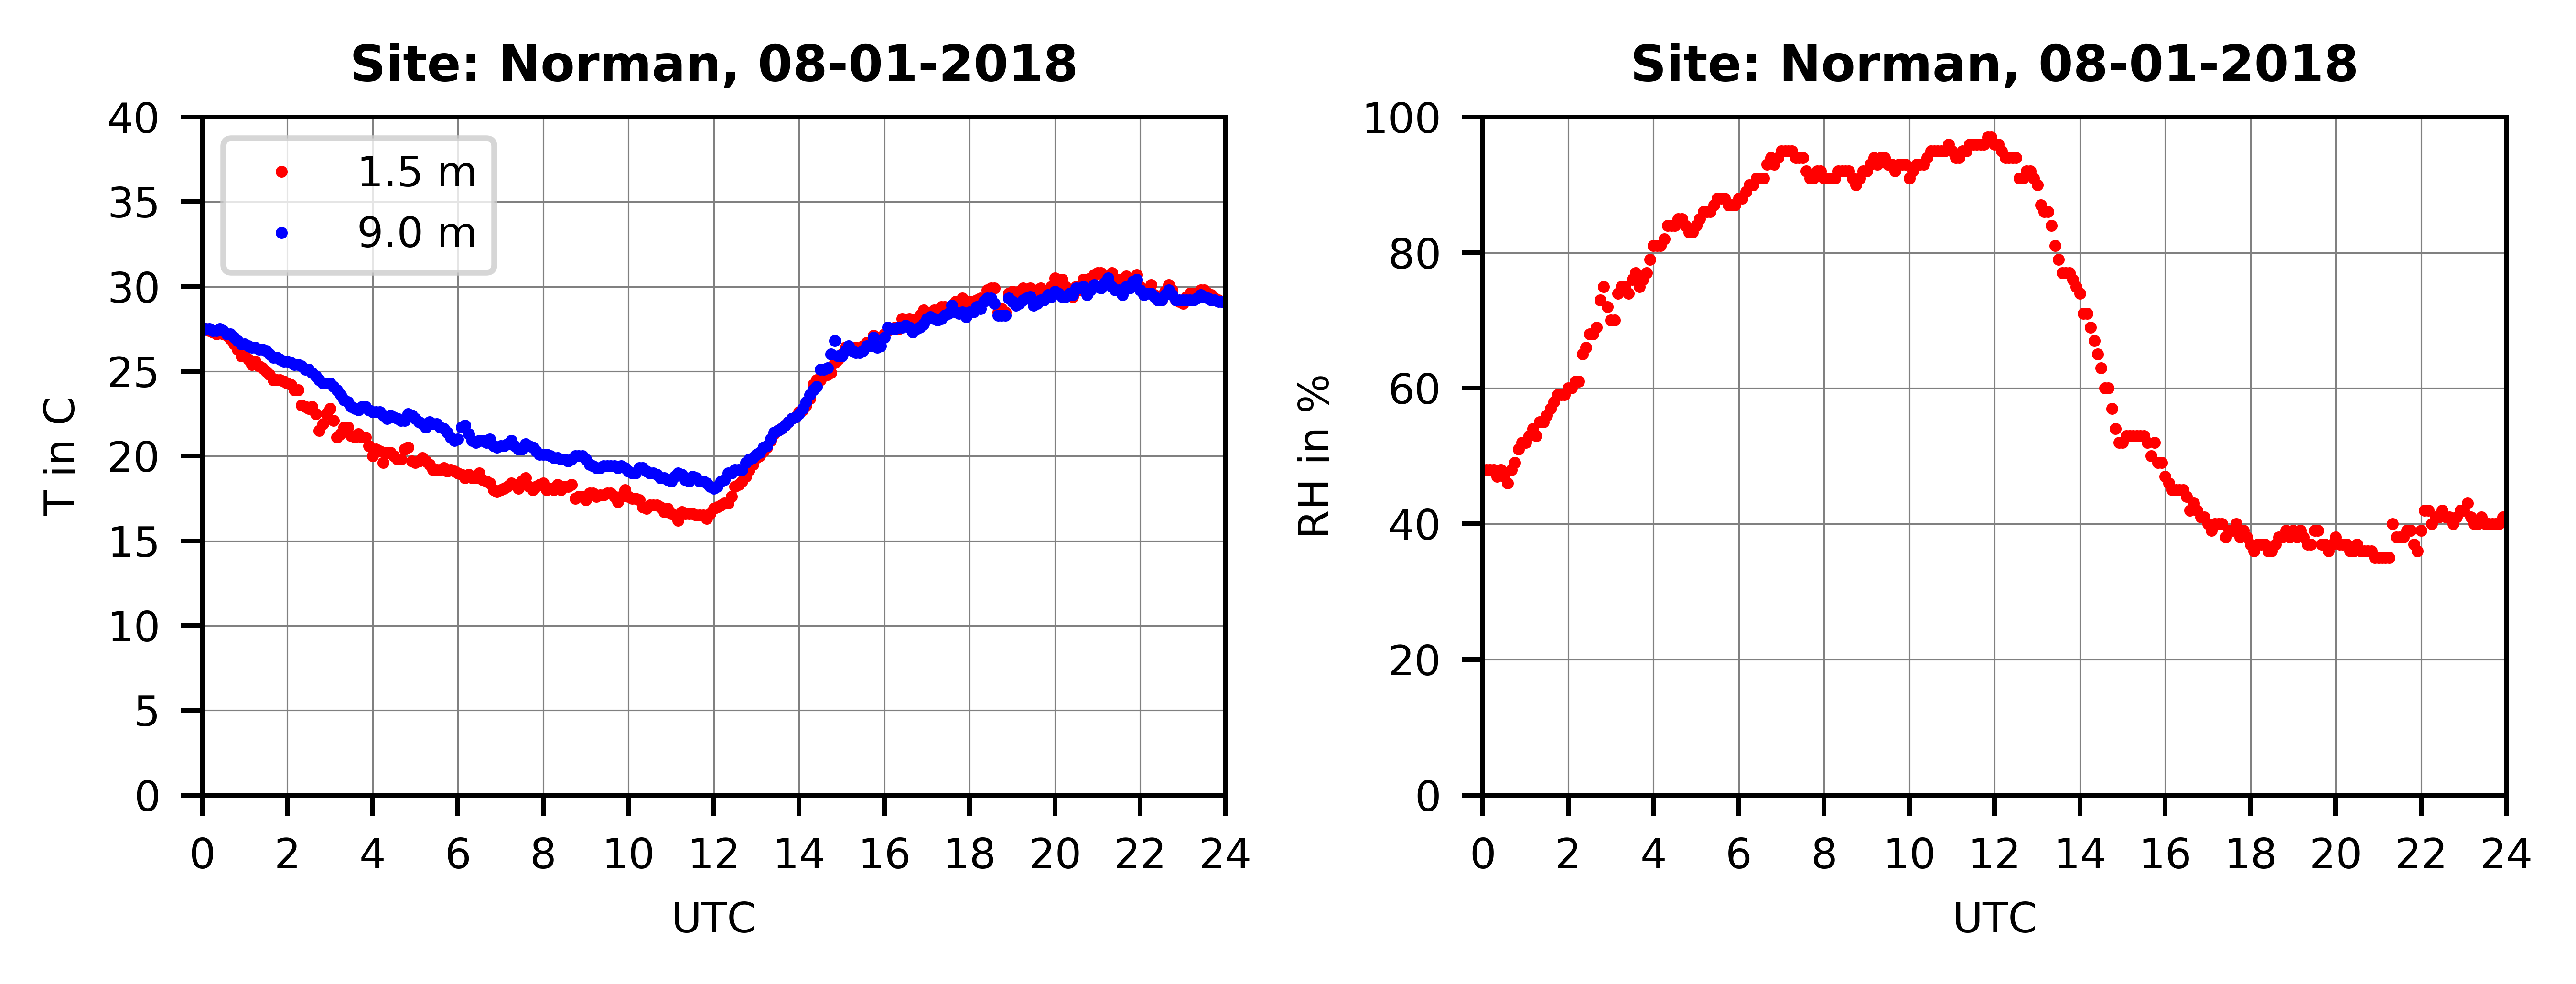

Importing  ./data/20180802nrmn.mts


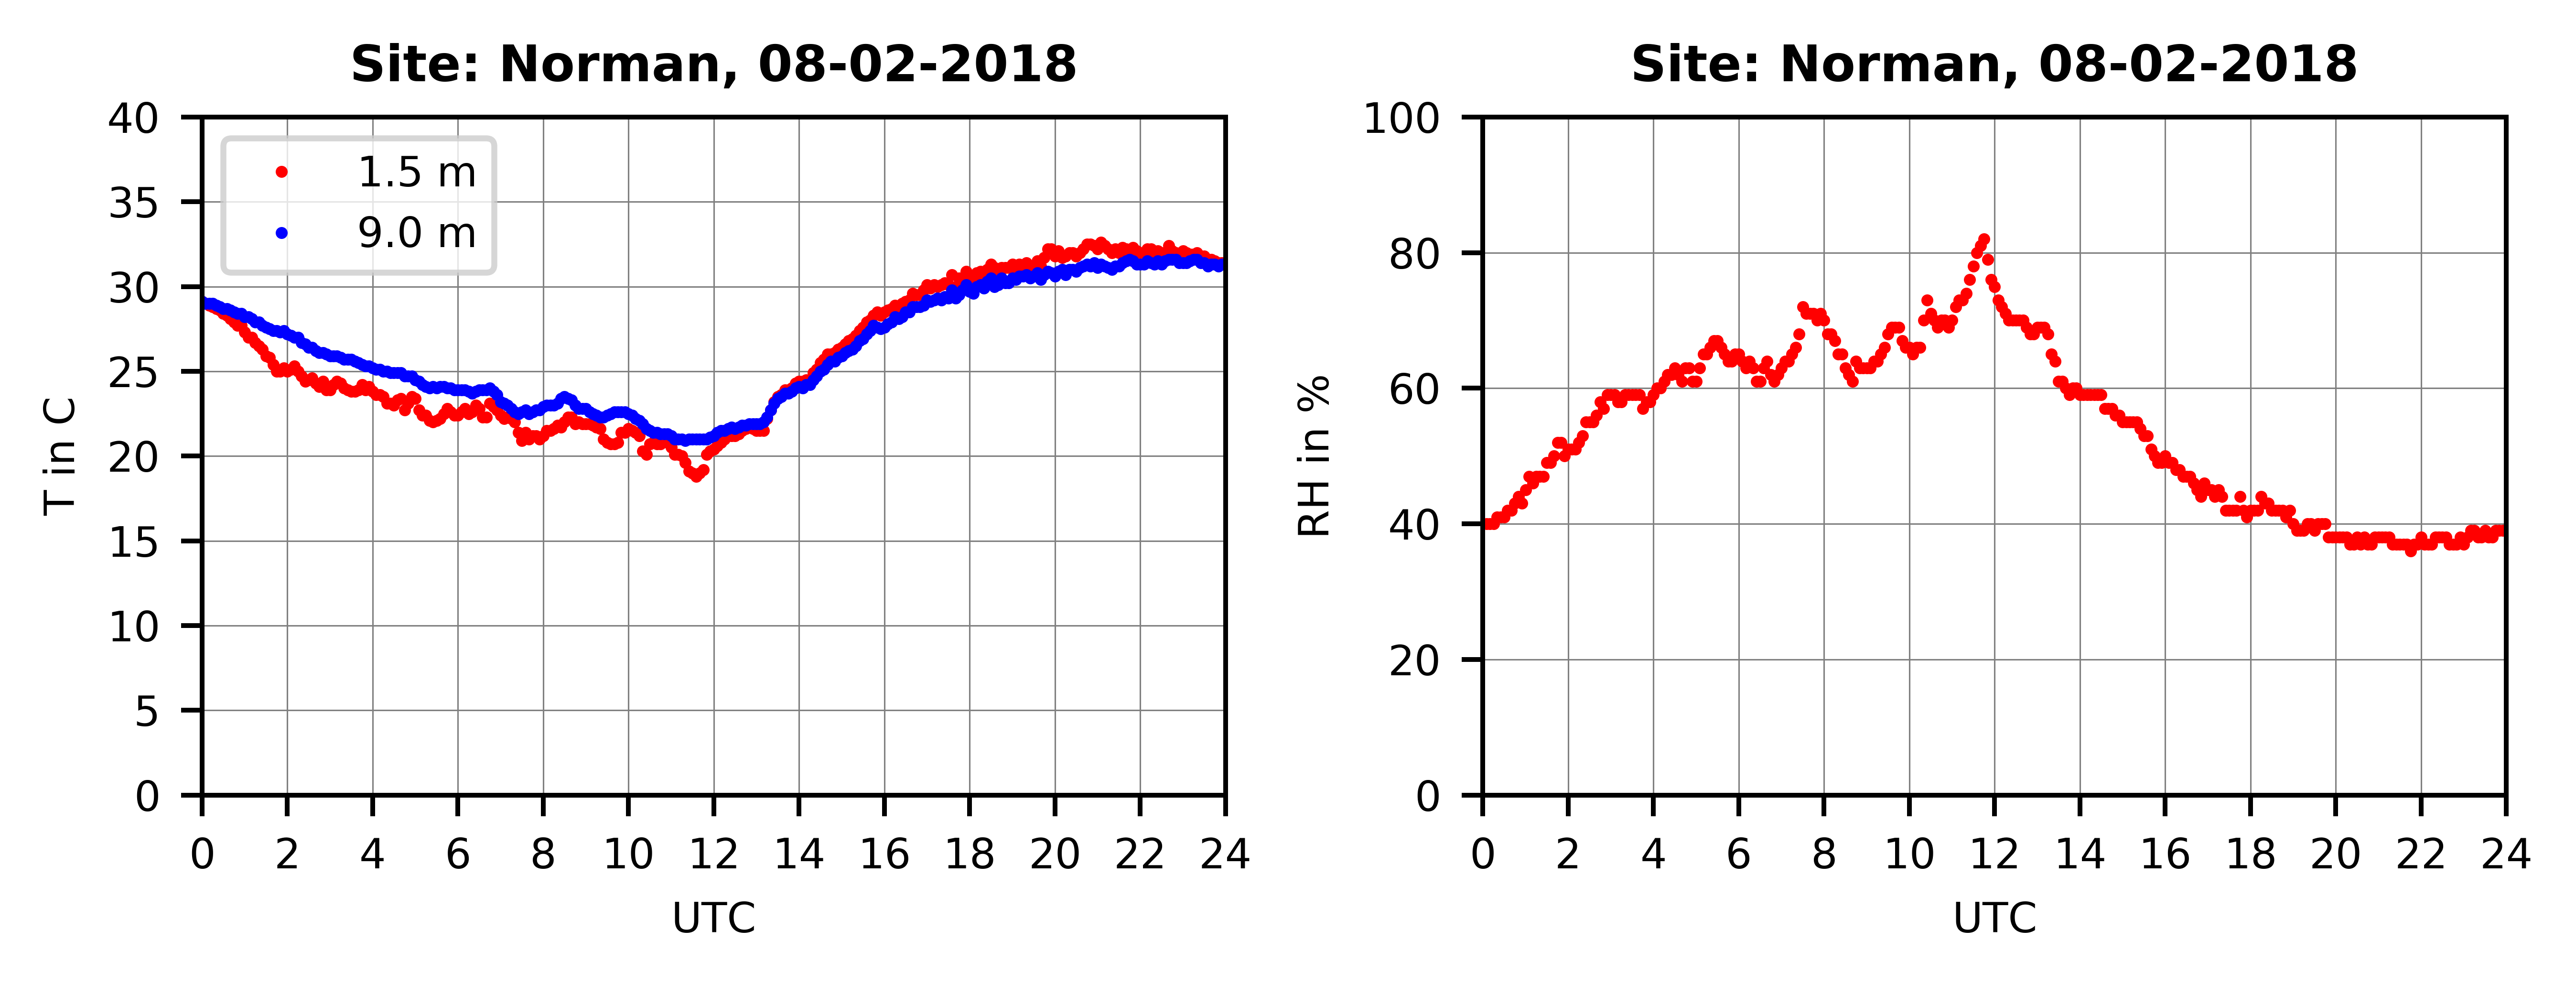

Importing  ./data/20180803nrmn.mts


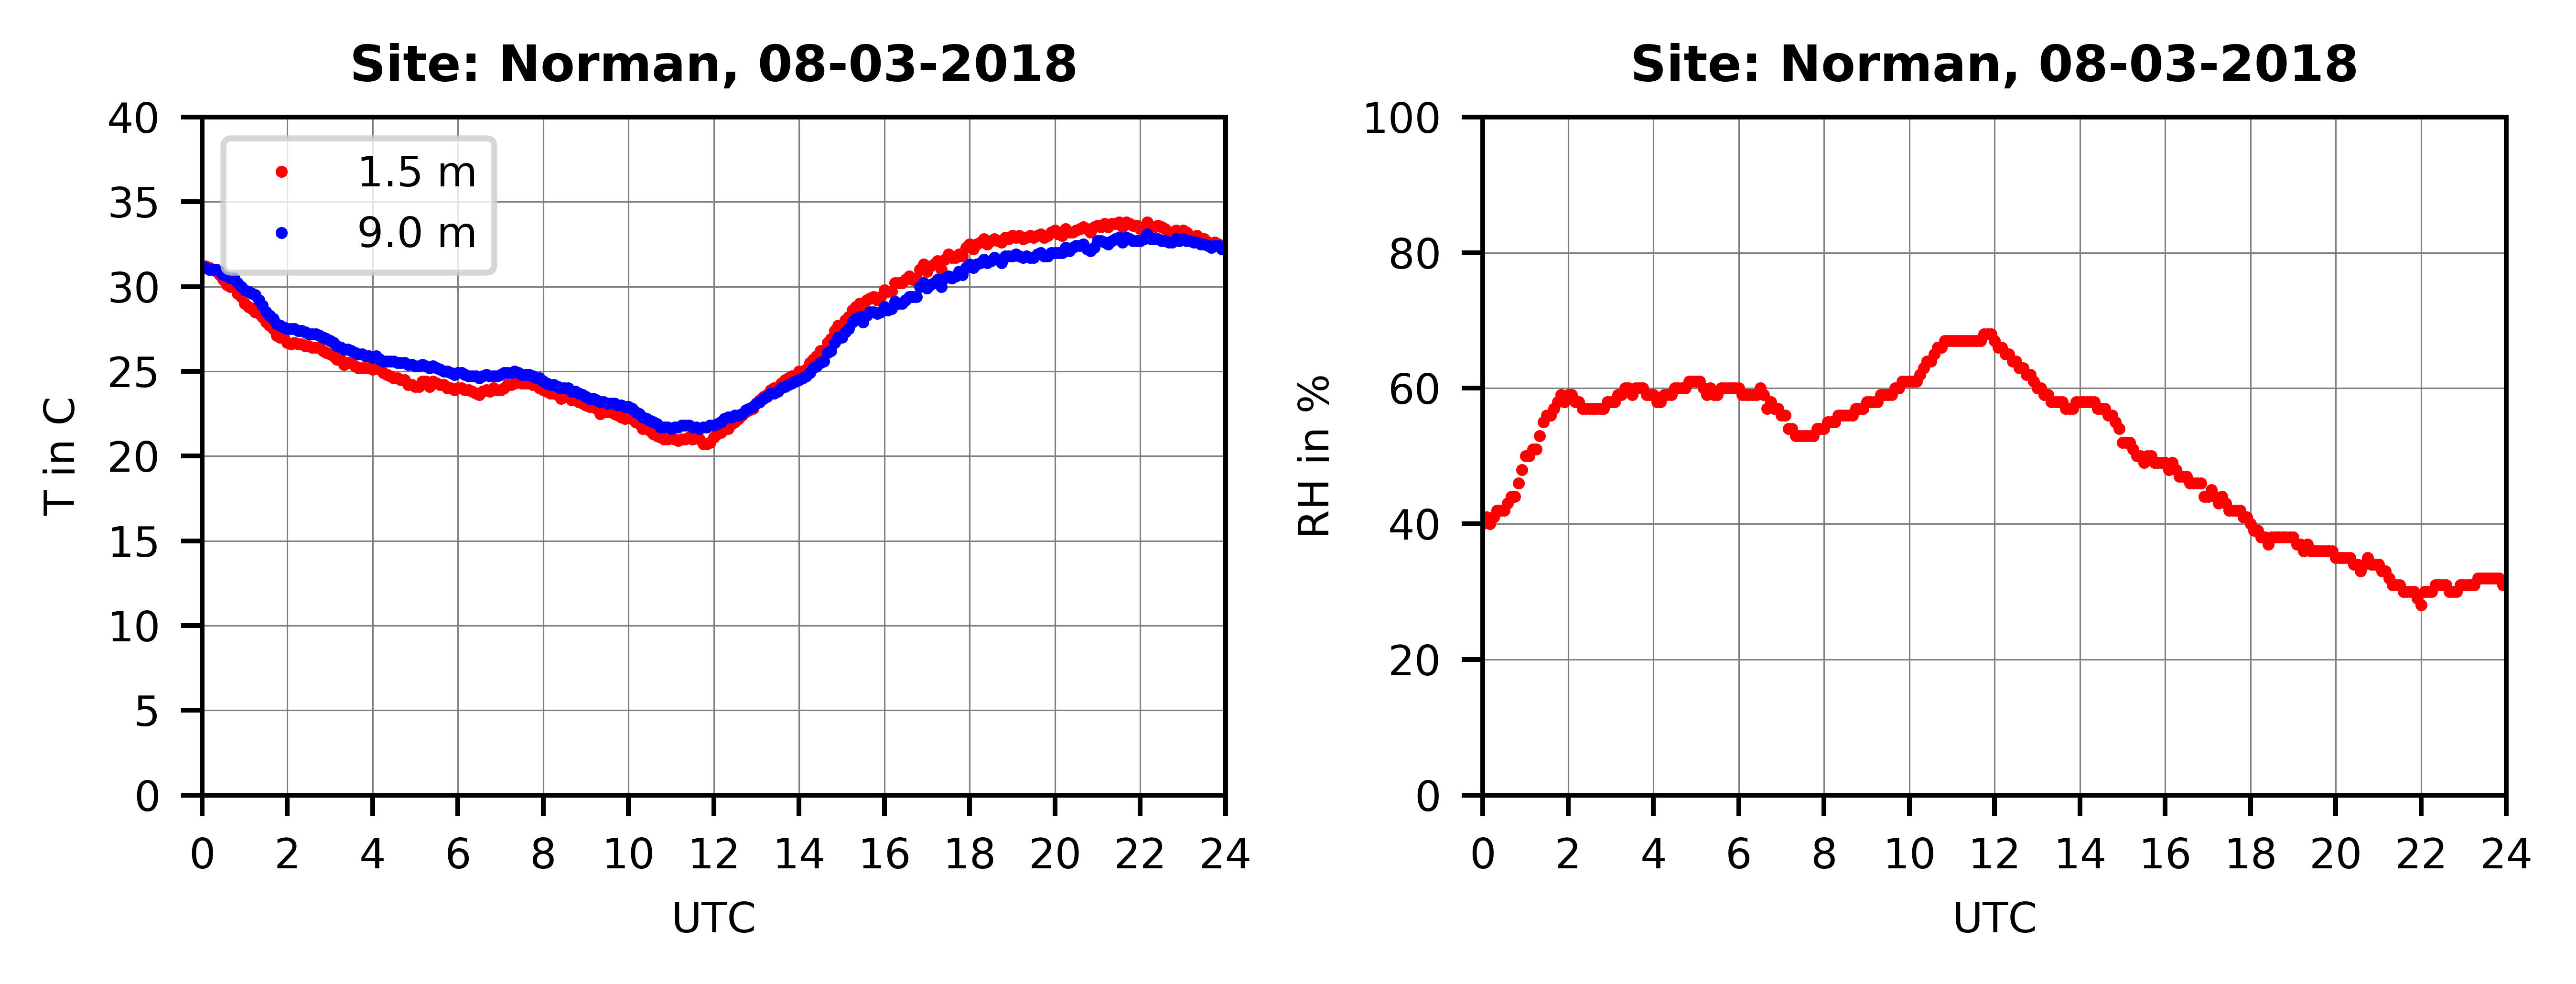

Importing  ./data/20180804nrmn.mts


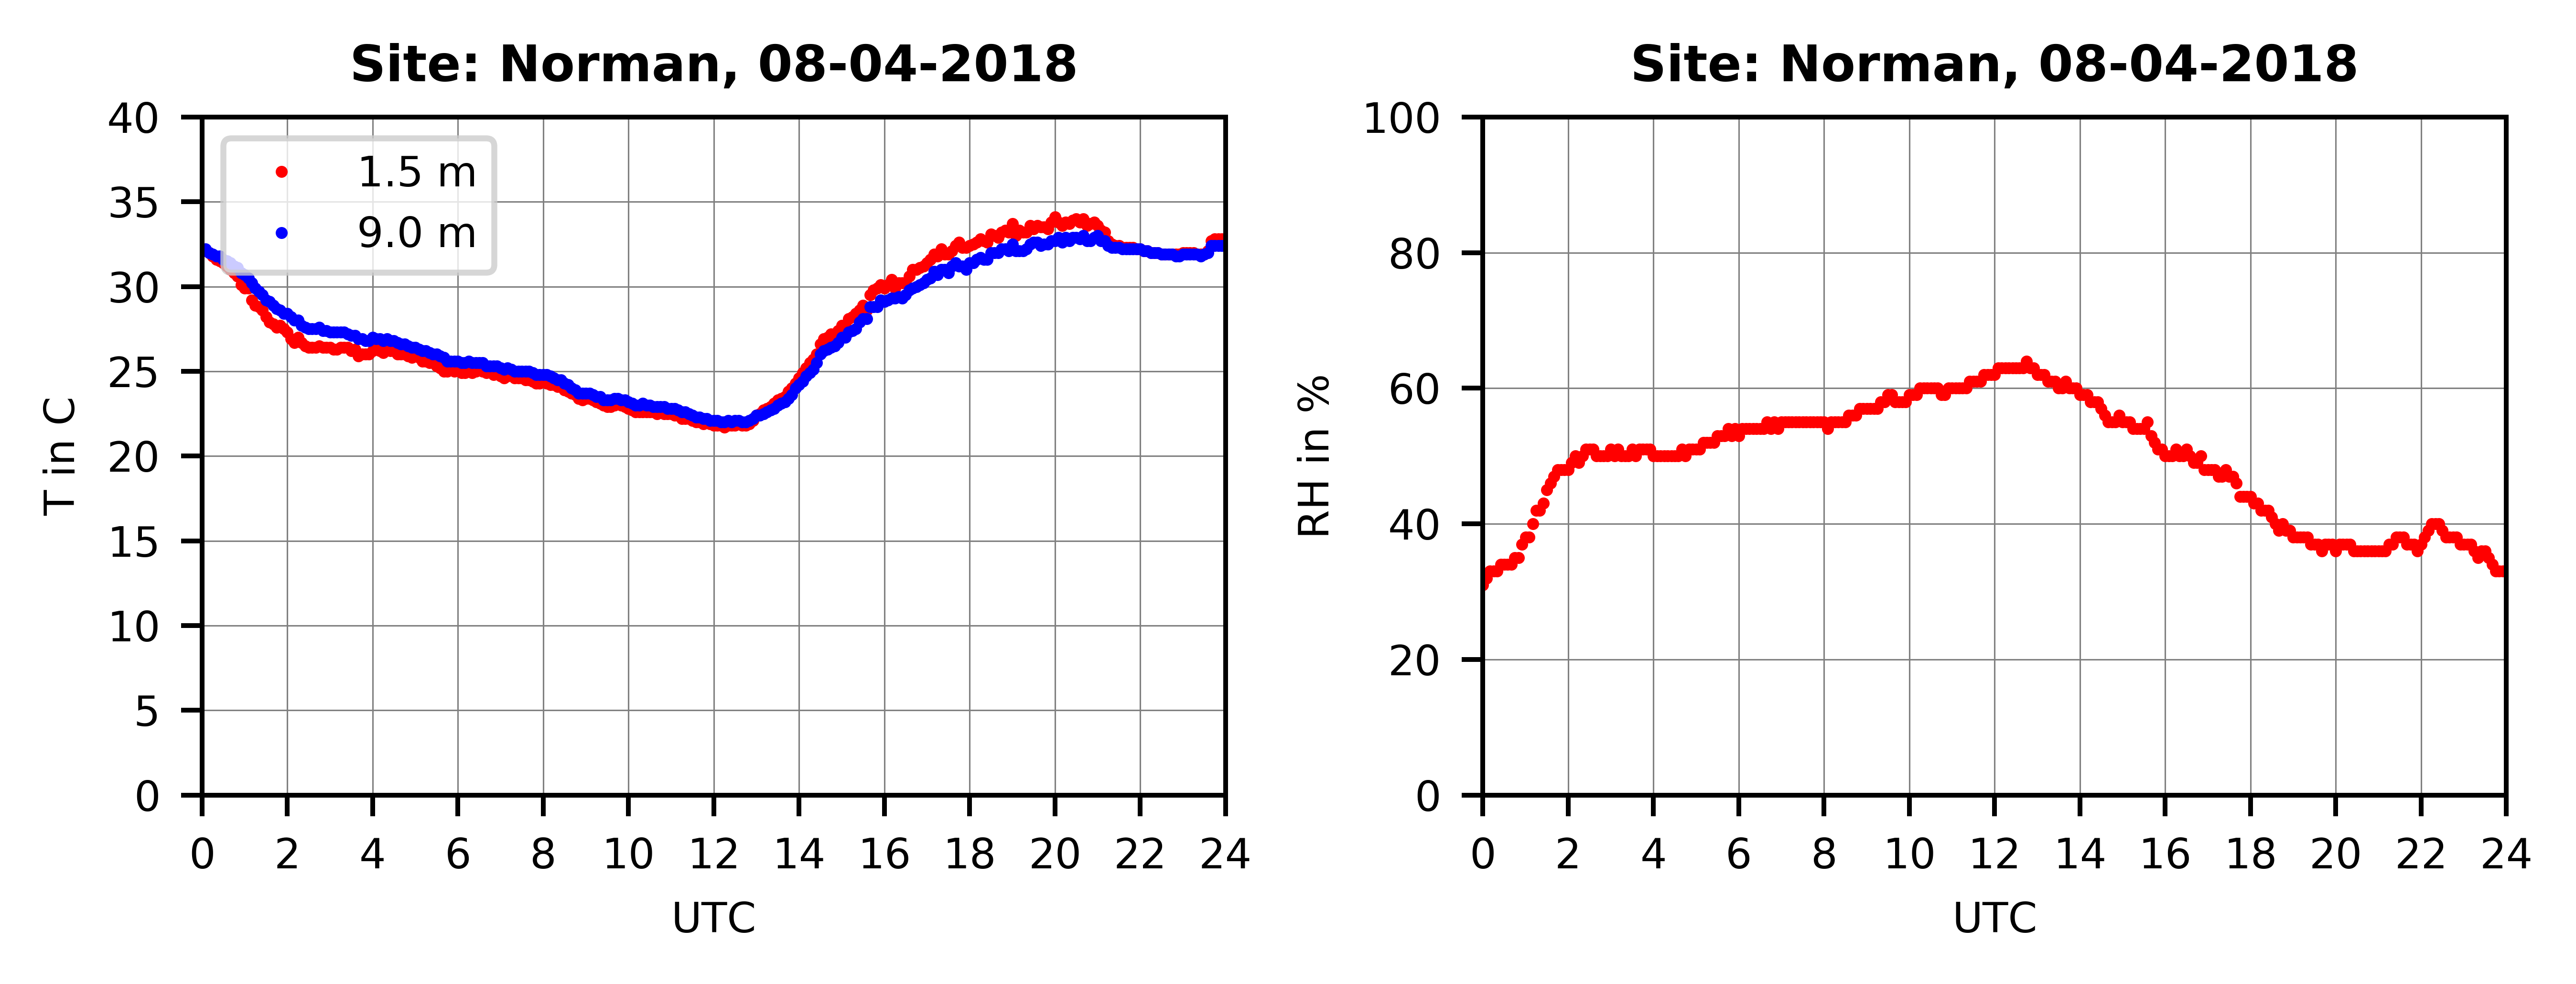

Importing  ./data/20180805nrmn.mts


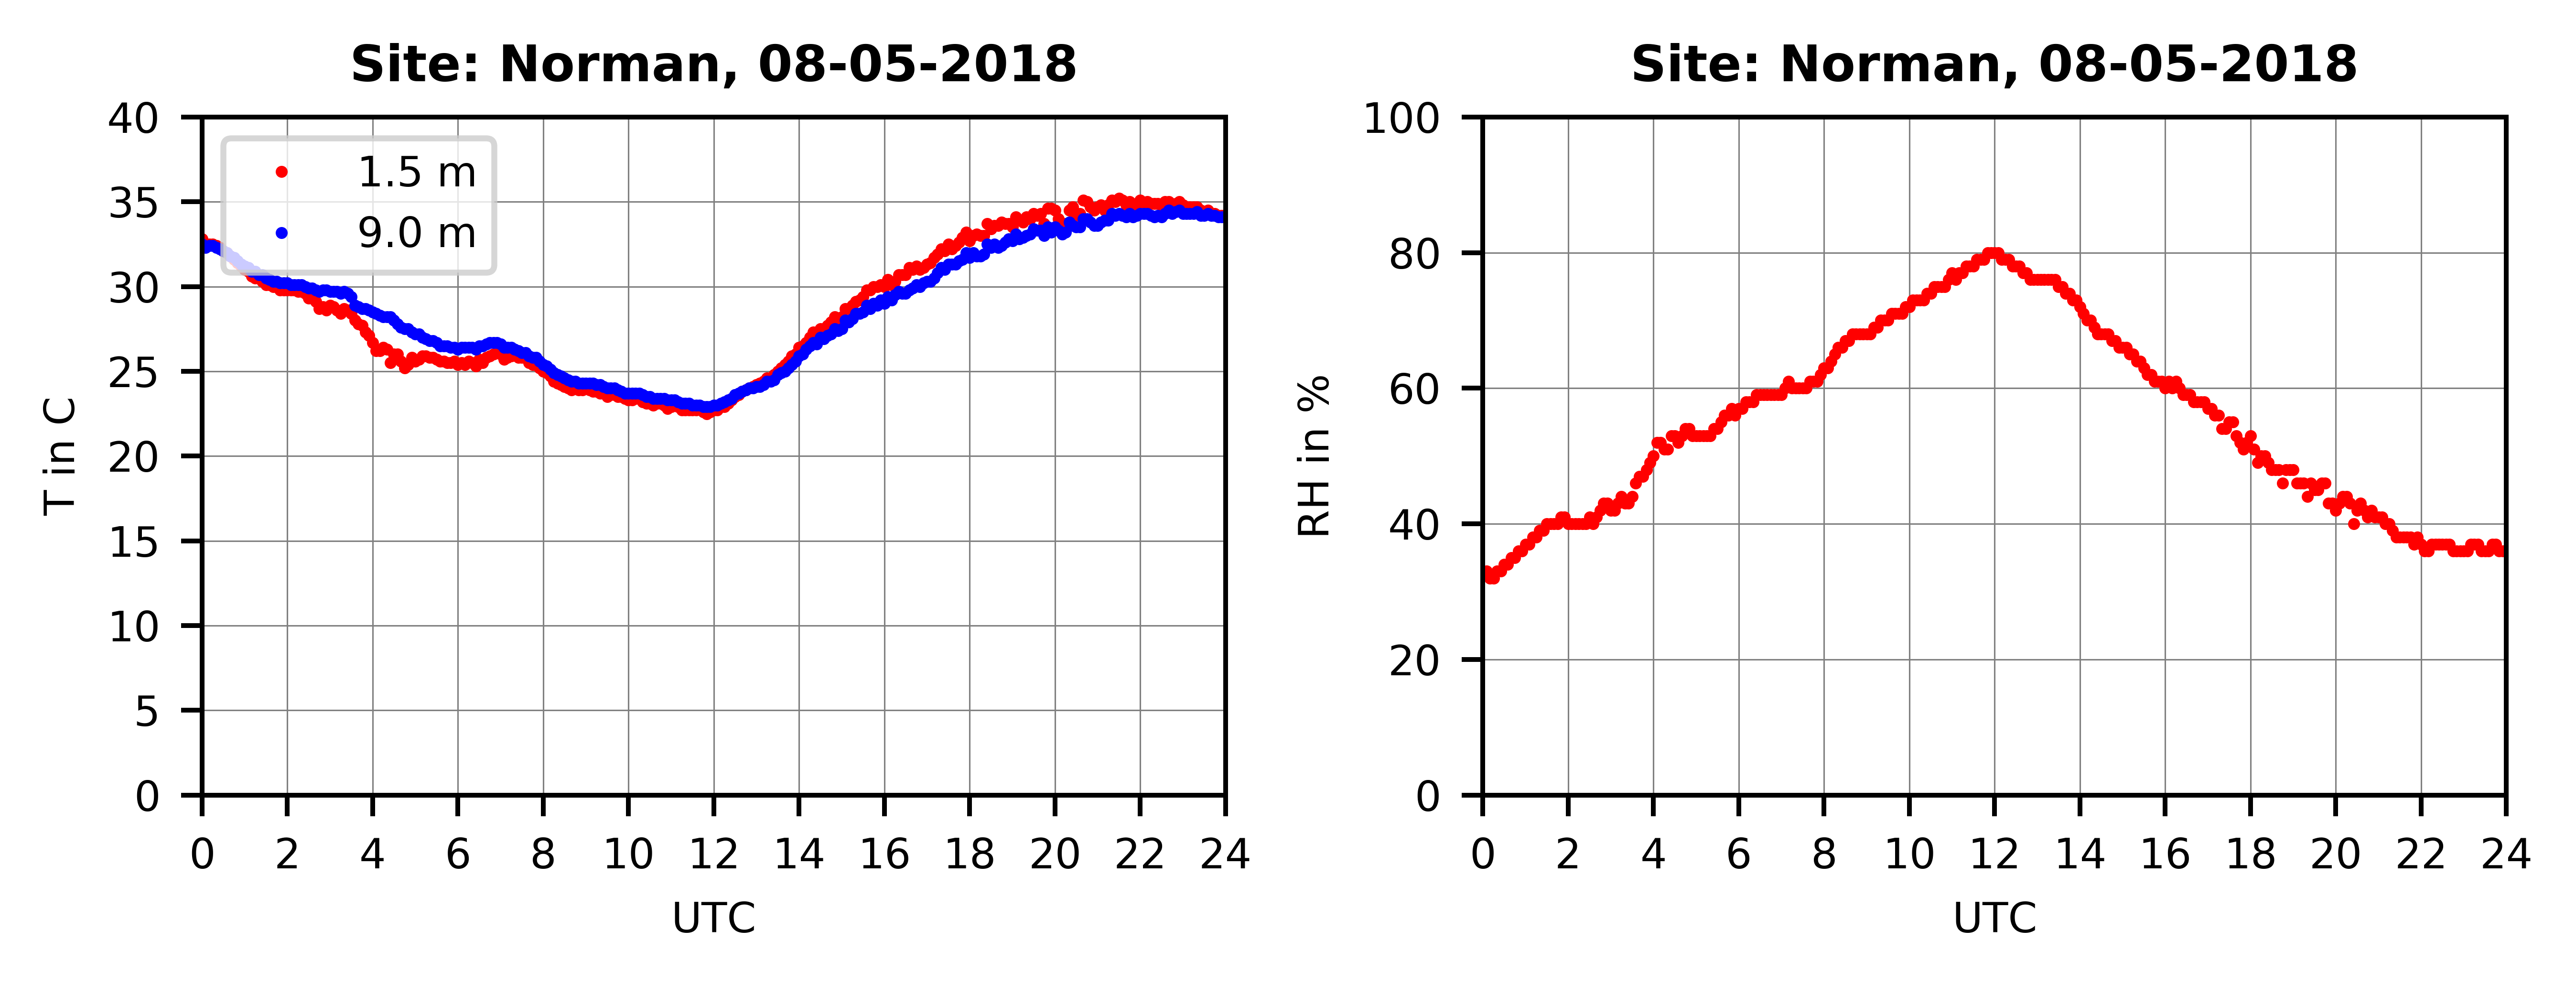

Importing  ./data/20180806nrmn.mts


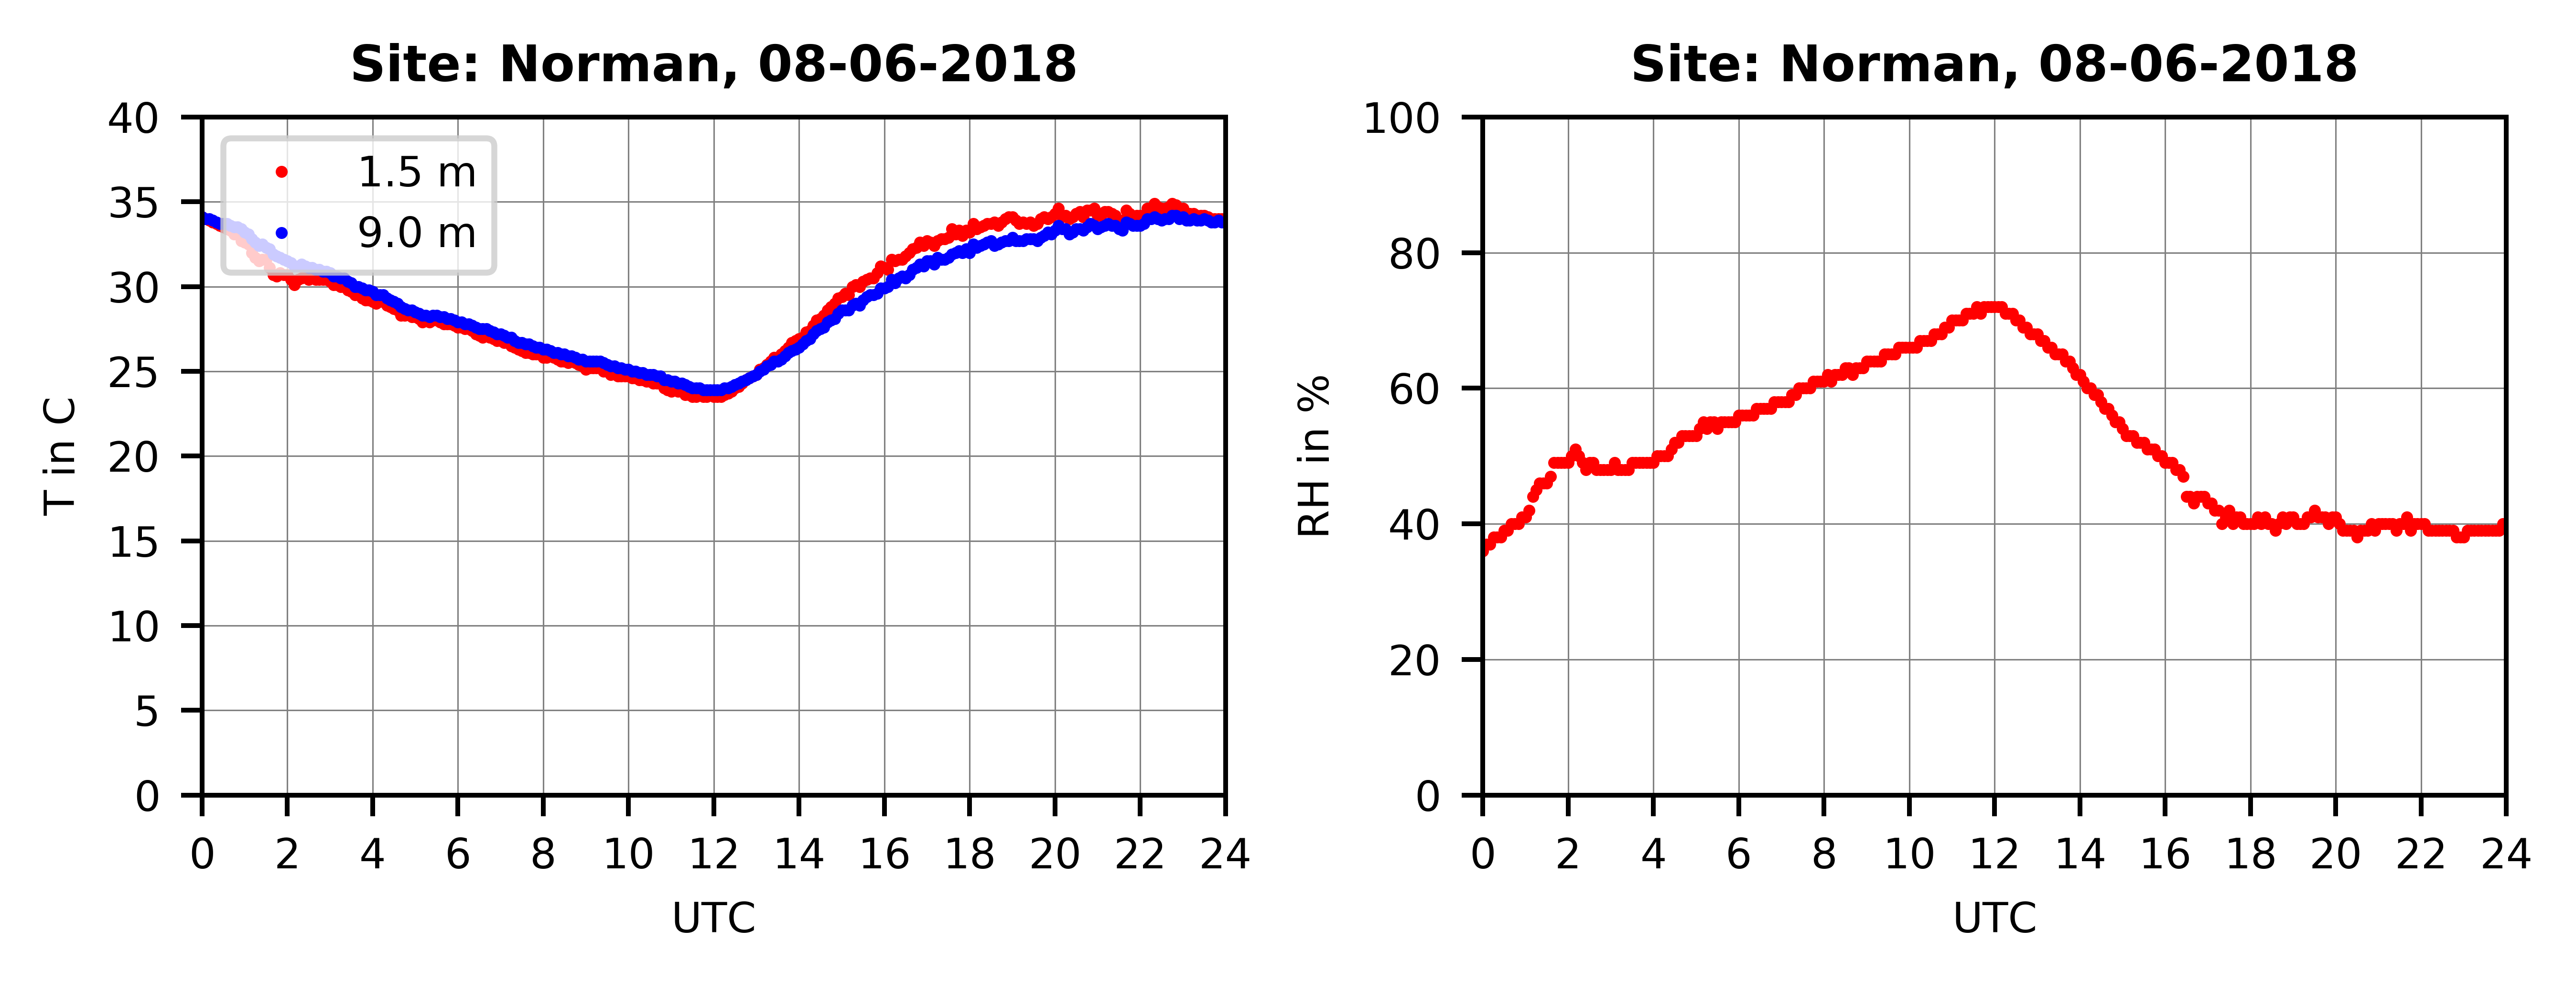

Importing  ./data/20180807nrmn.mts


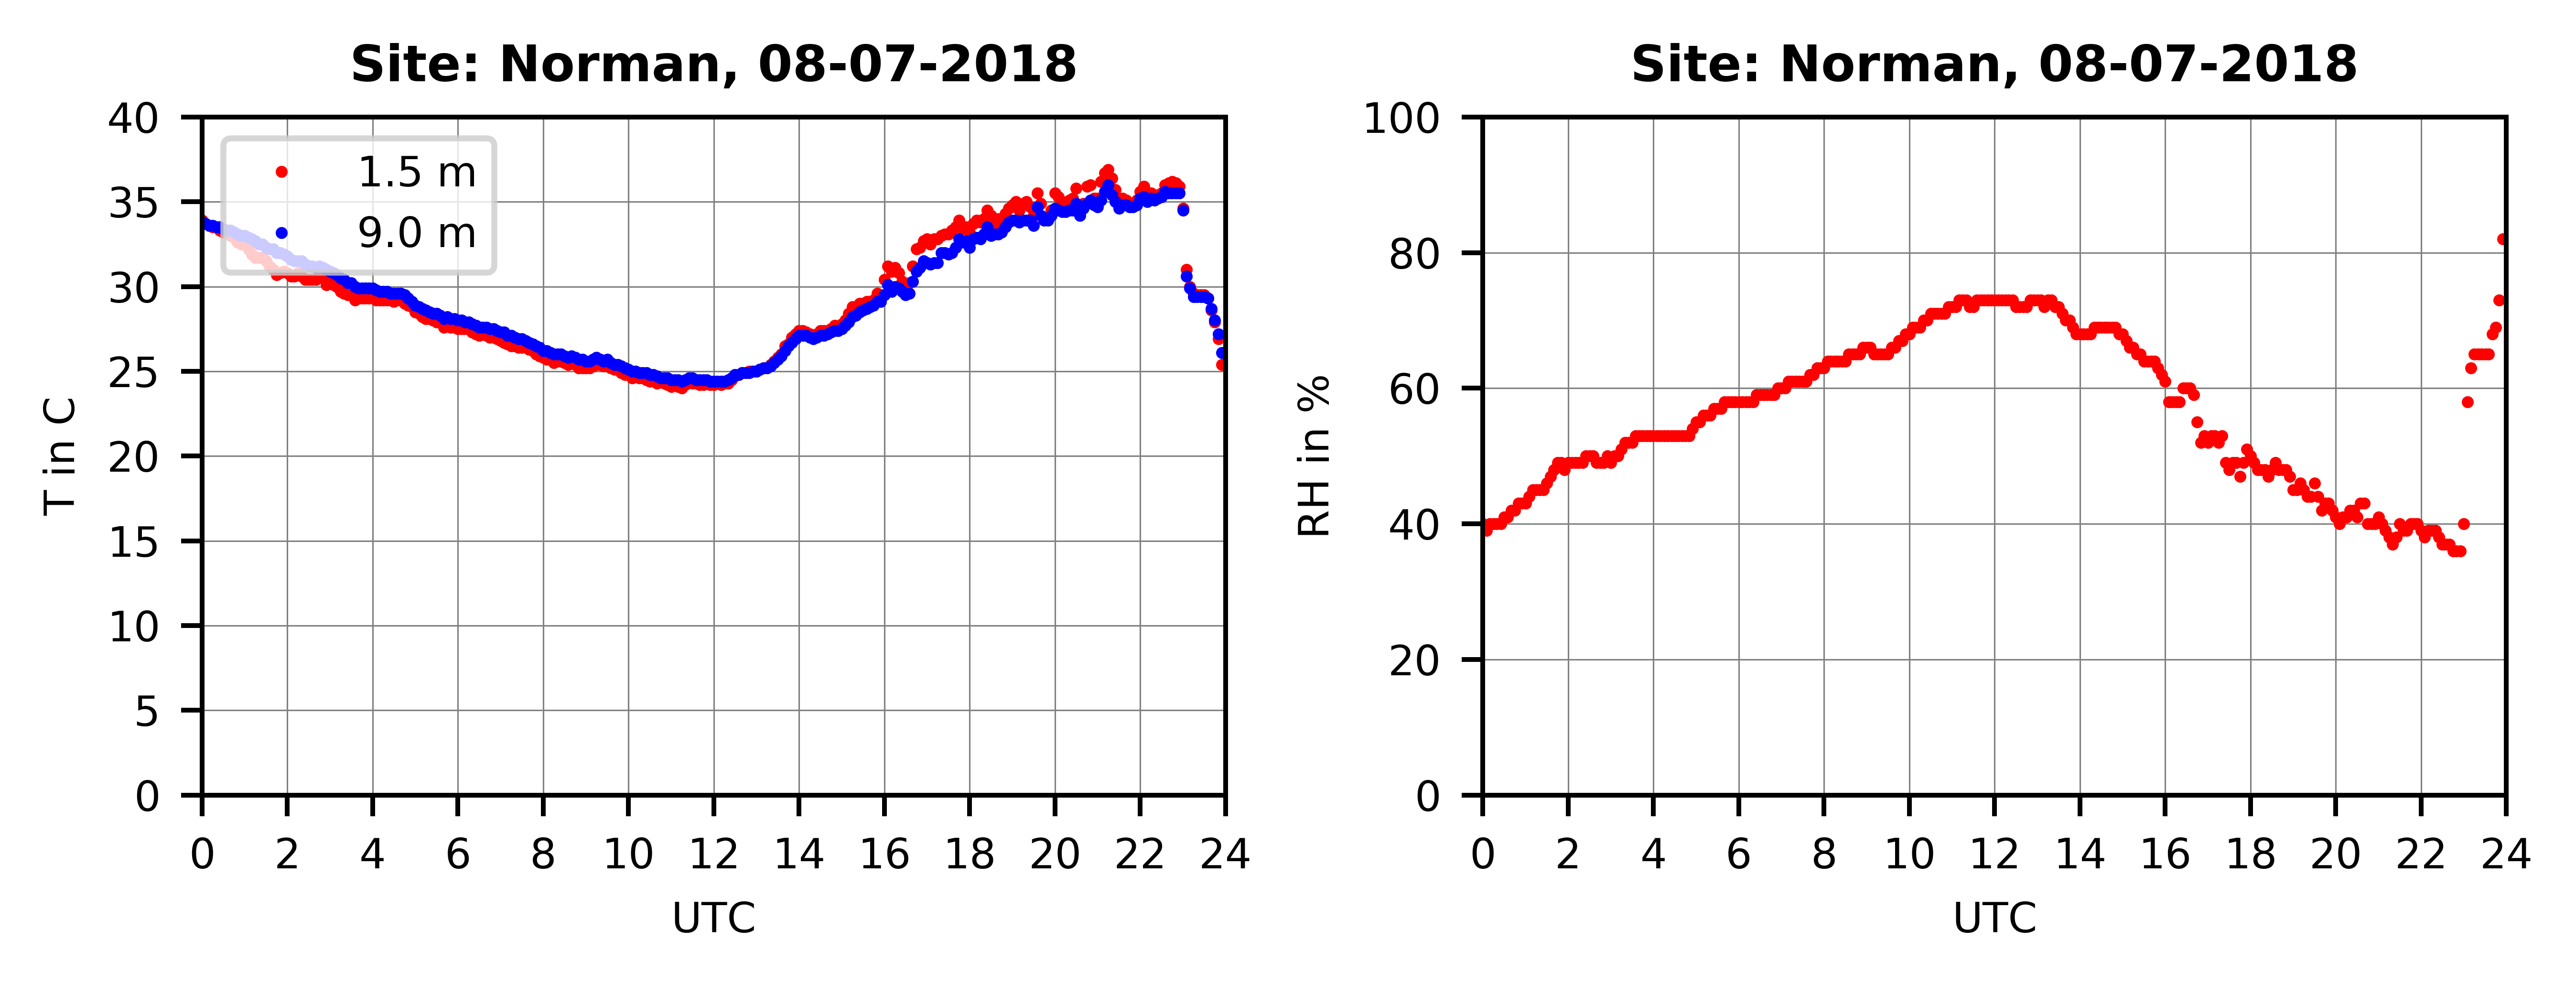

Importing  ./data/20180808nrmn.mts


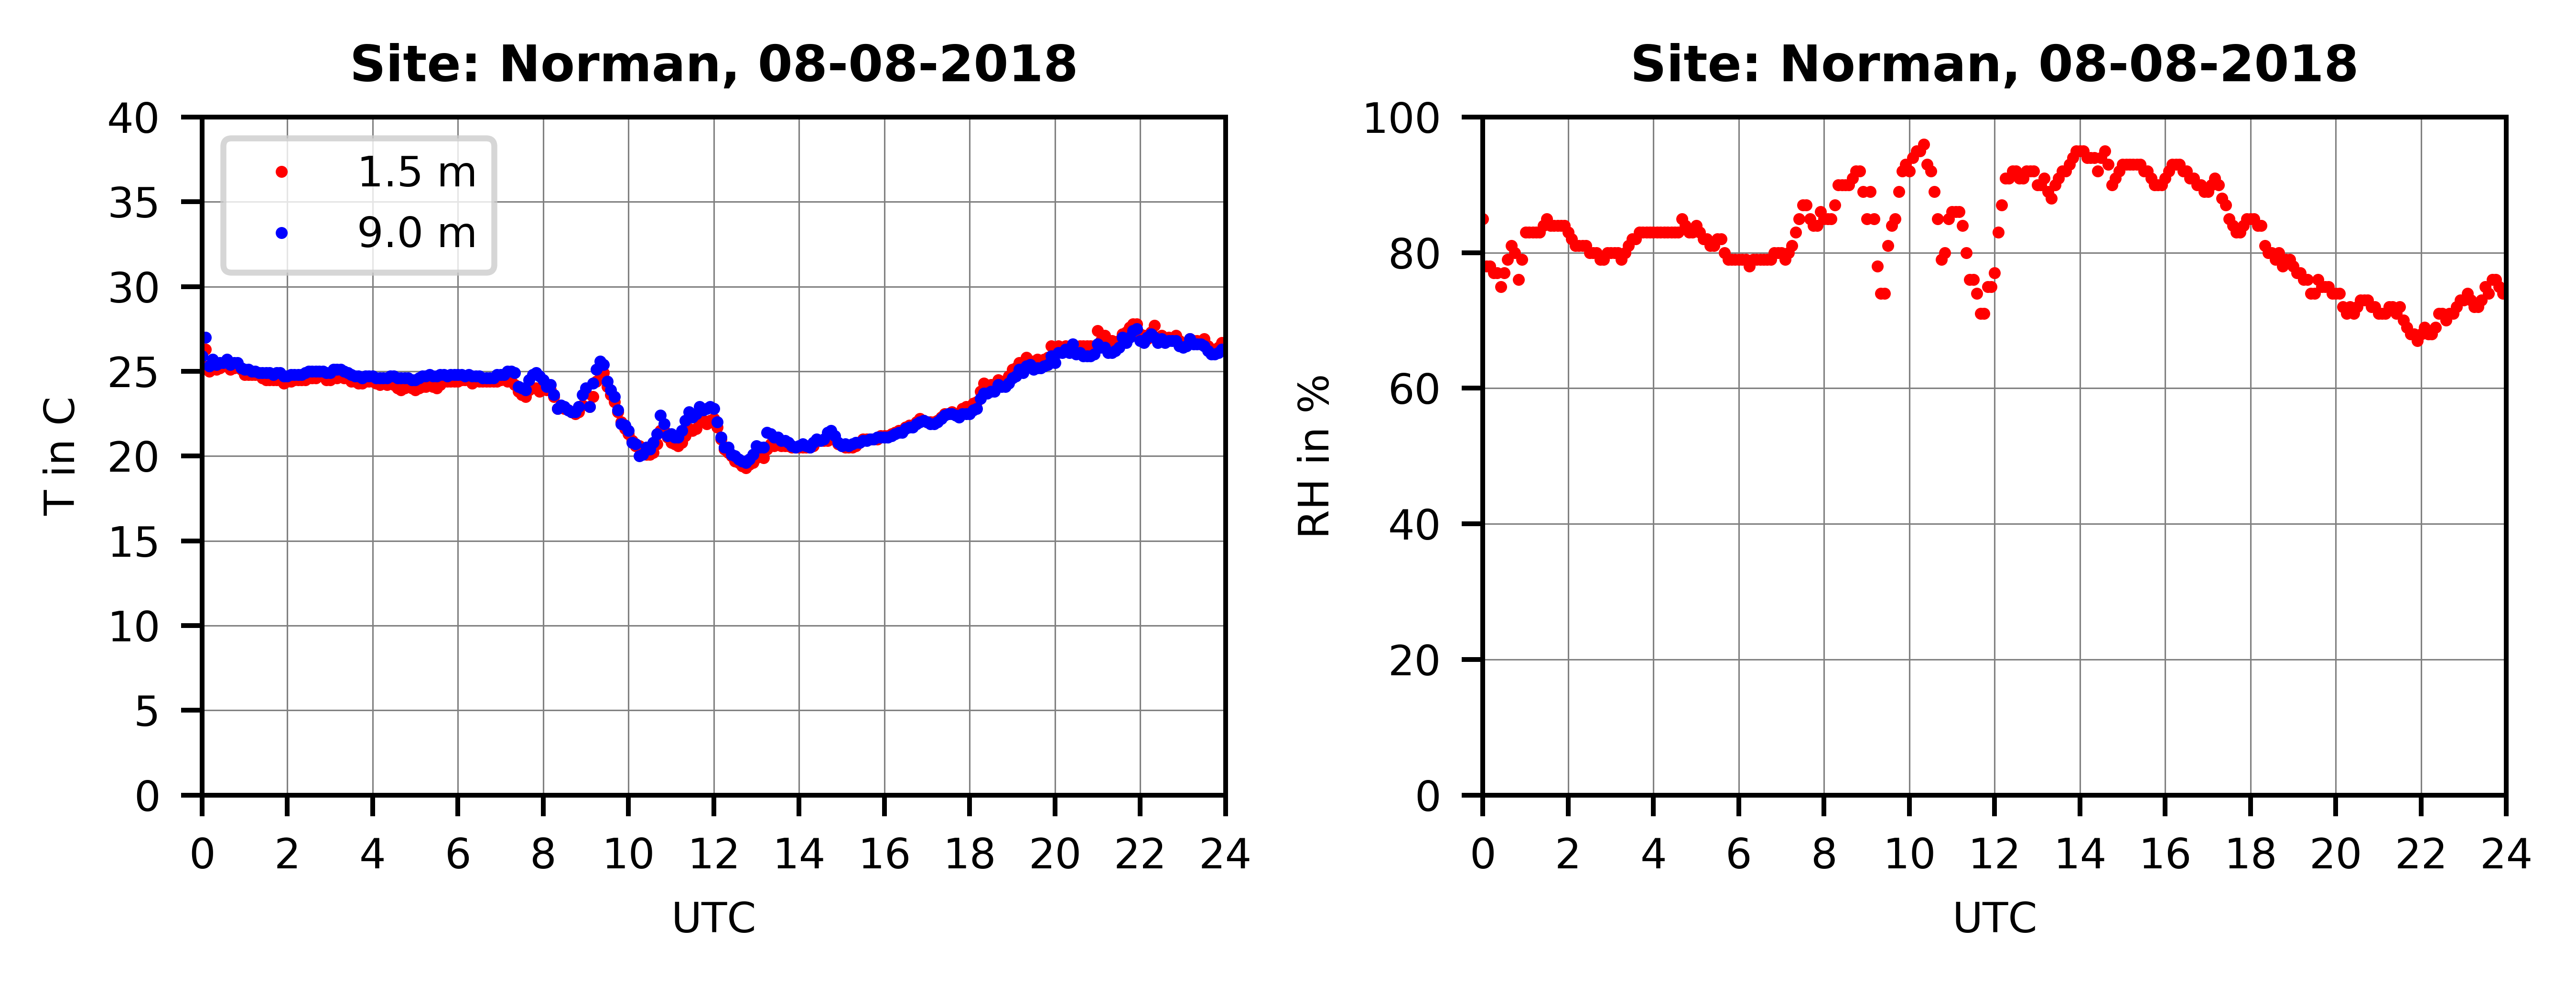

Importing  ./data/20180809nrmn.mts


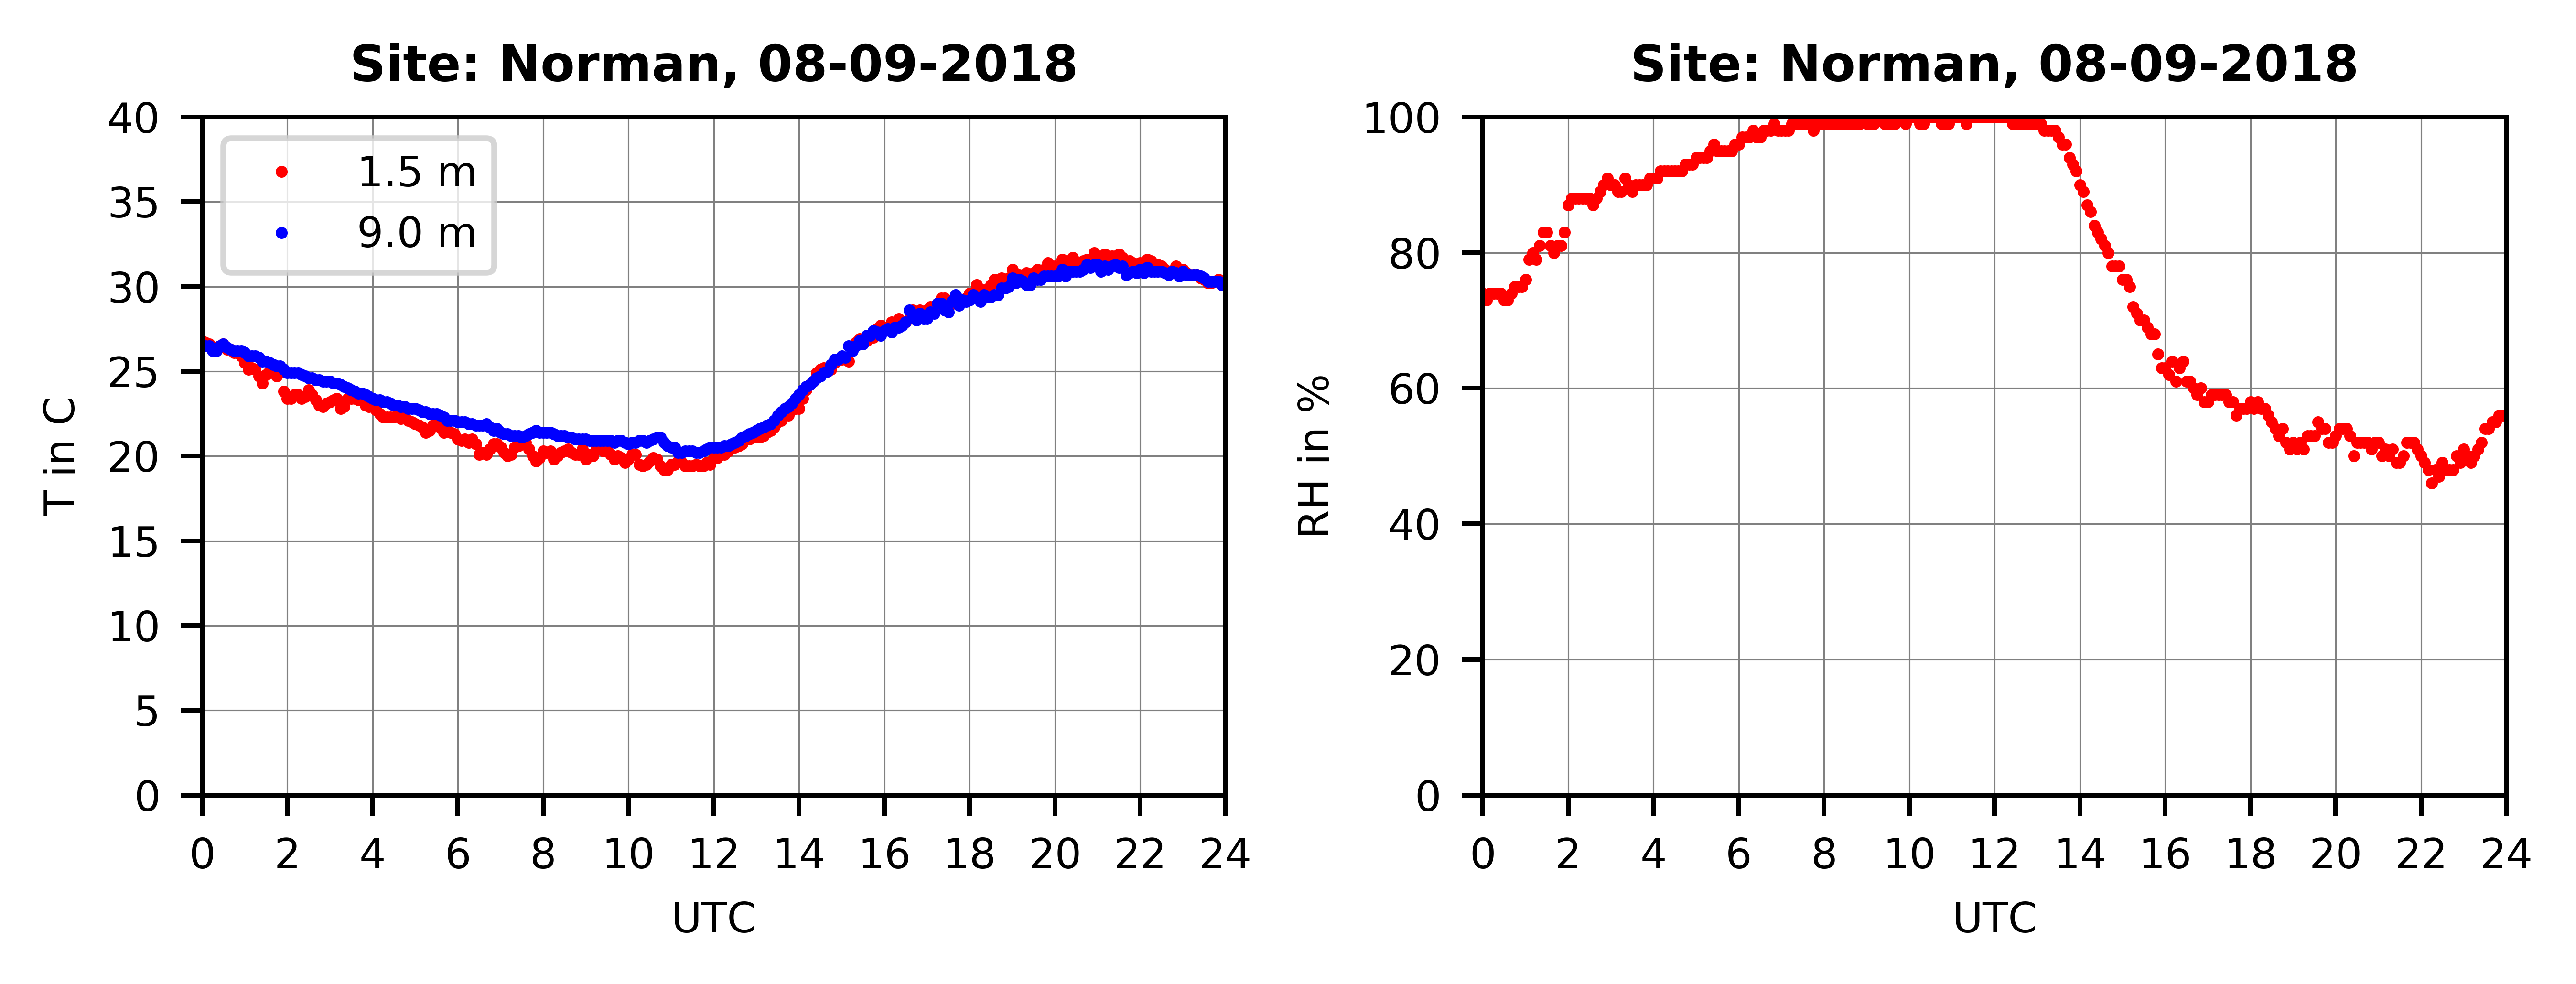

Importing  ./data/20180810nrmn.mts


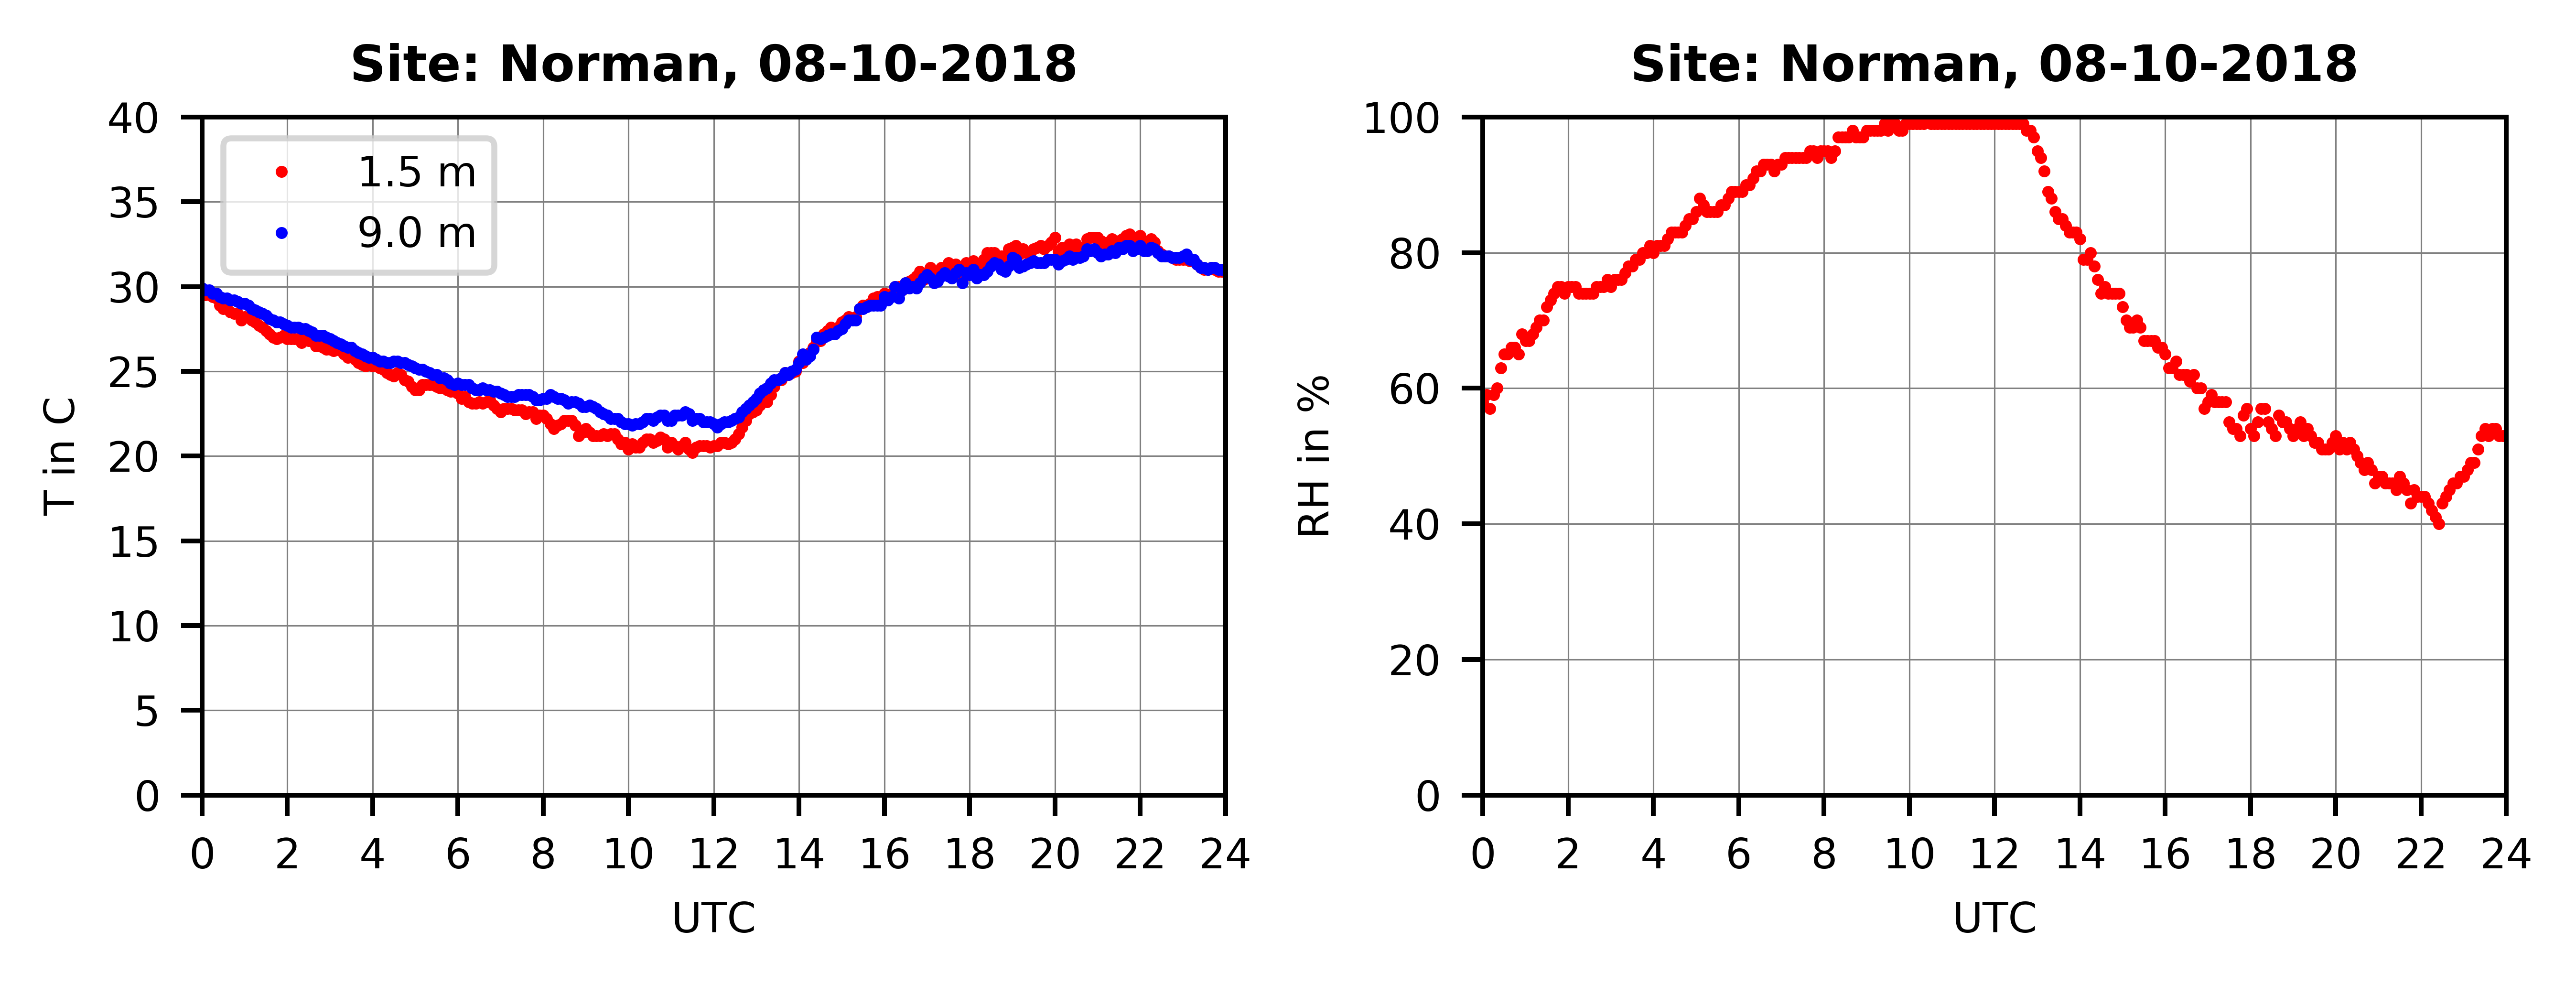

Importing  ./data/20180811nrmn.mts


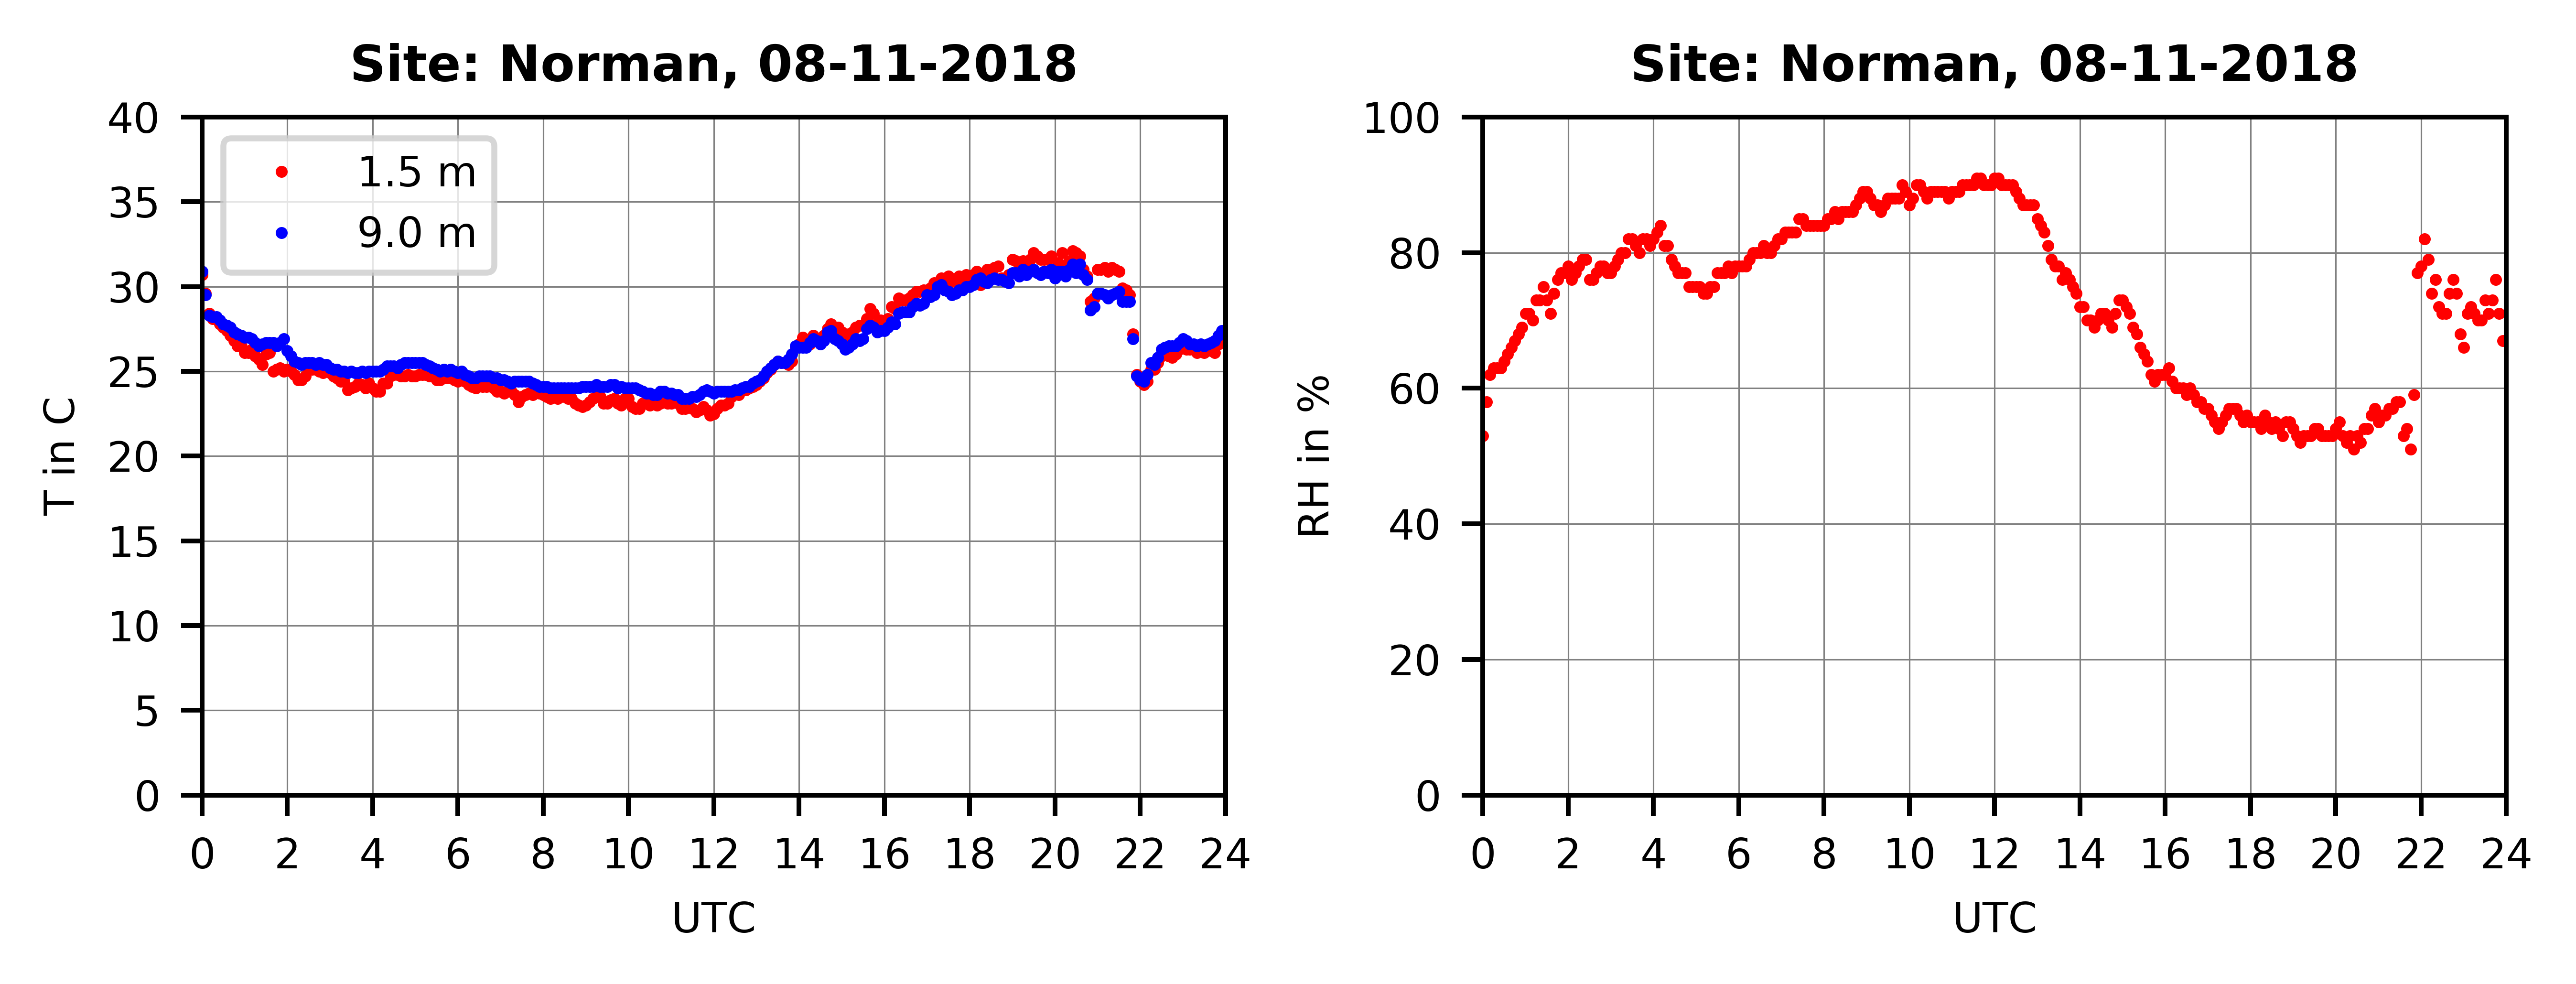

Importing  ./data/20180812nrmn.mts


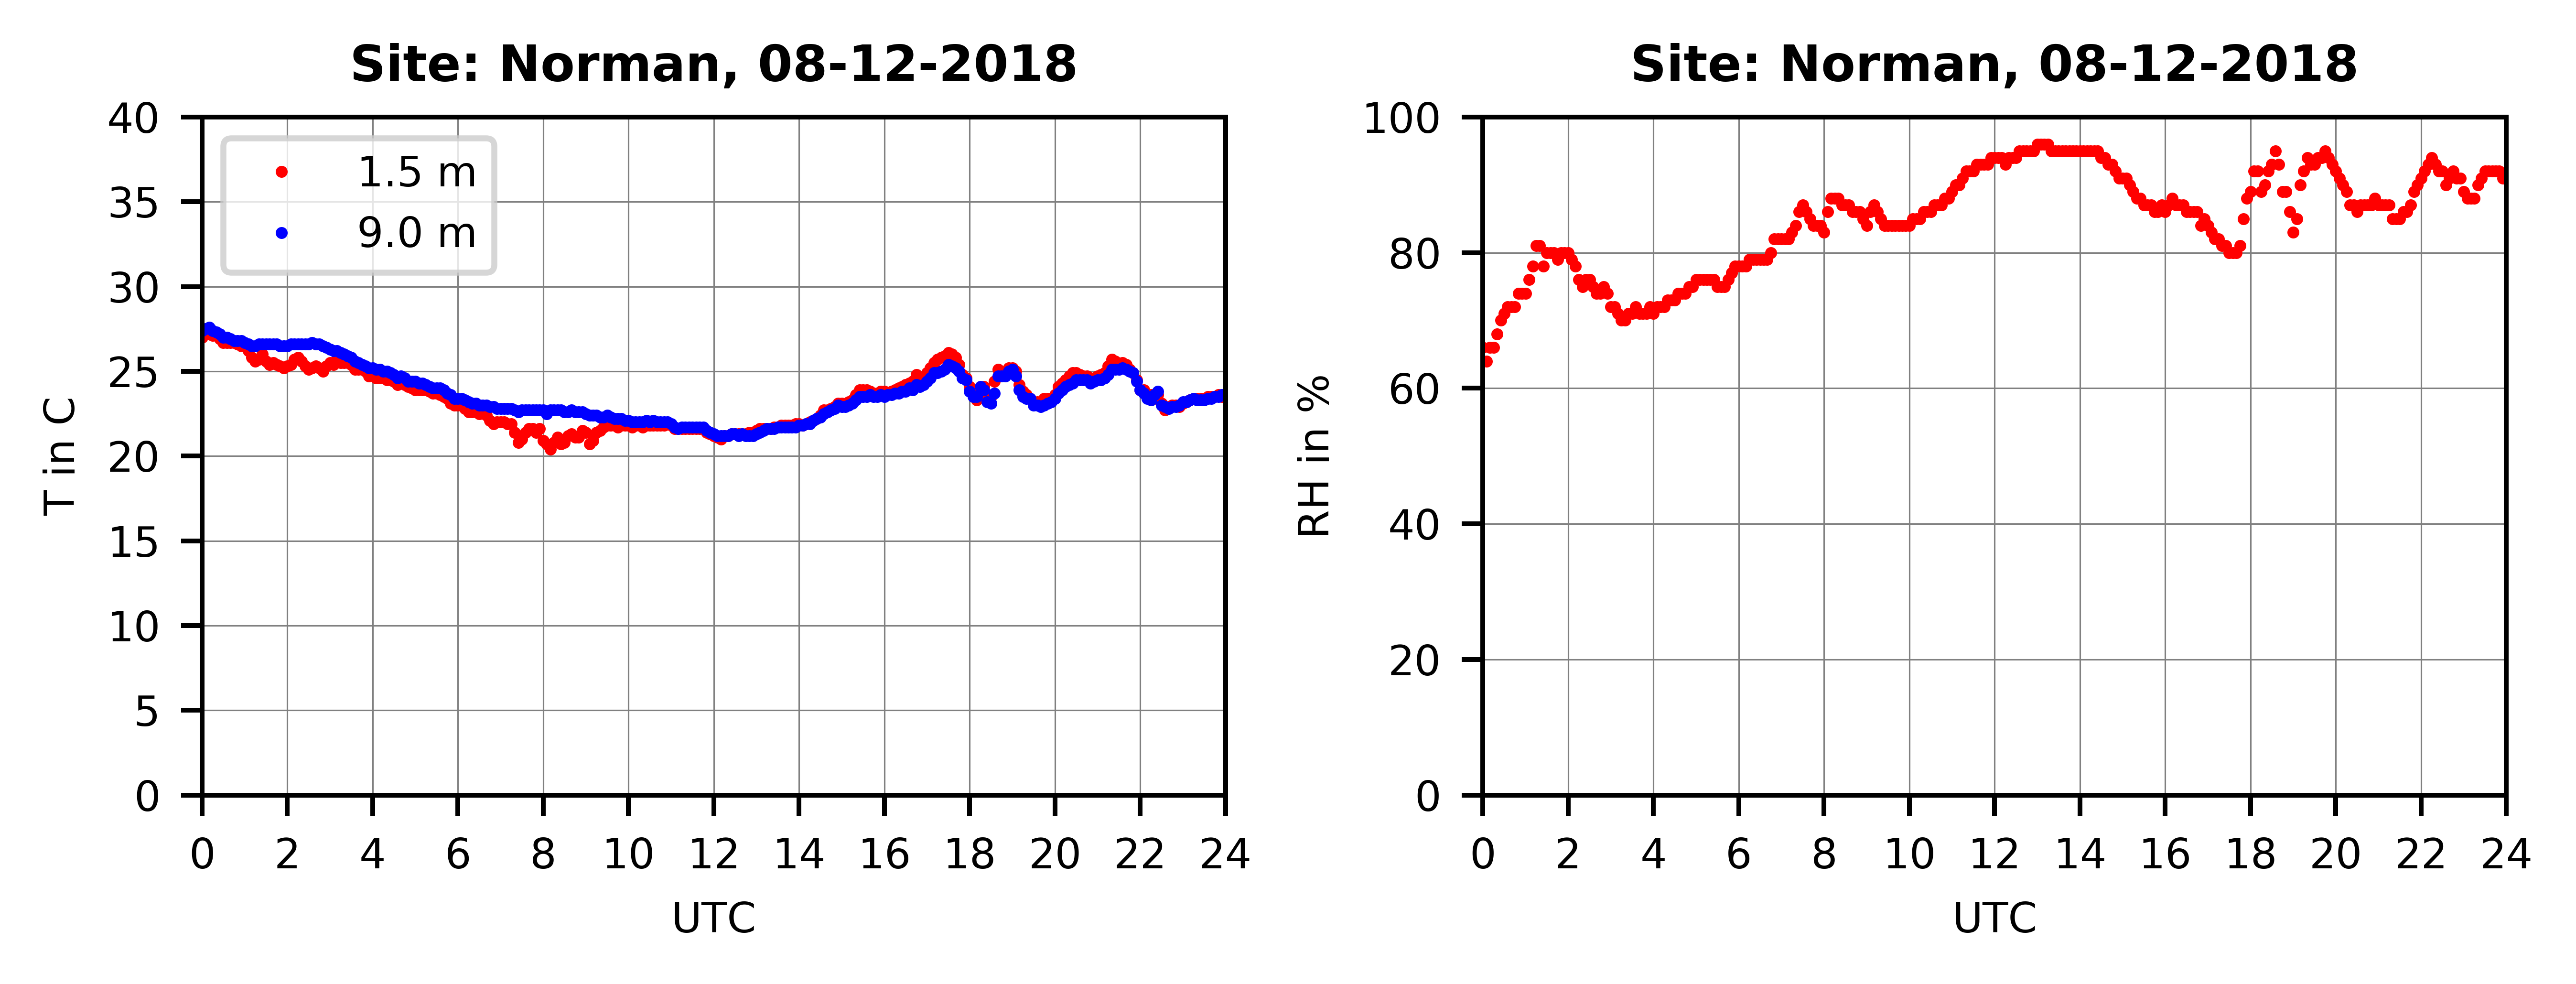

Importing  ./data/20180813nrmn.mts


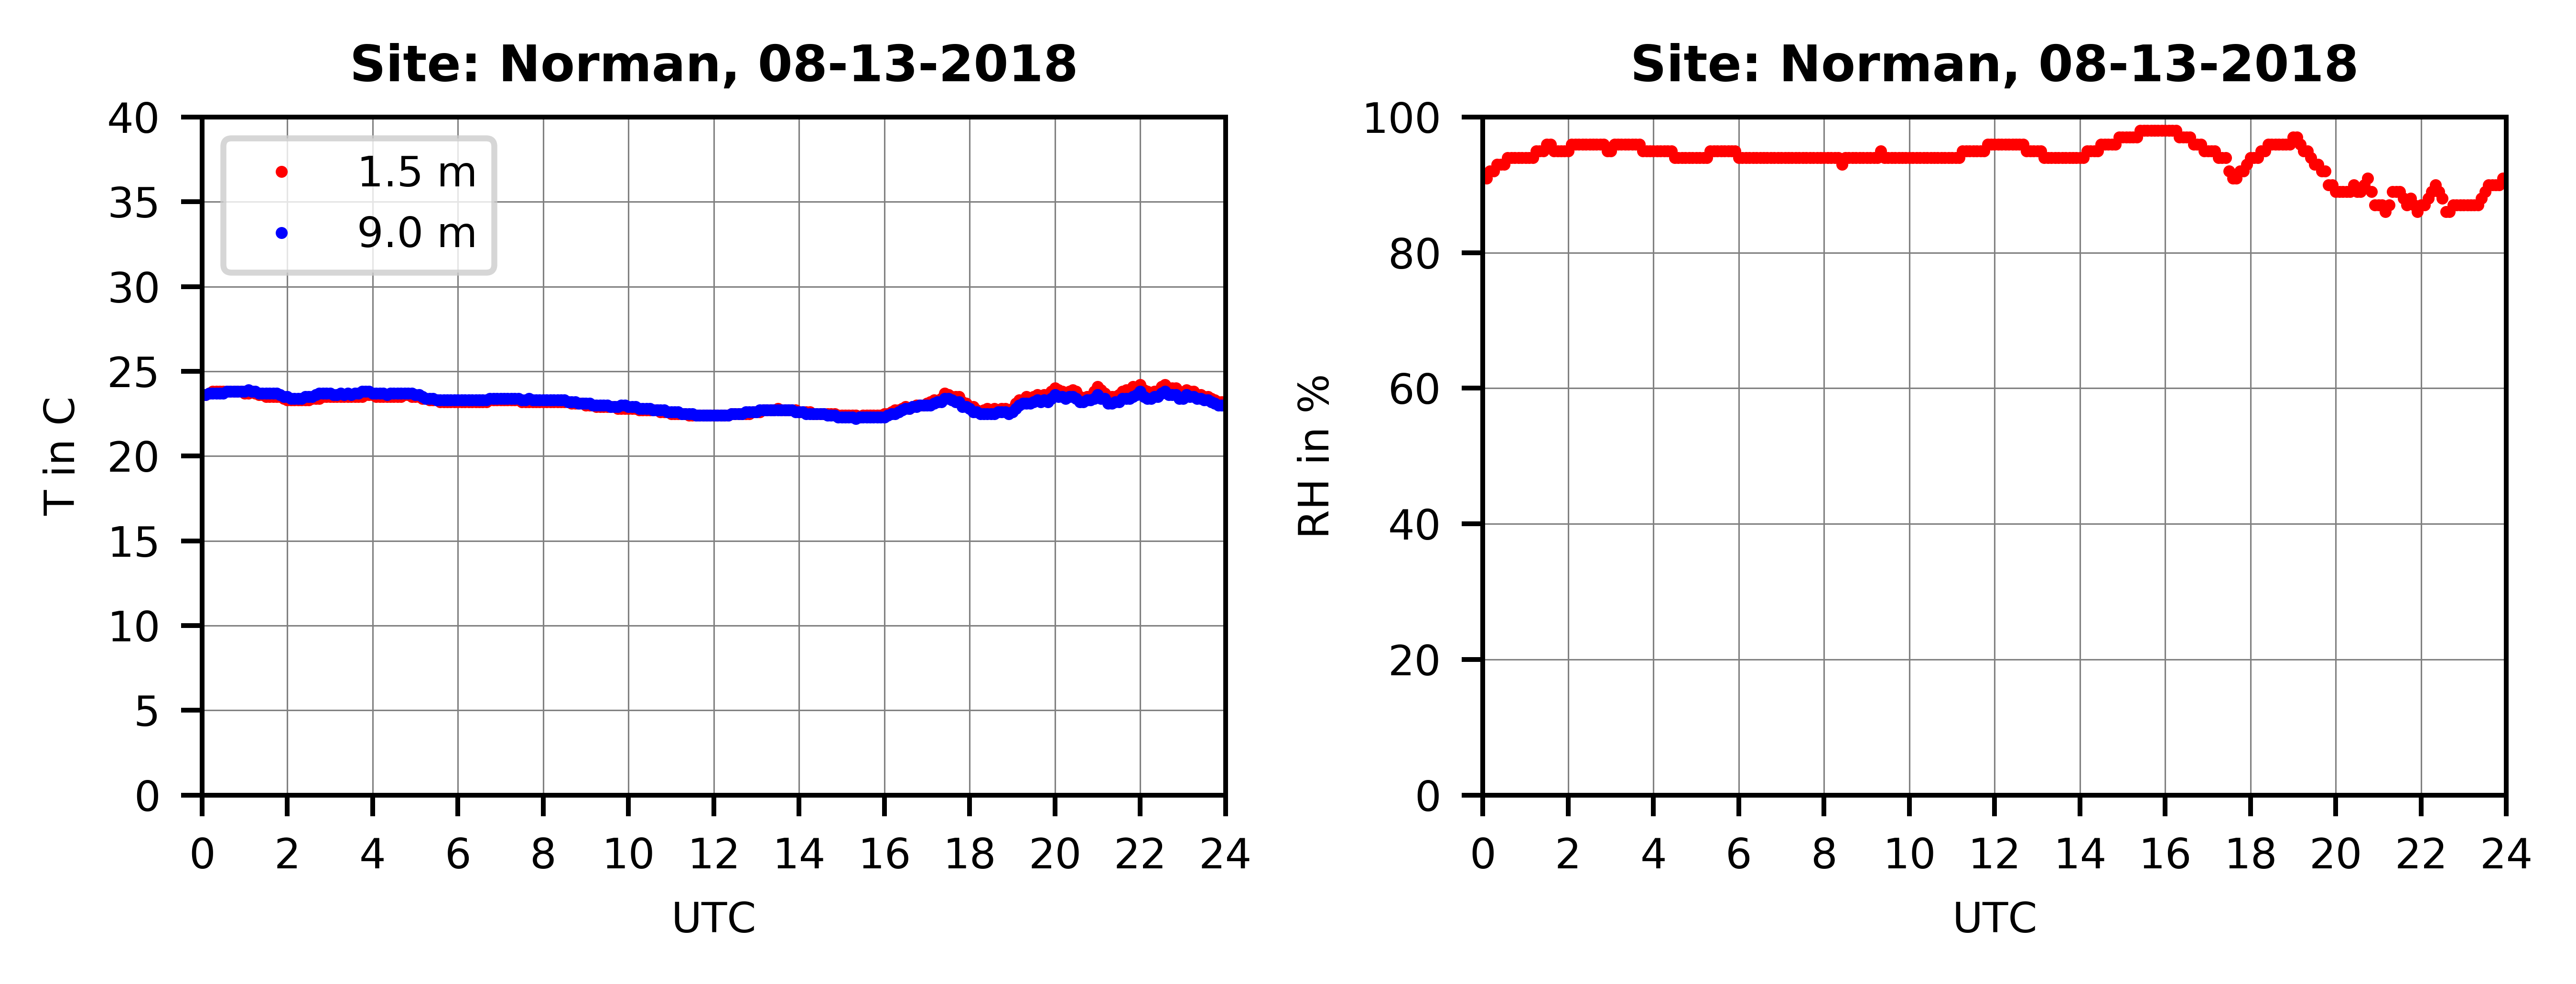

Importing  ./data/20180814nrmn.mts


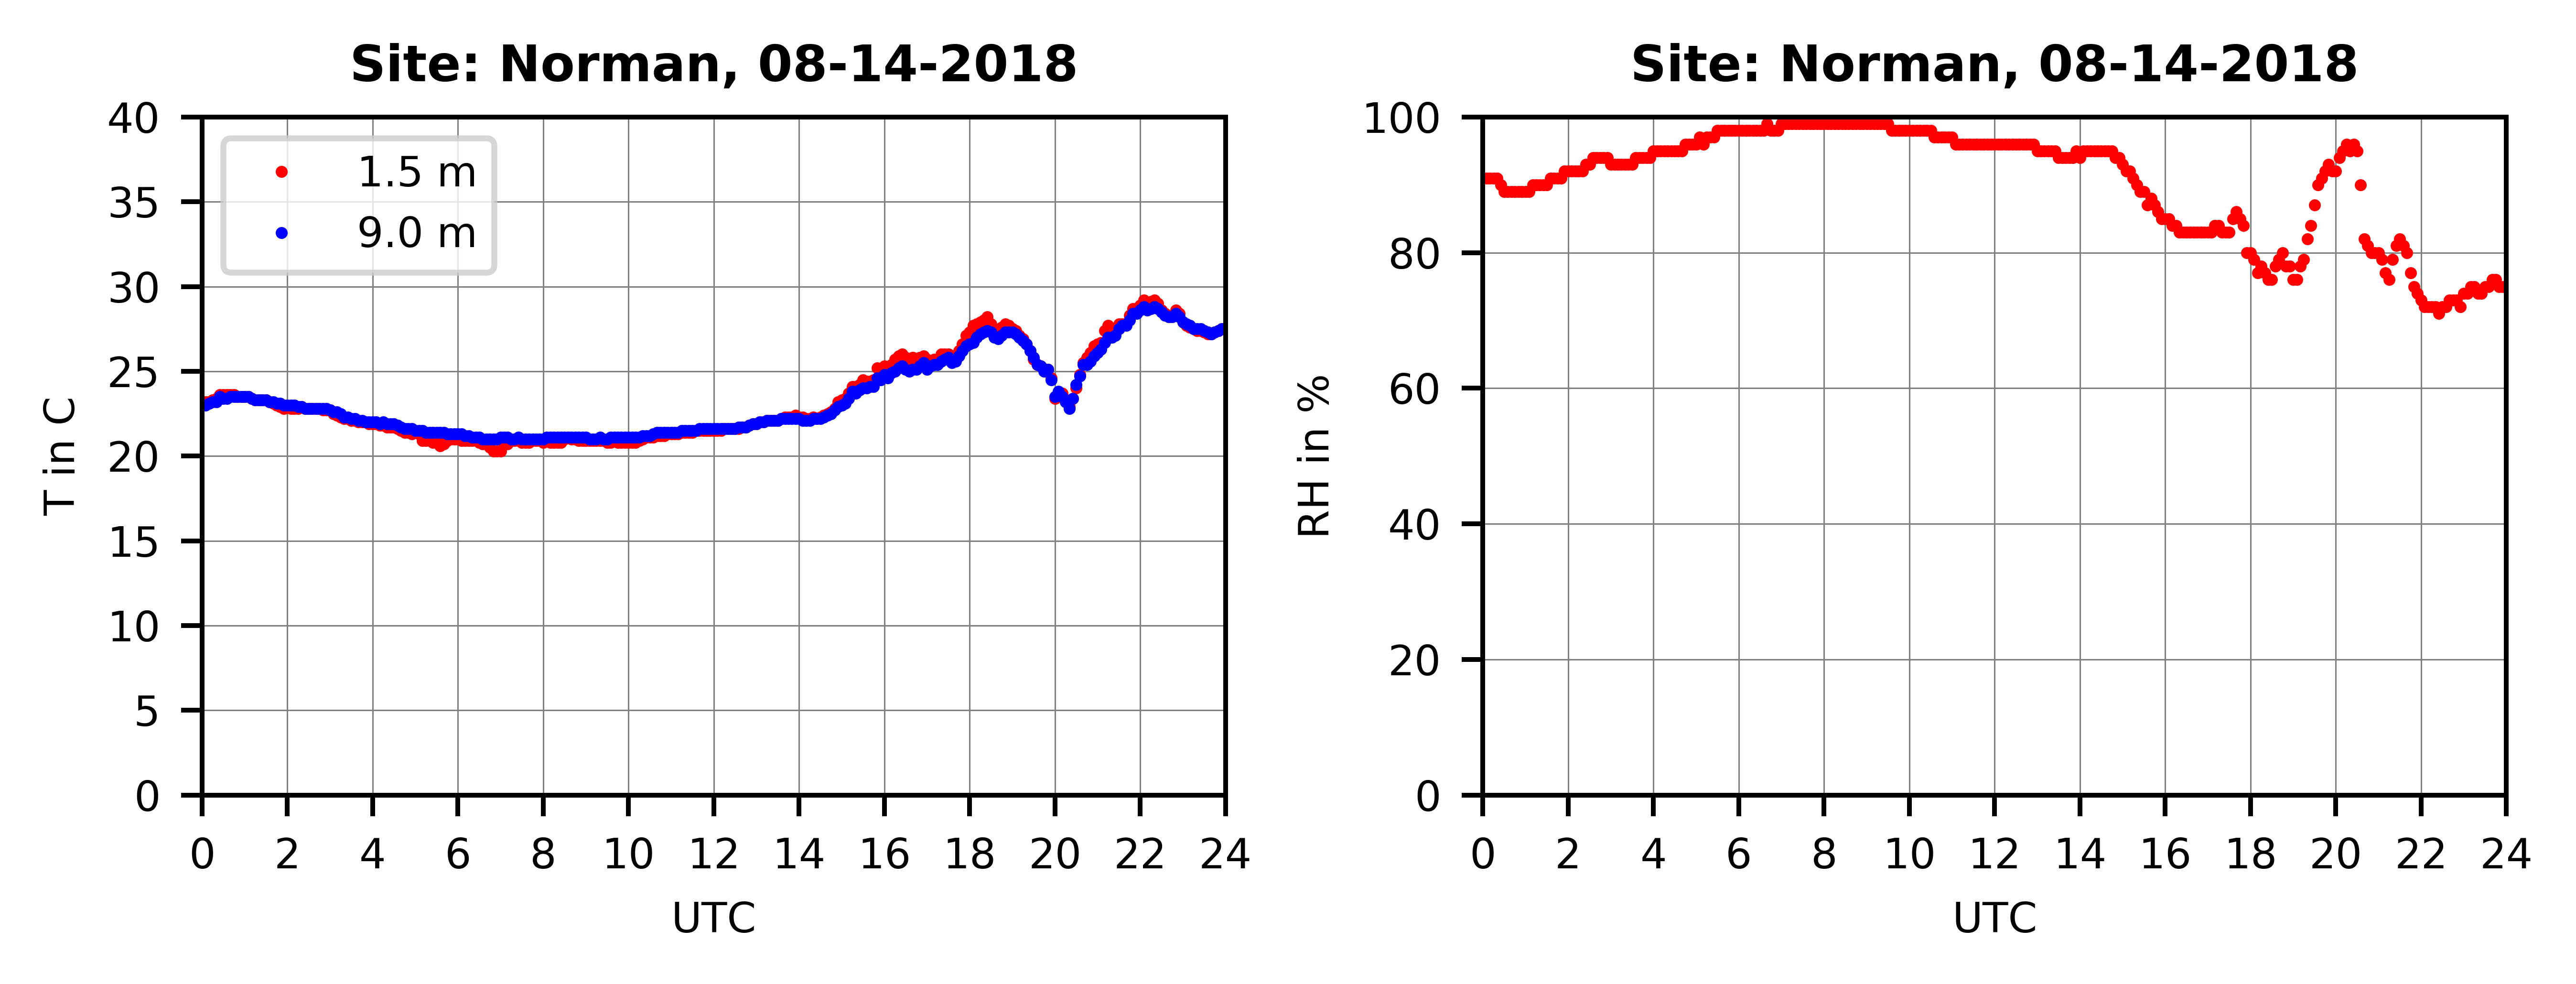

Importing  ./data/20180815nrmn.mts


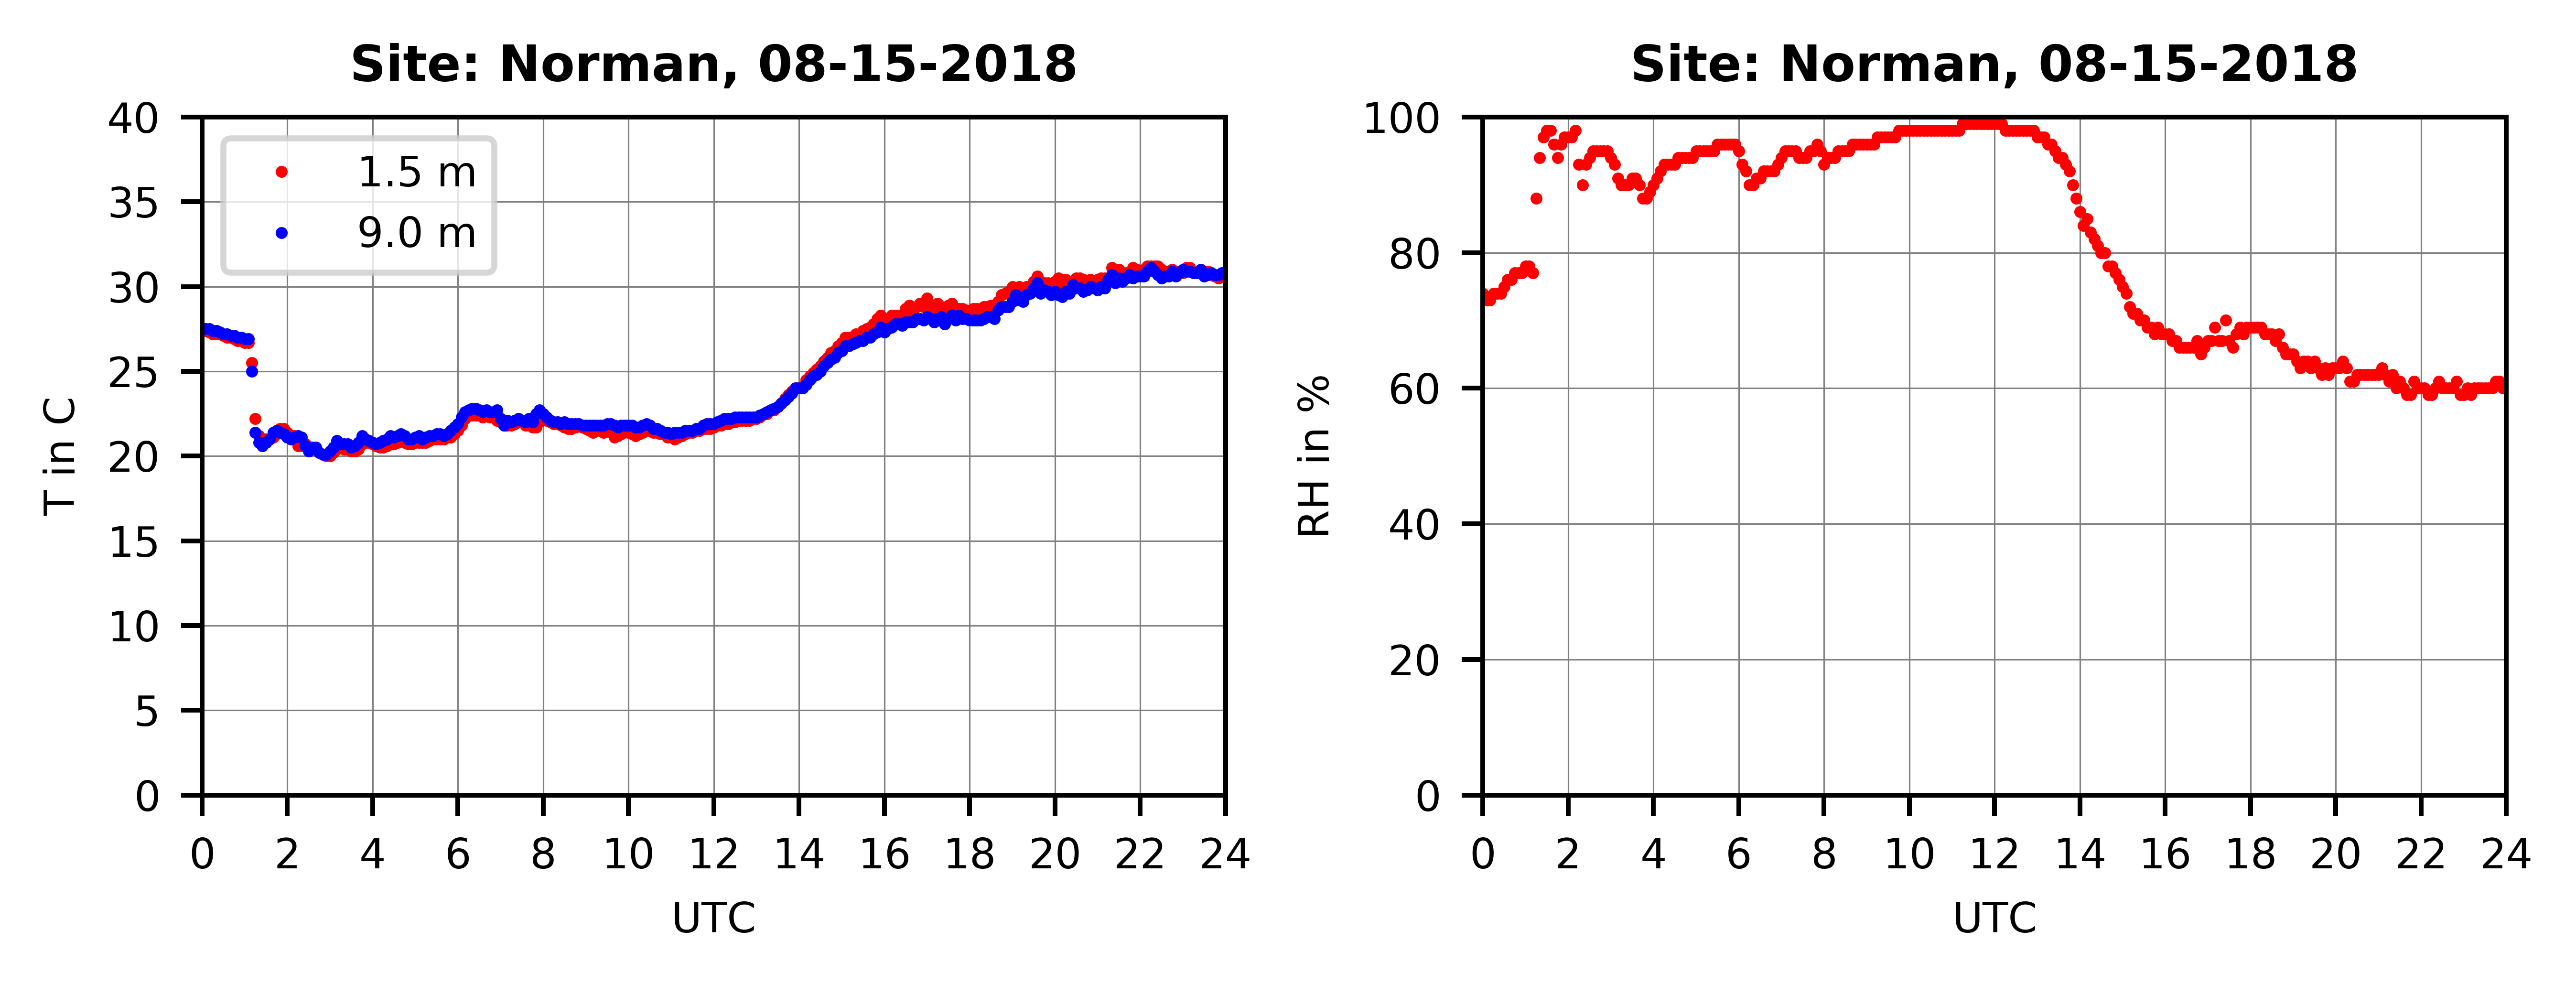

Importing  ./data/20180816nrmn.mts


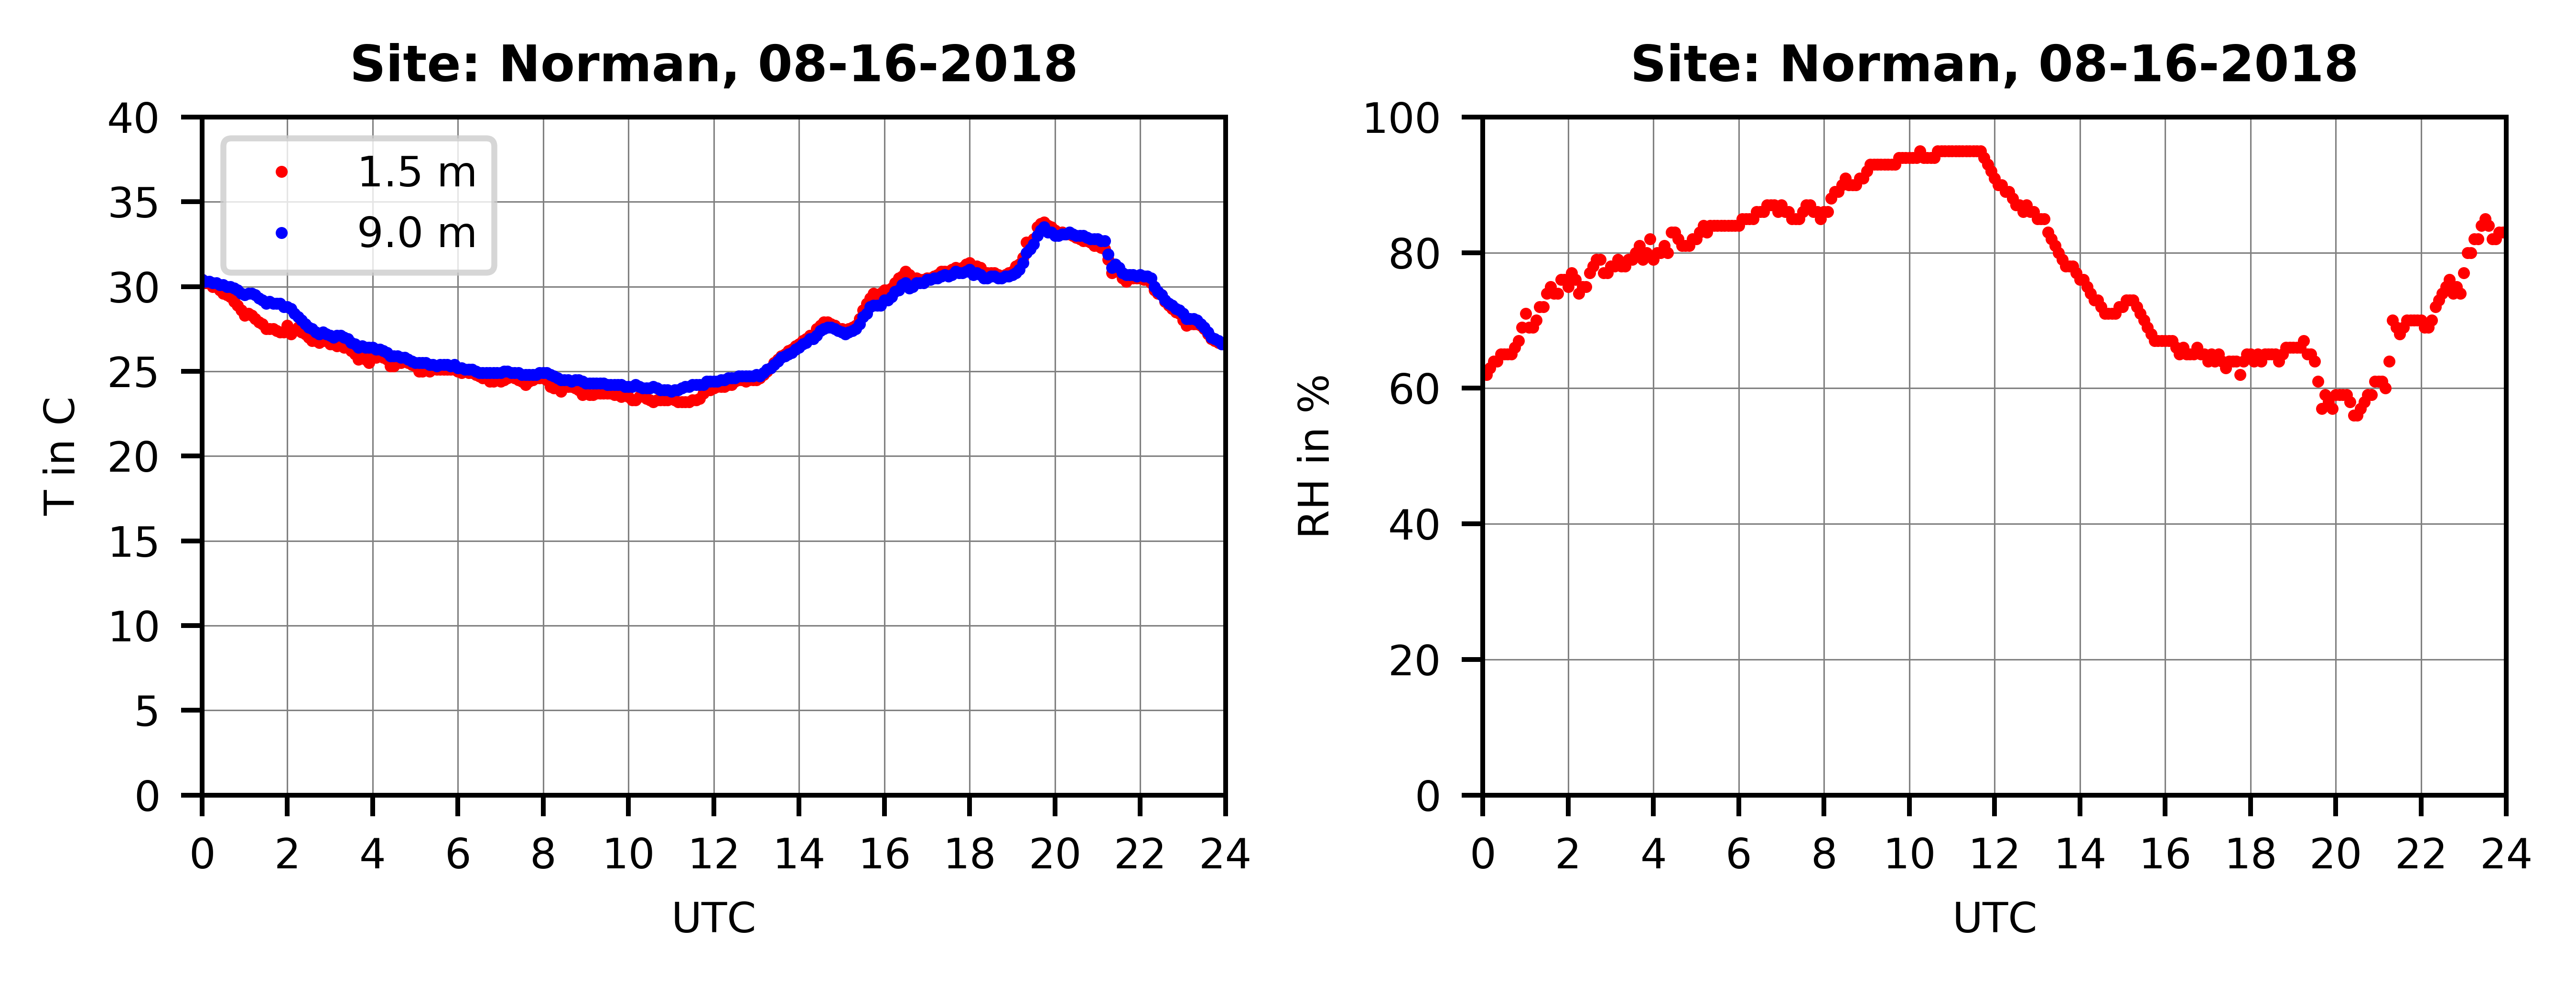

Importing  ./data/20180817nrmn.mts


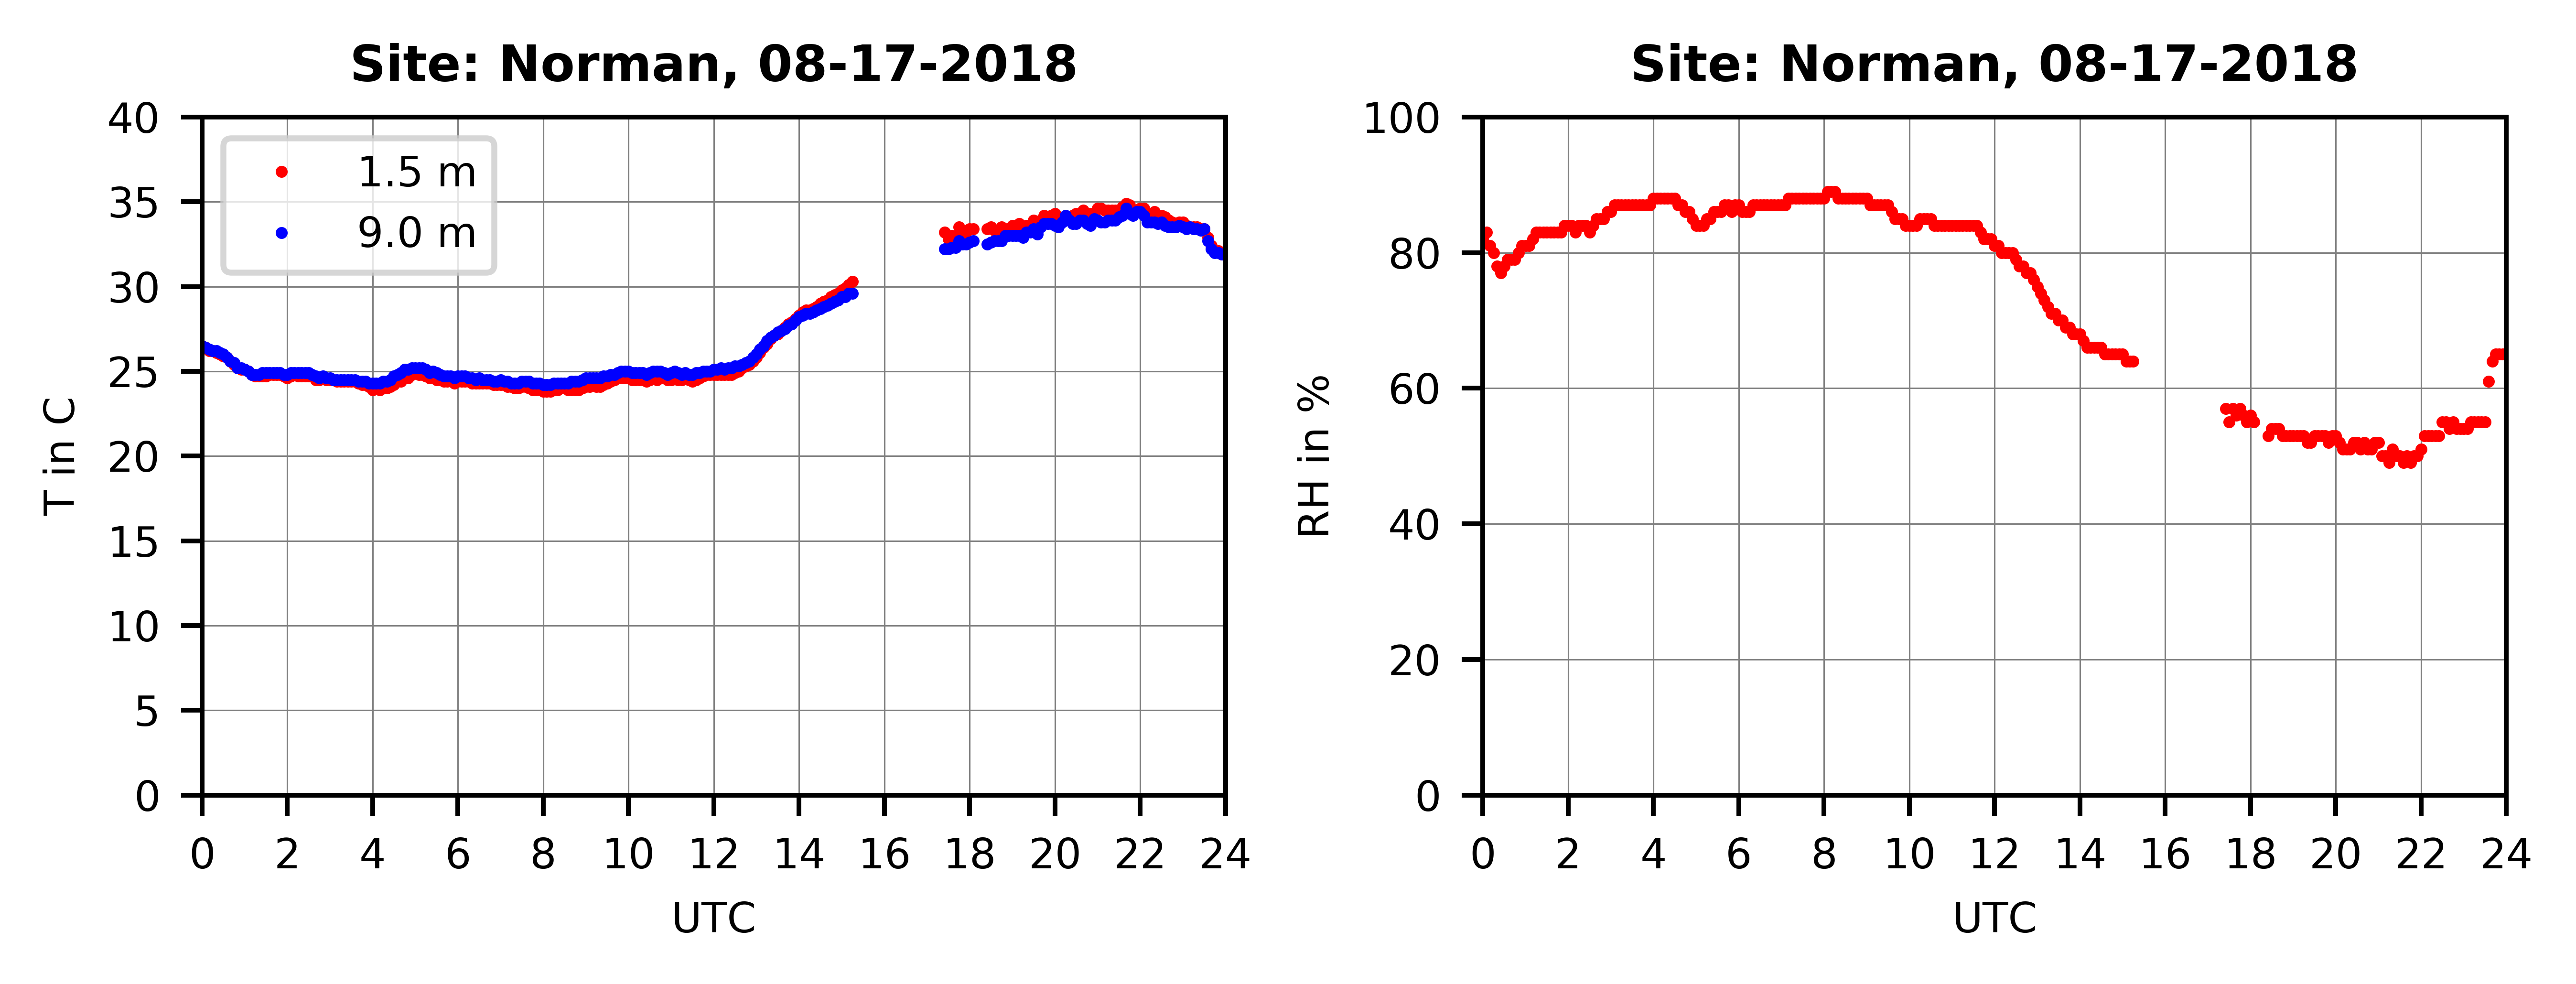

Importing  ./data/20180818nrmn.mts


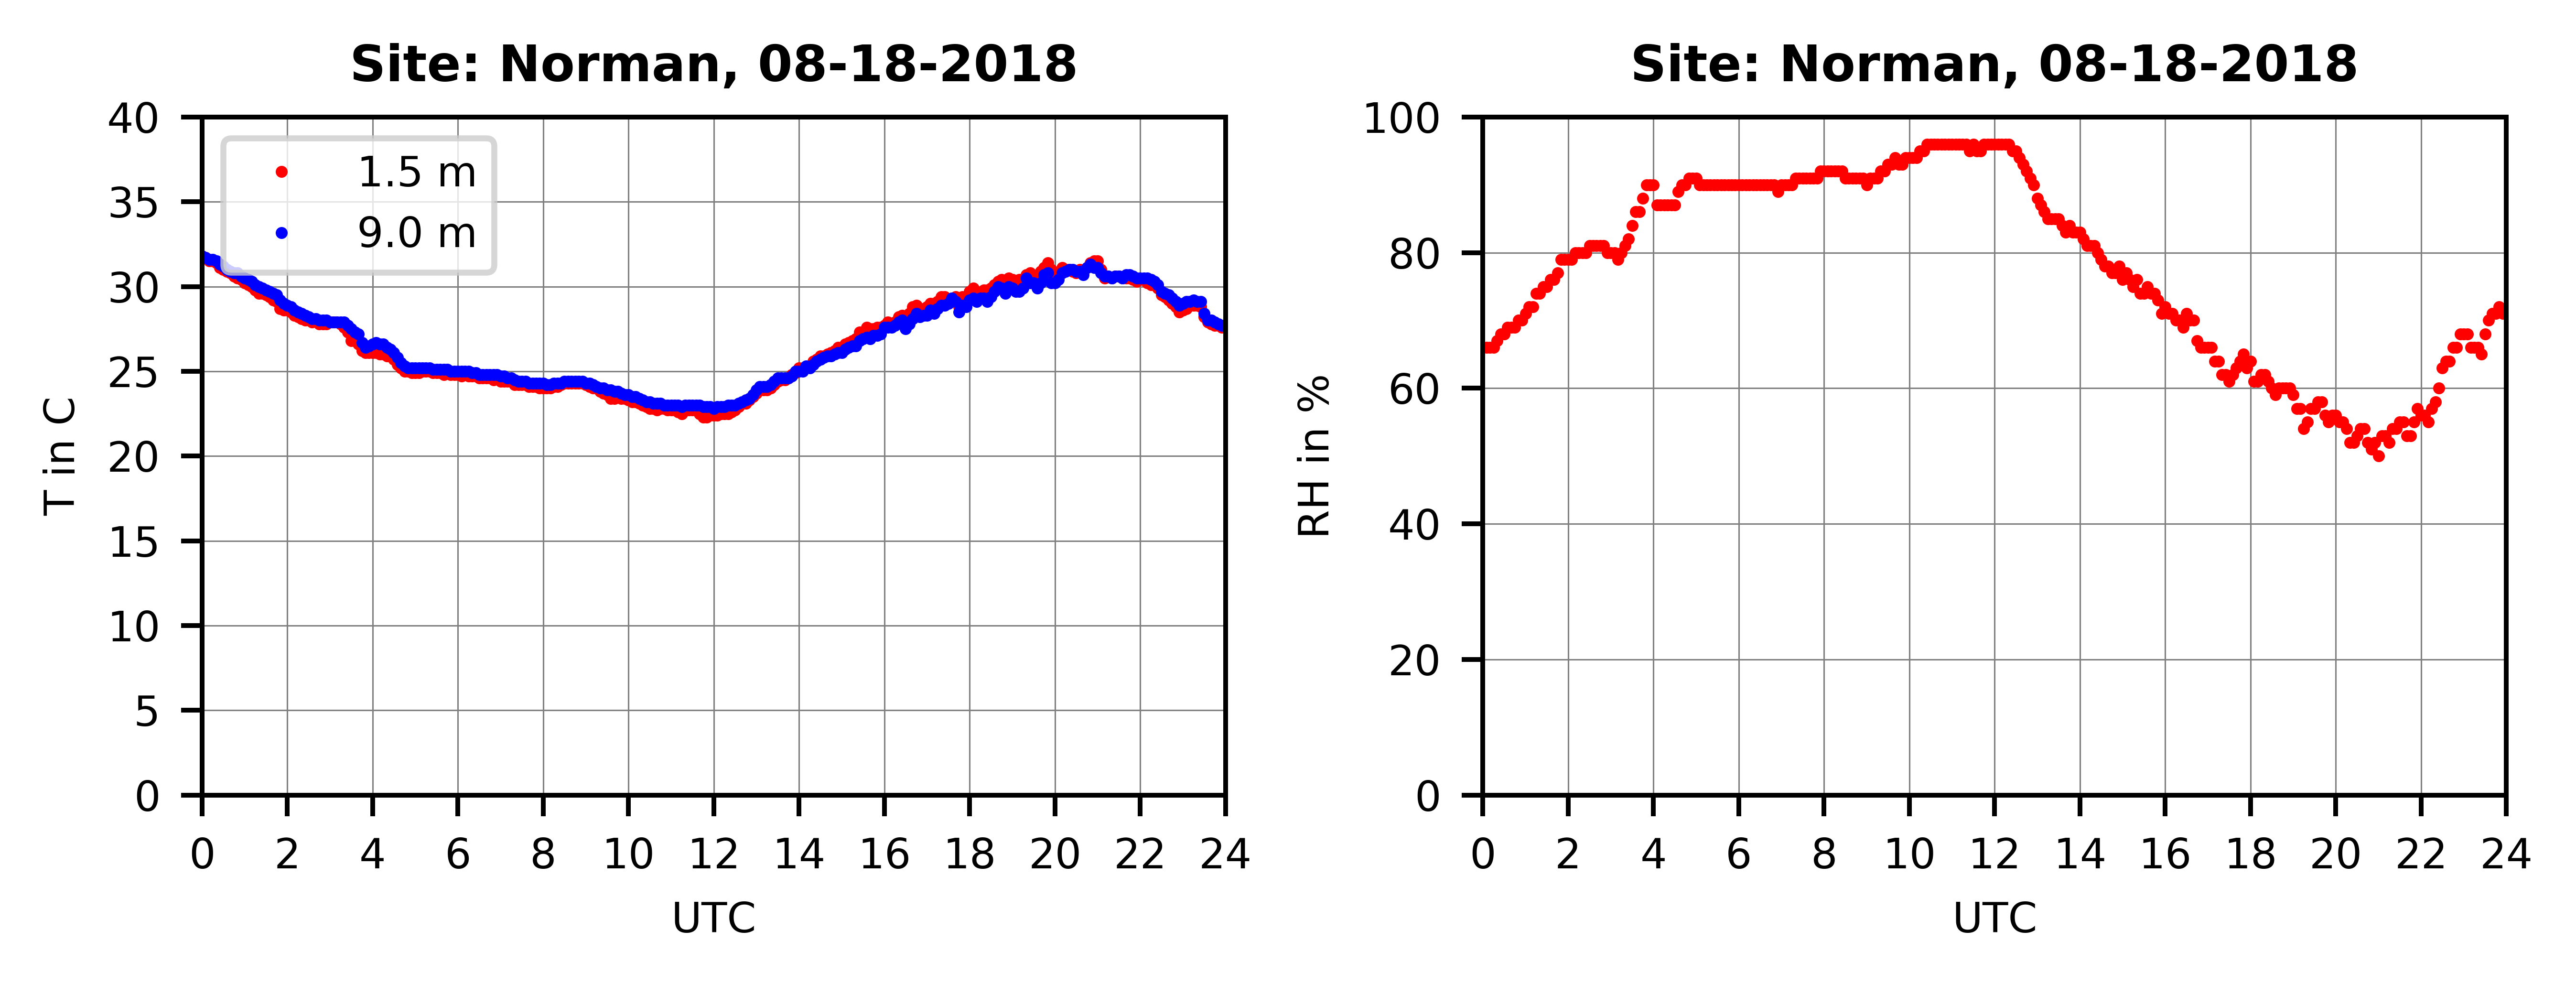

Importing  ./data/20180819nrmn.mts


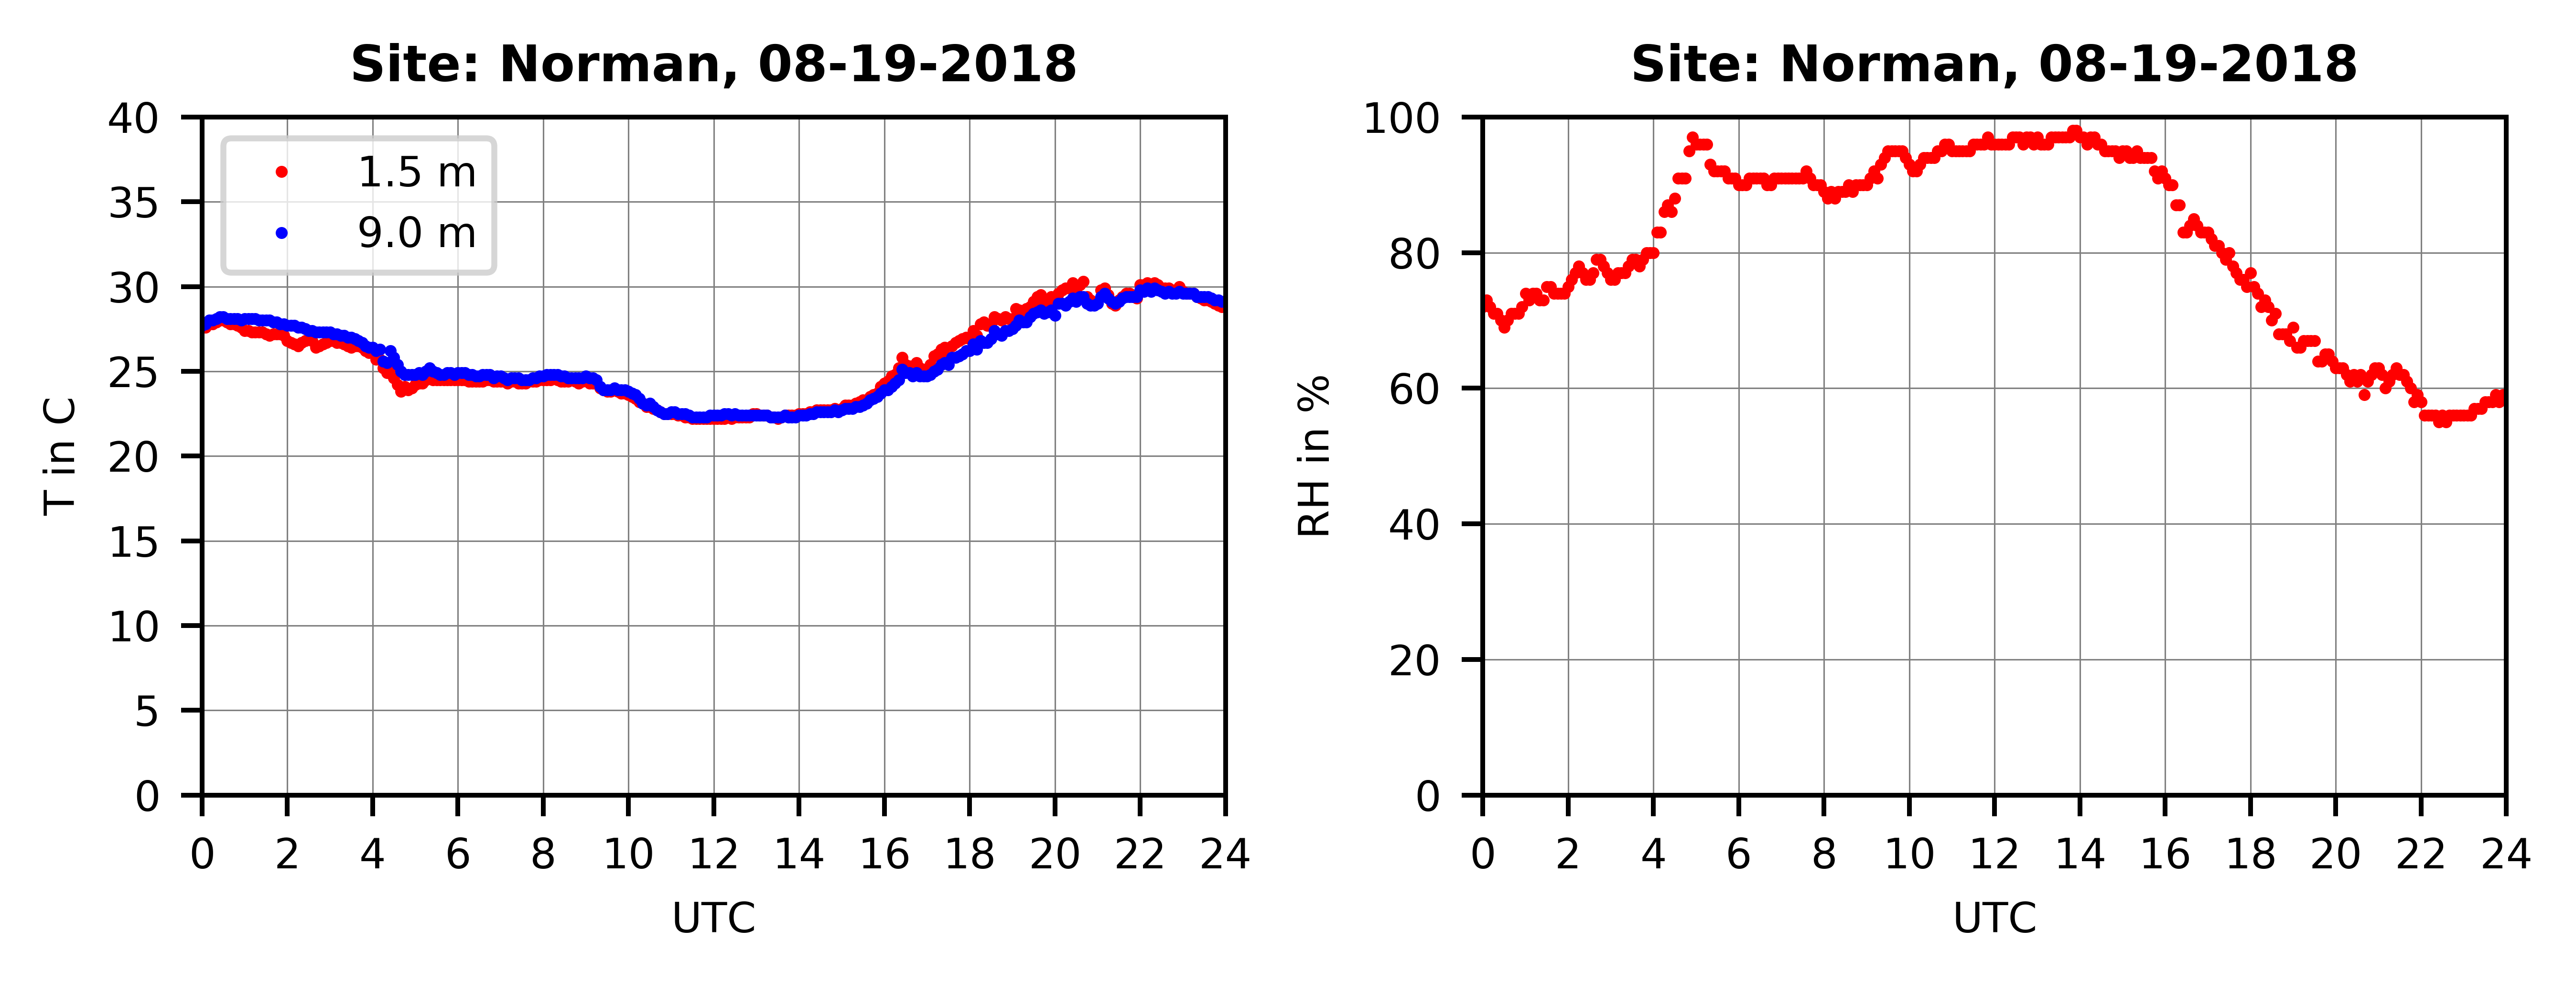

Importing  ./data/20180820nrmn.mts


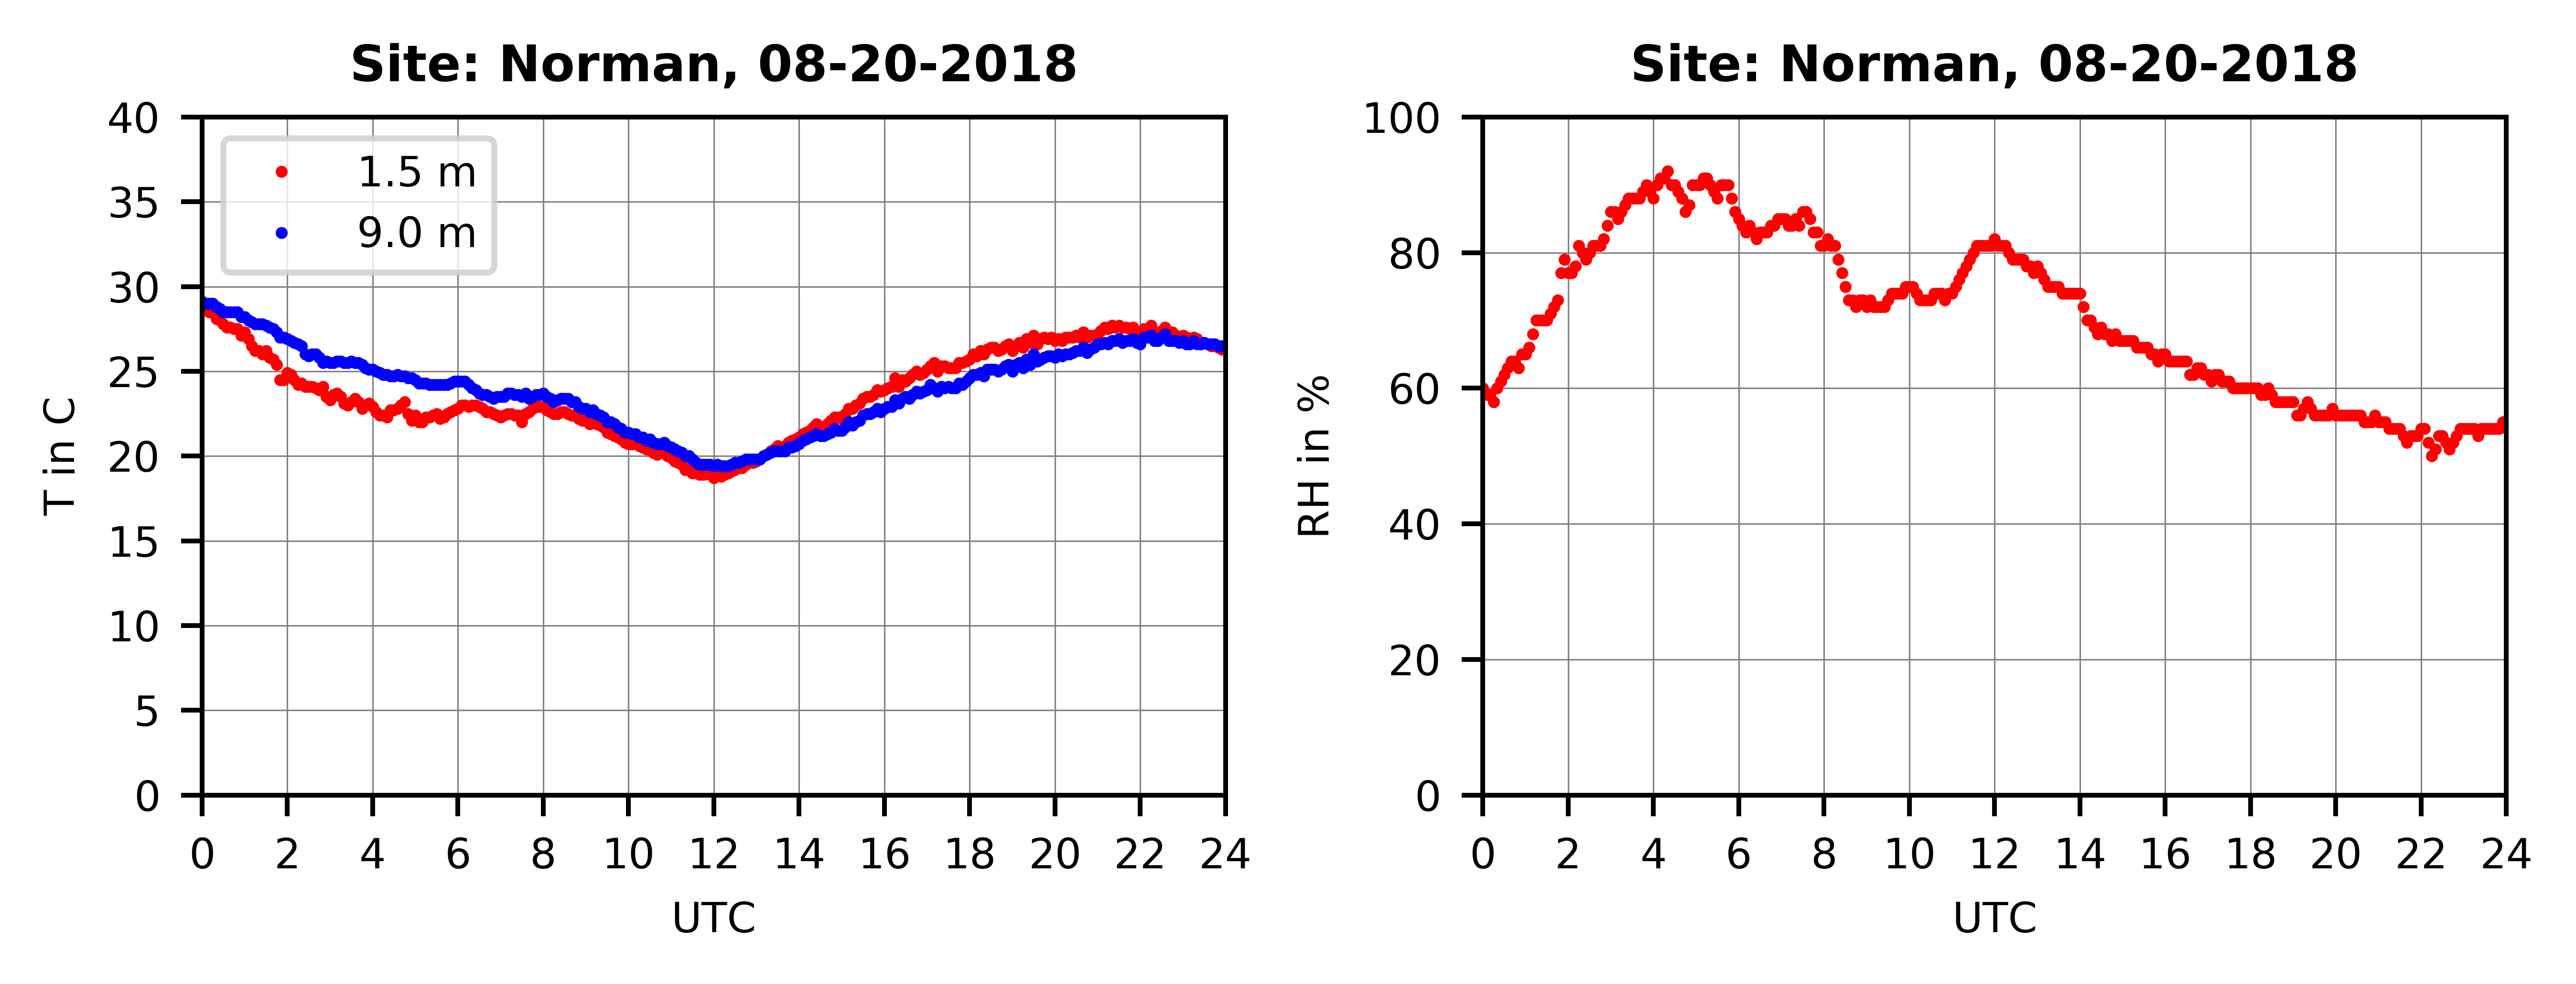

Importing  ./data/20180821nrmn.mts


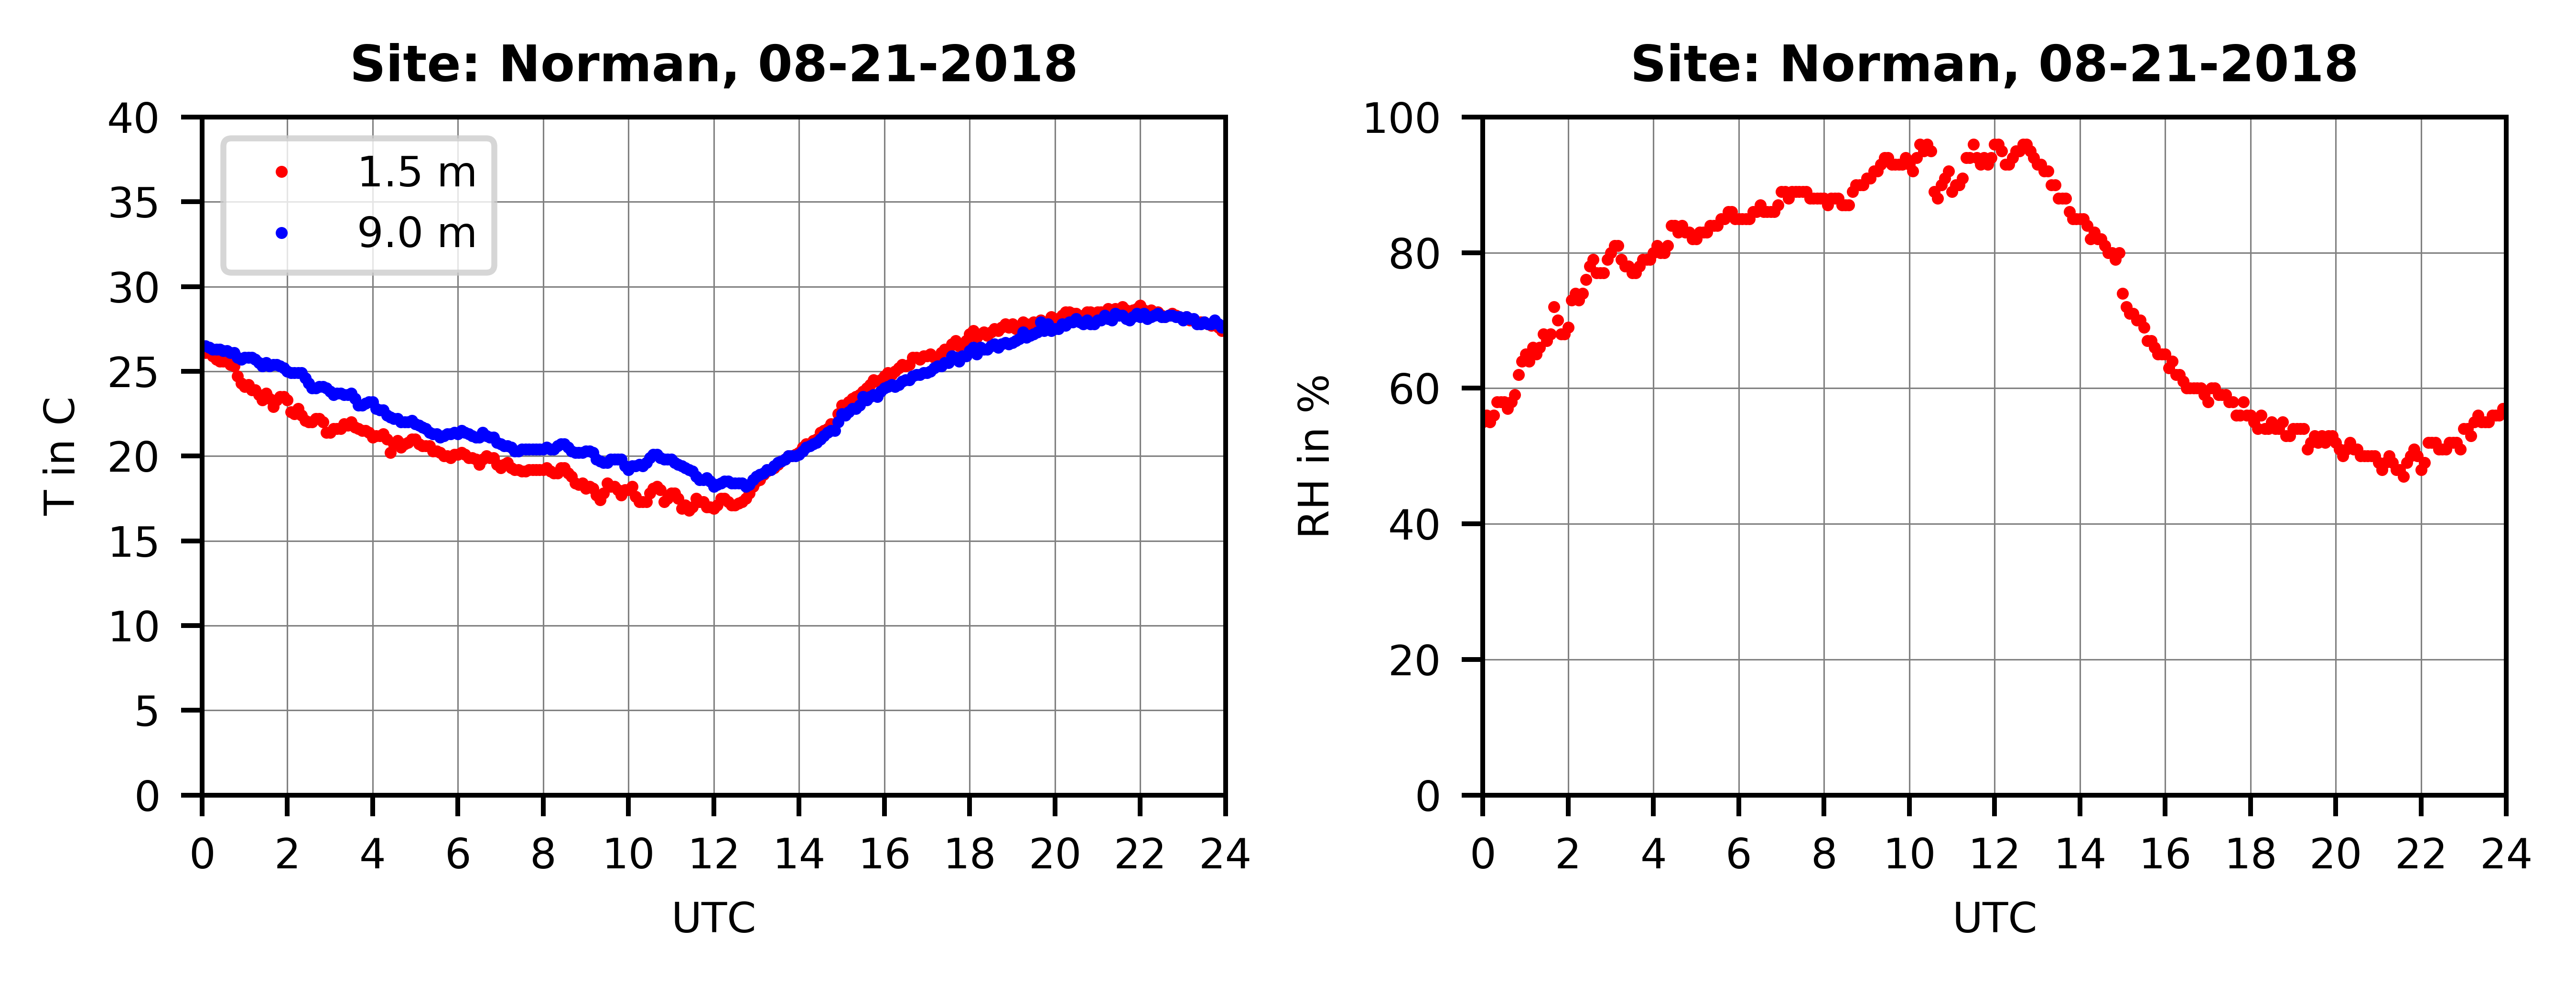

Importing  ./data/20180822nrmn.mts


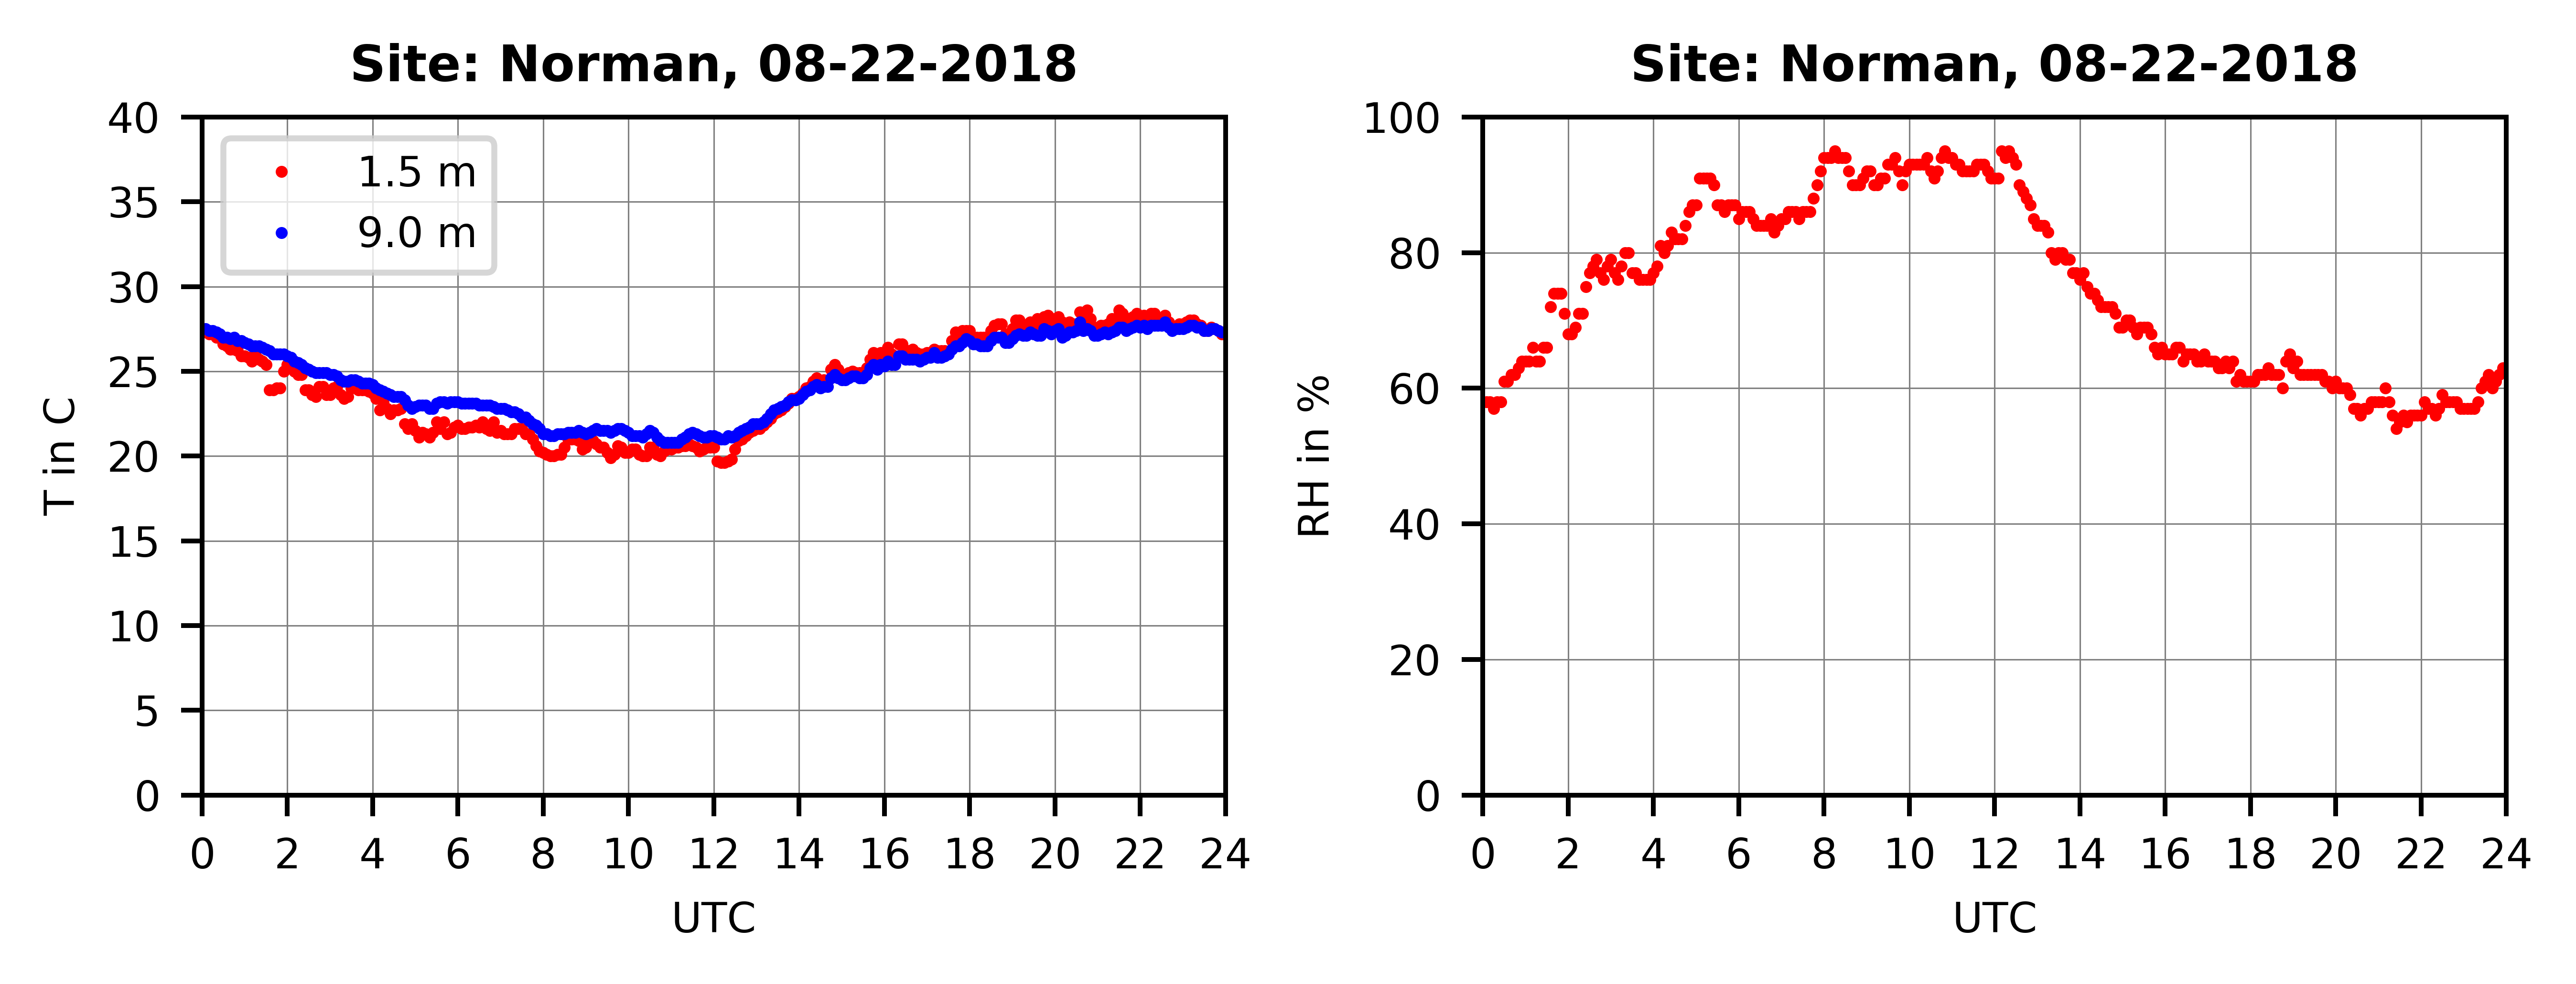

Importing  ./data/20180823nrmn.mts


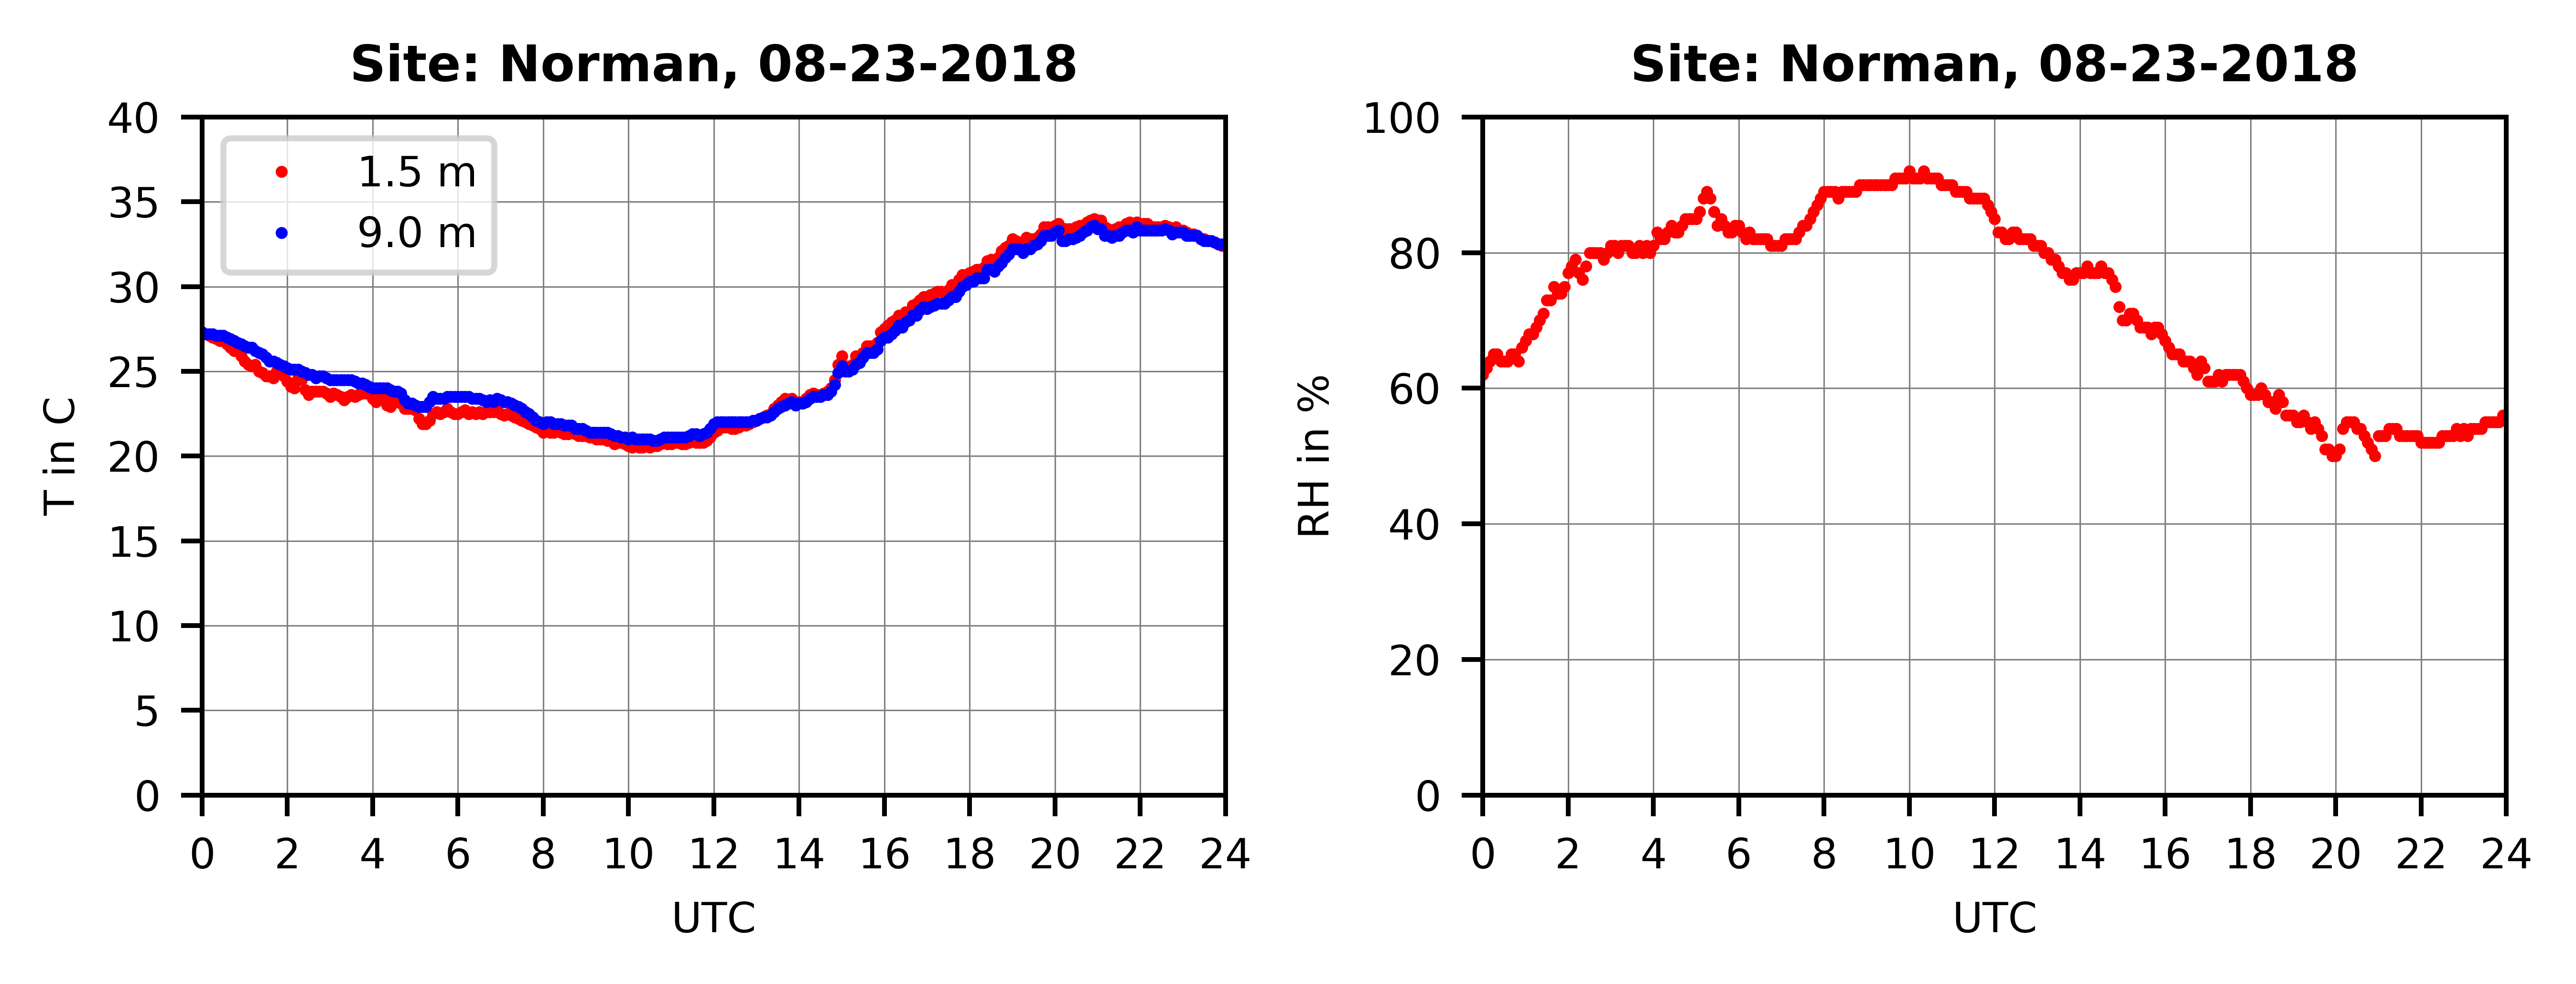

Importing  ./data/20180824nrmn.mts


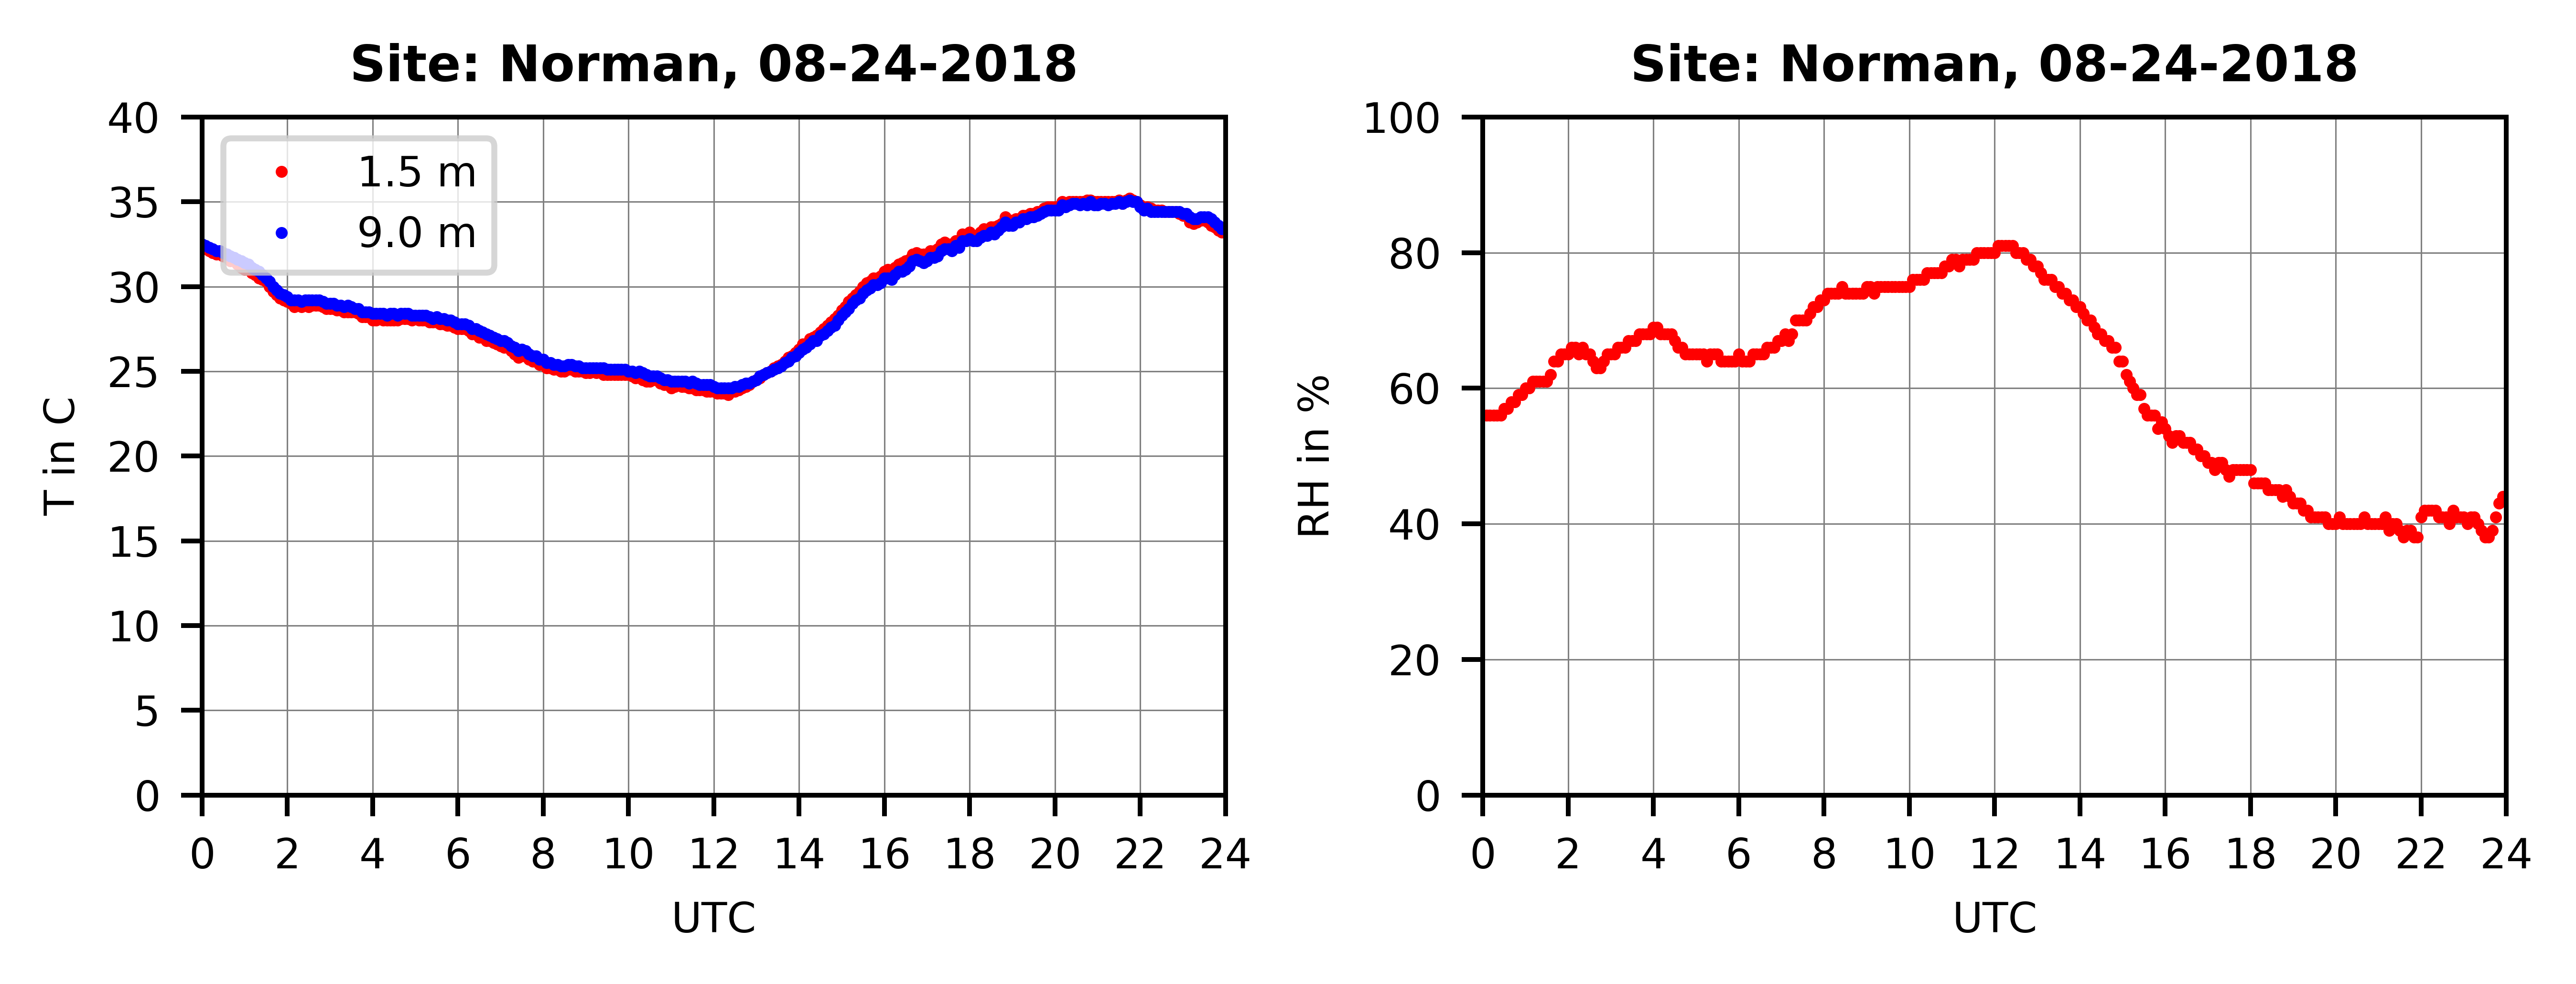

Importing  ./data/20180825nrmn.mts


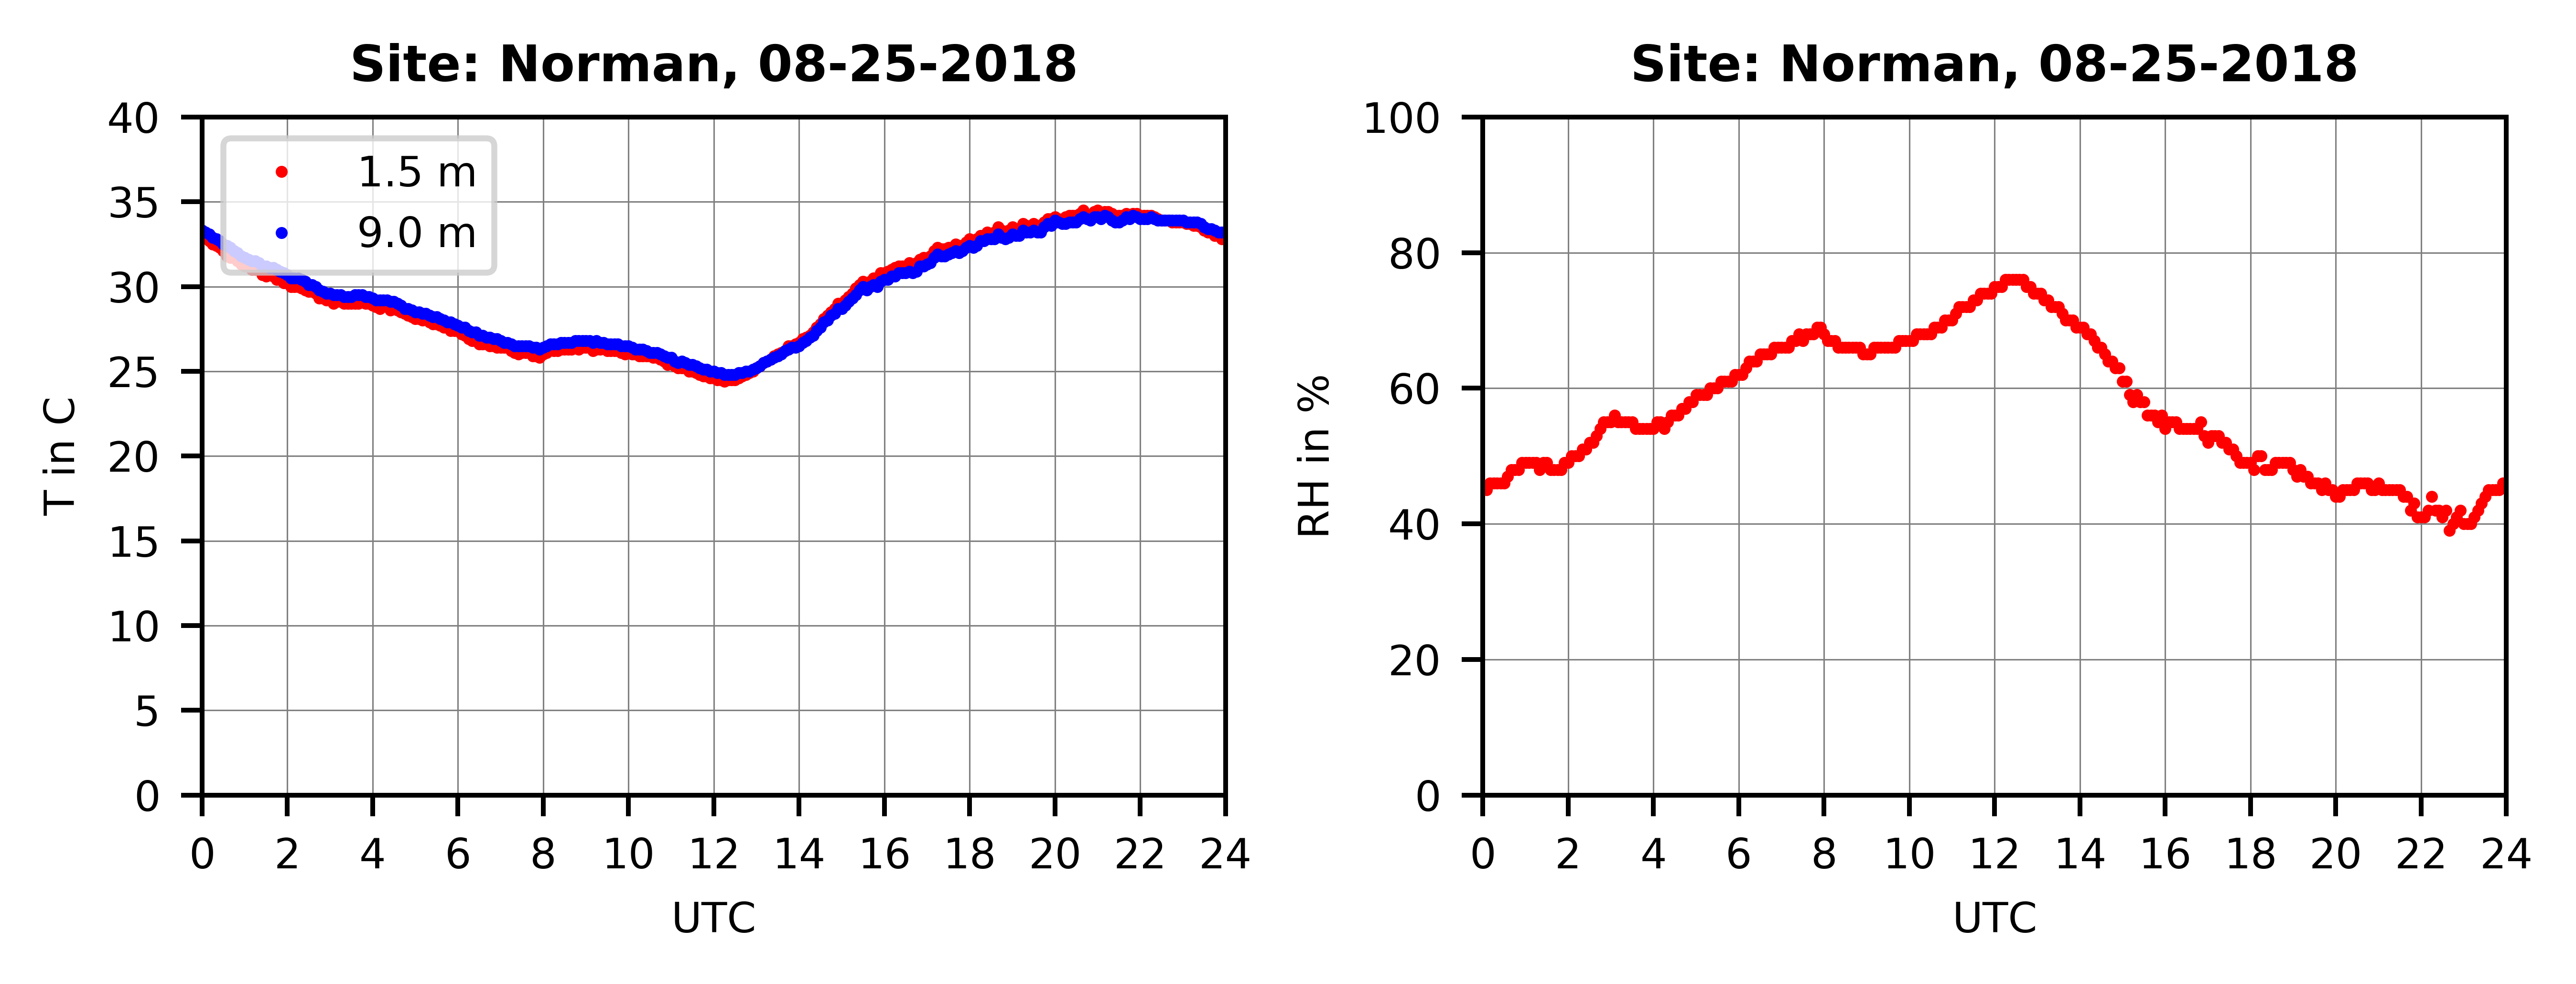

Importing  ./data/20180826nrmn.mts


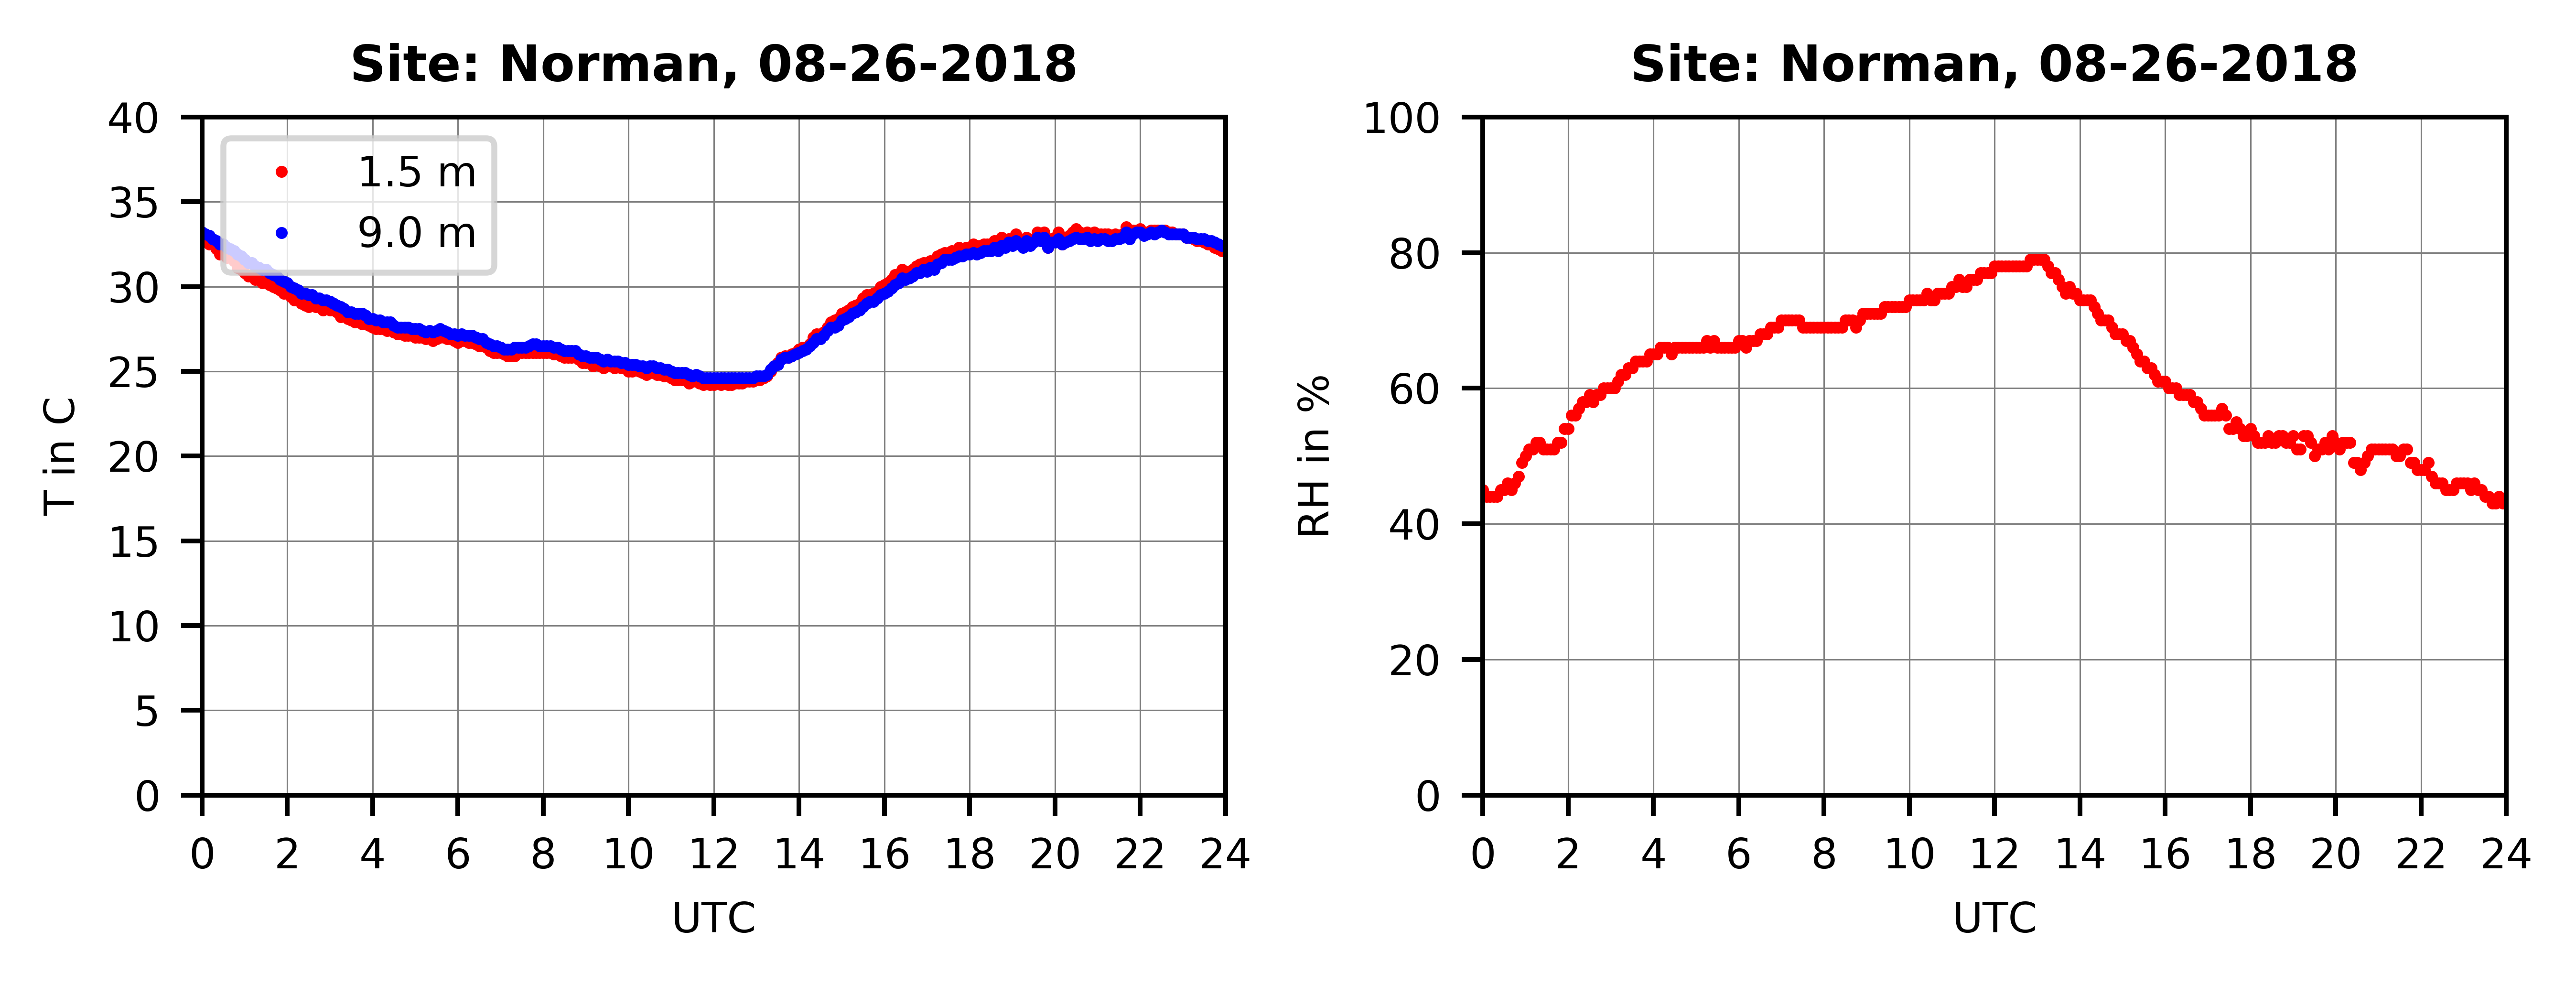

Importing  ./data/20180827nrmn.mts


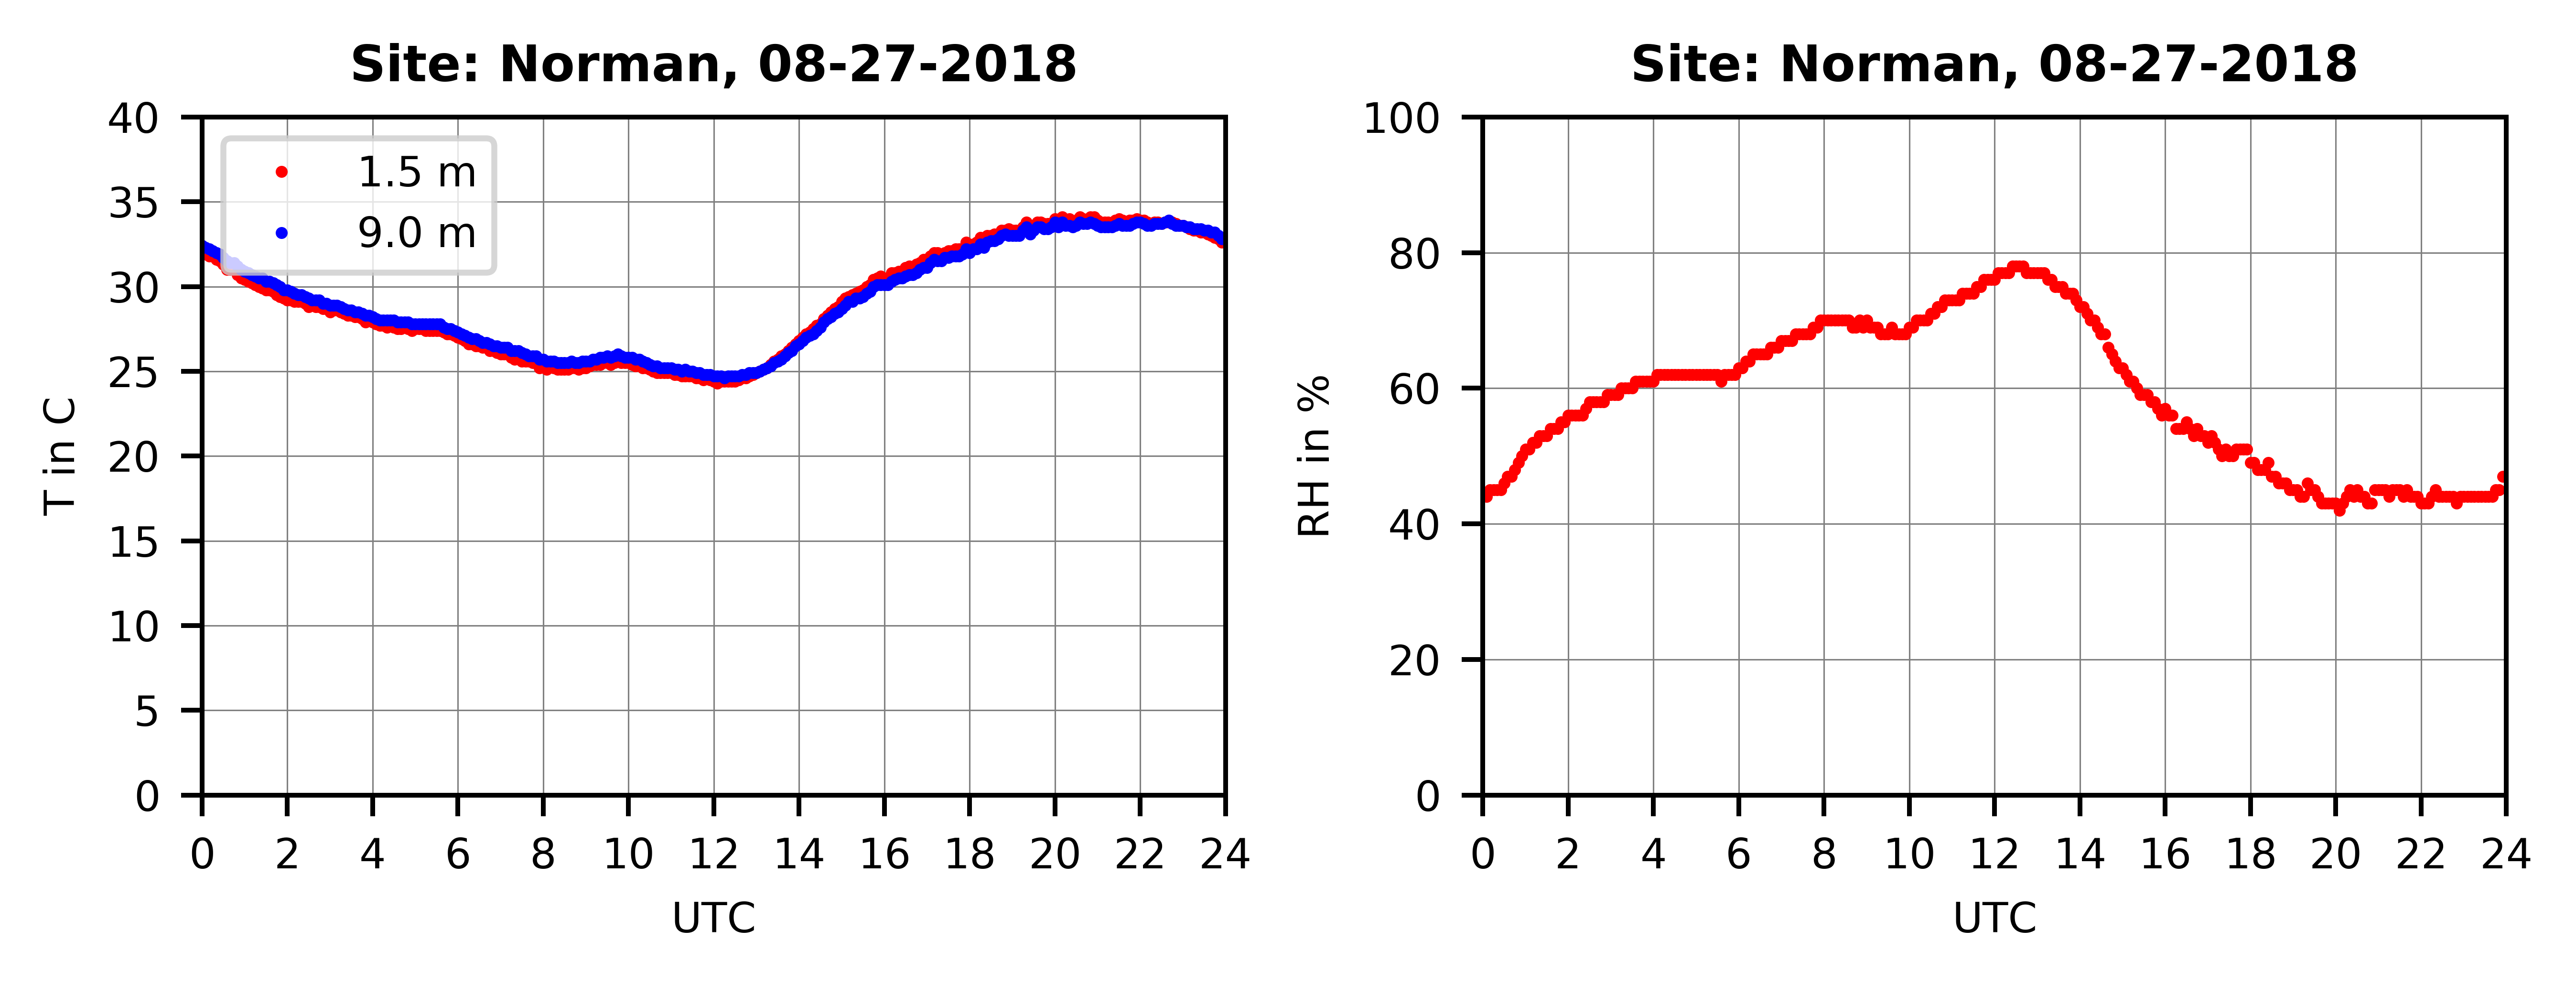

Importing  ./data/20180828nrmn.mts


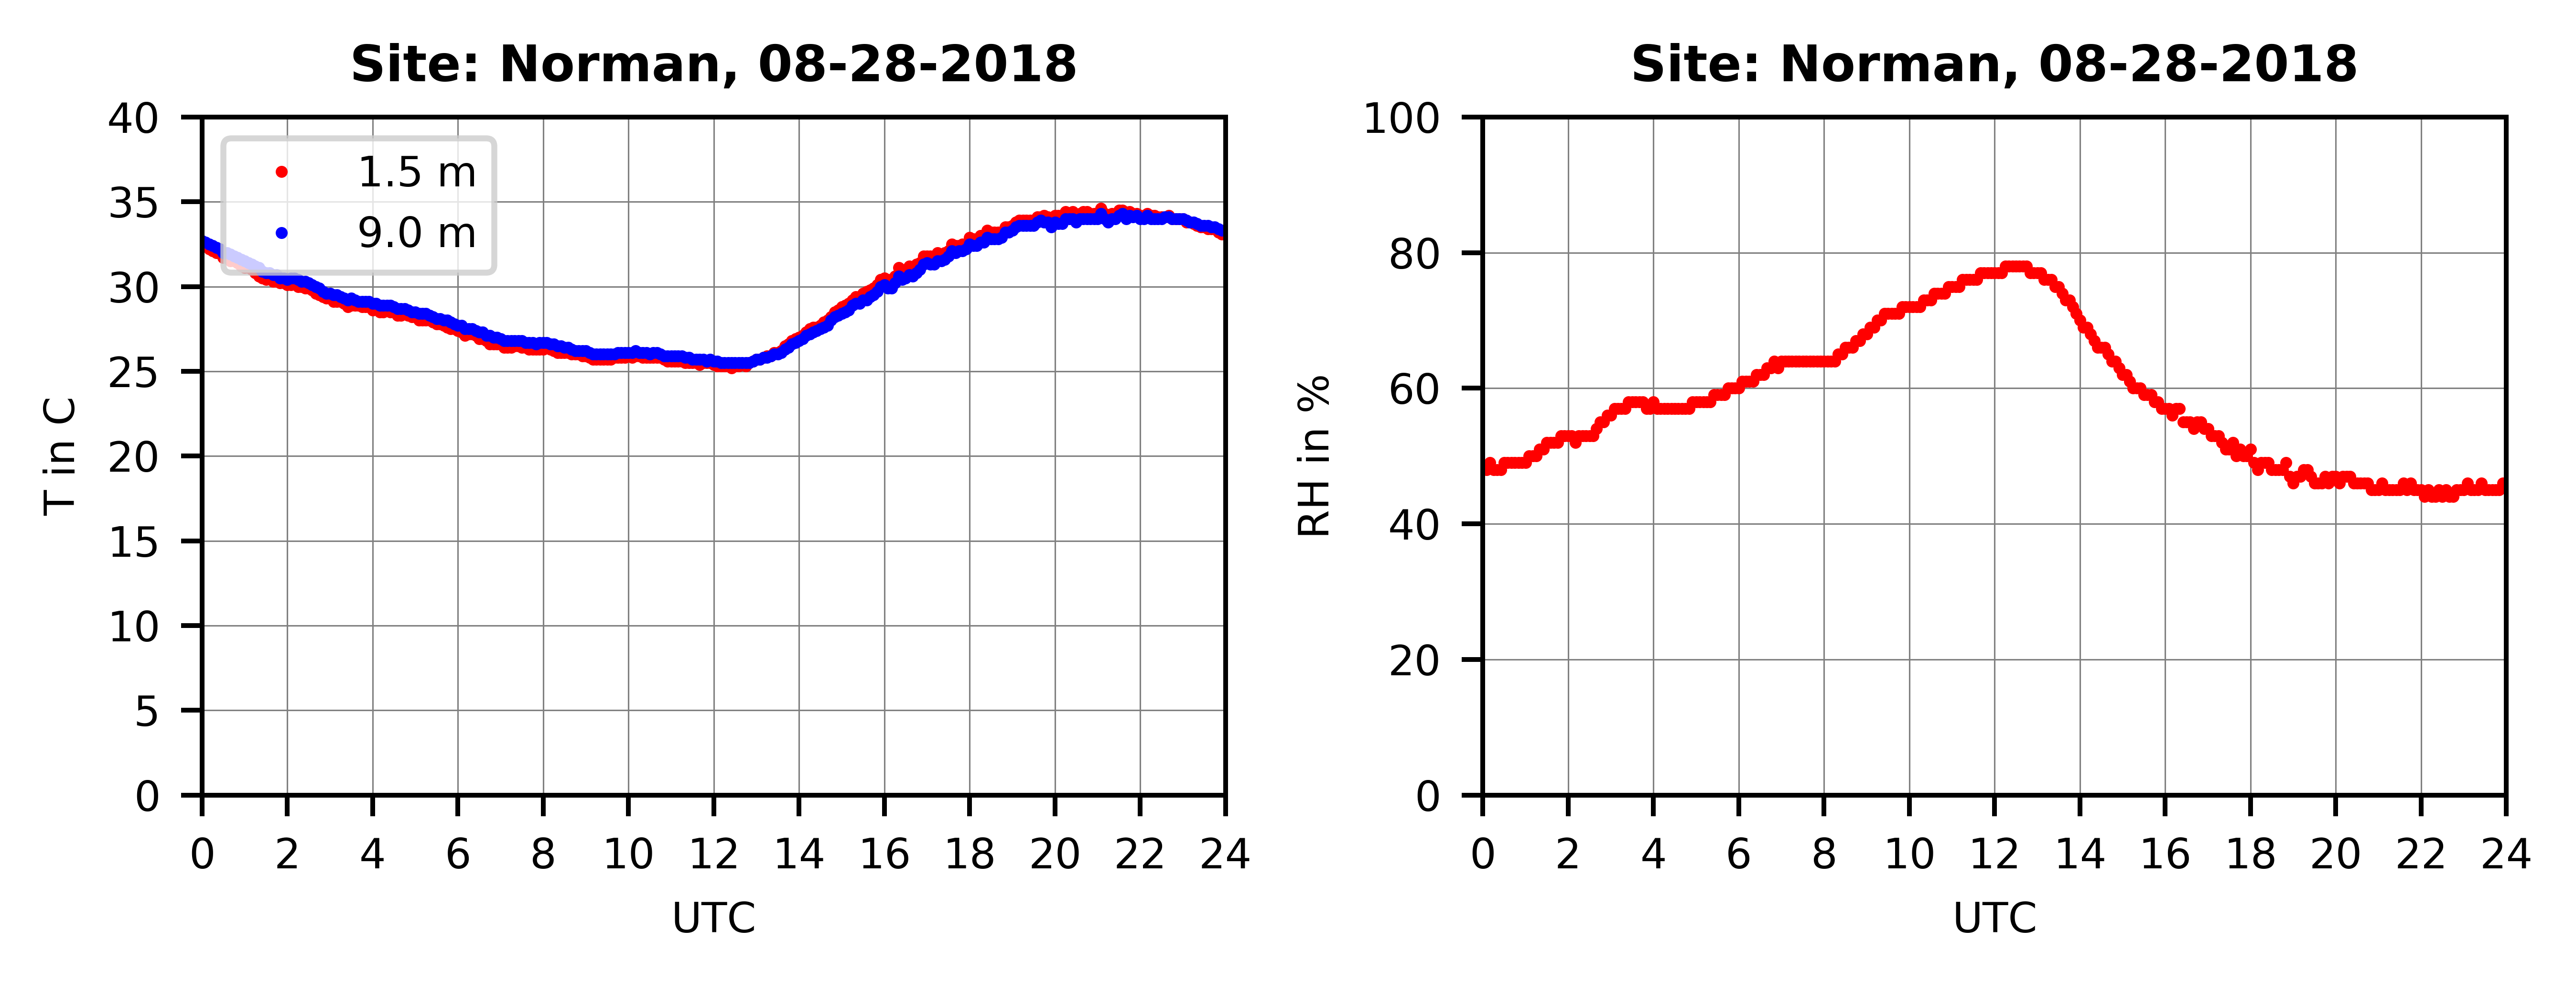

Importing  ./data/20180829nrmn.mts


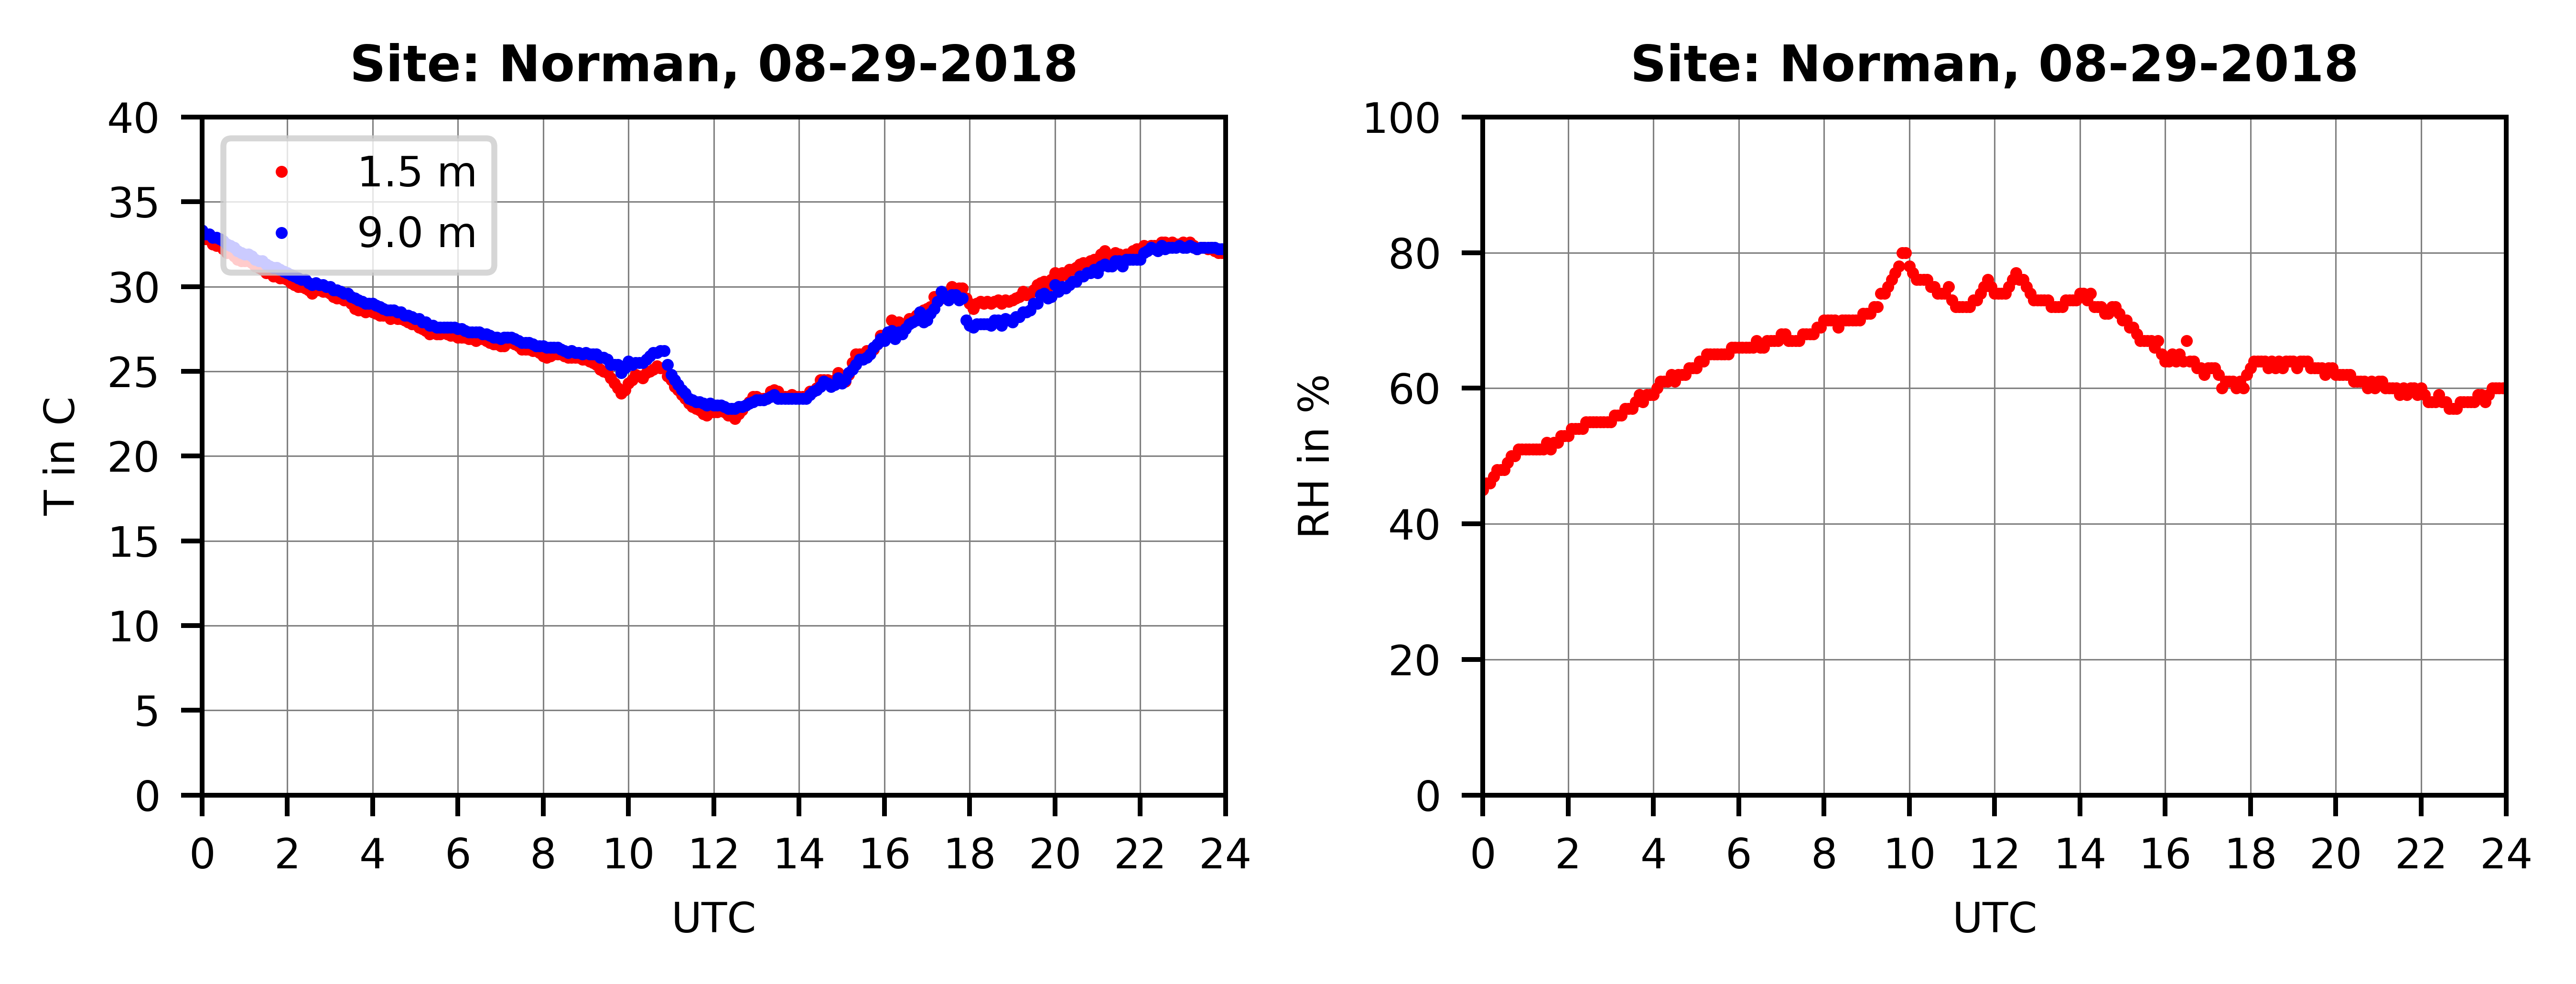

Importing  ./data/20180830nrmn.mts


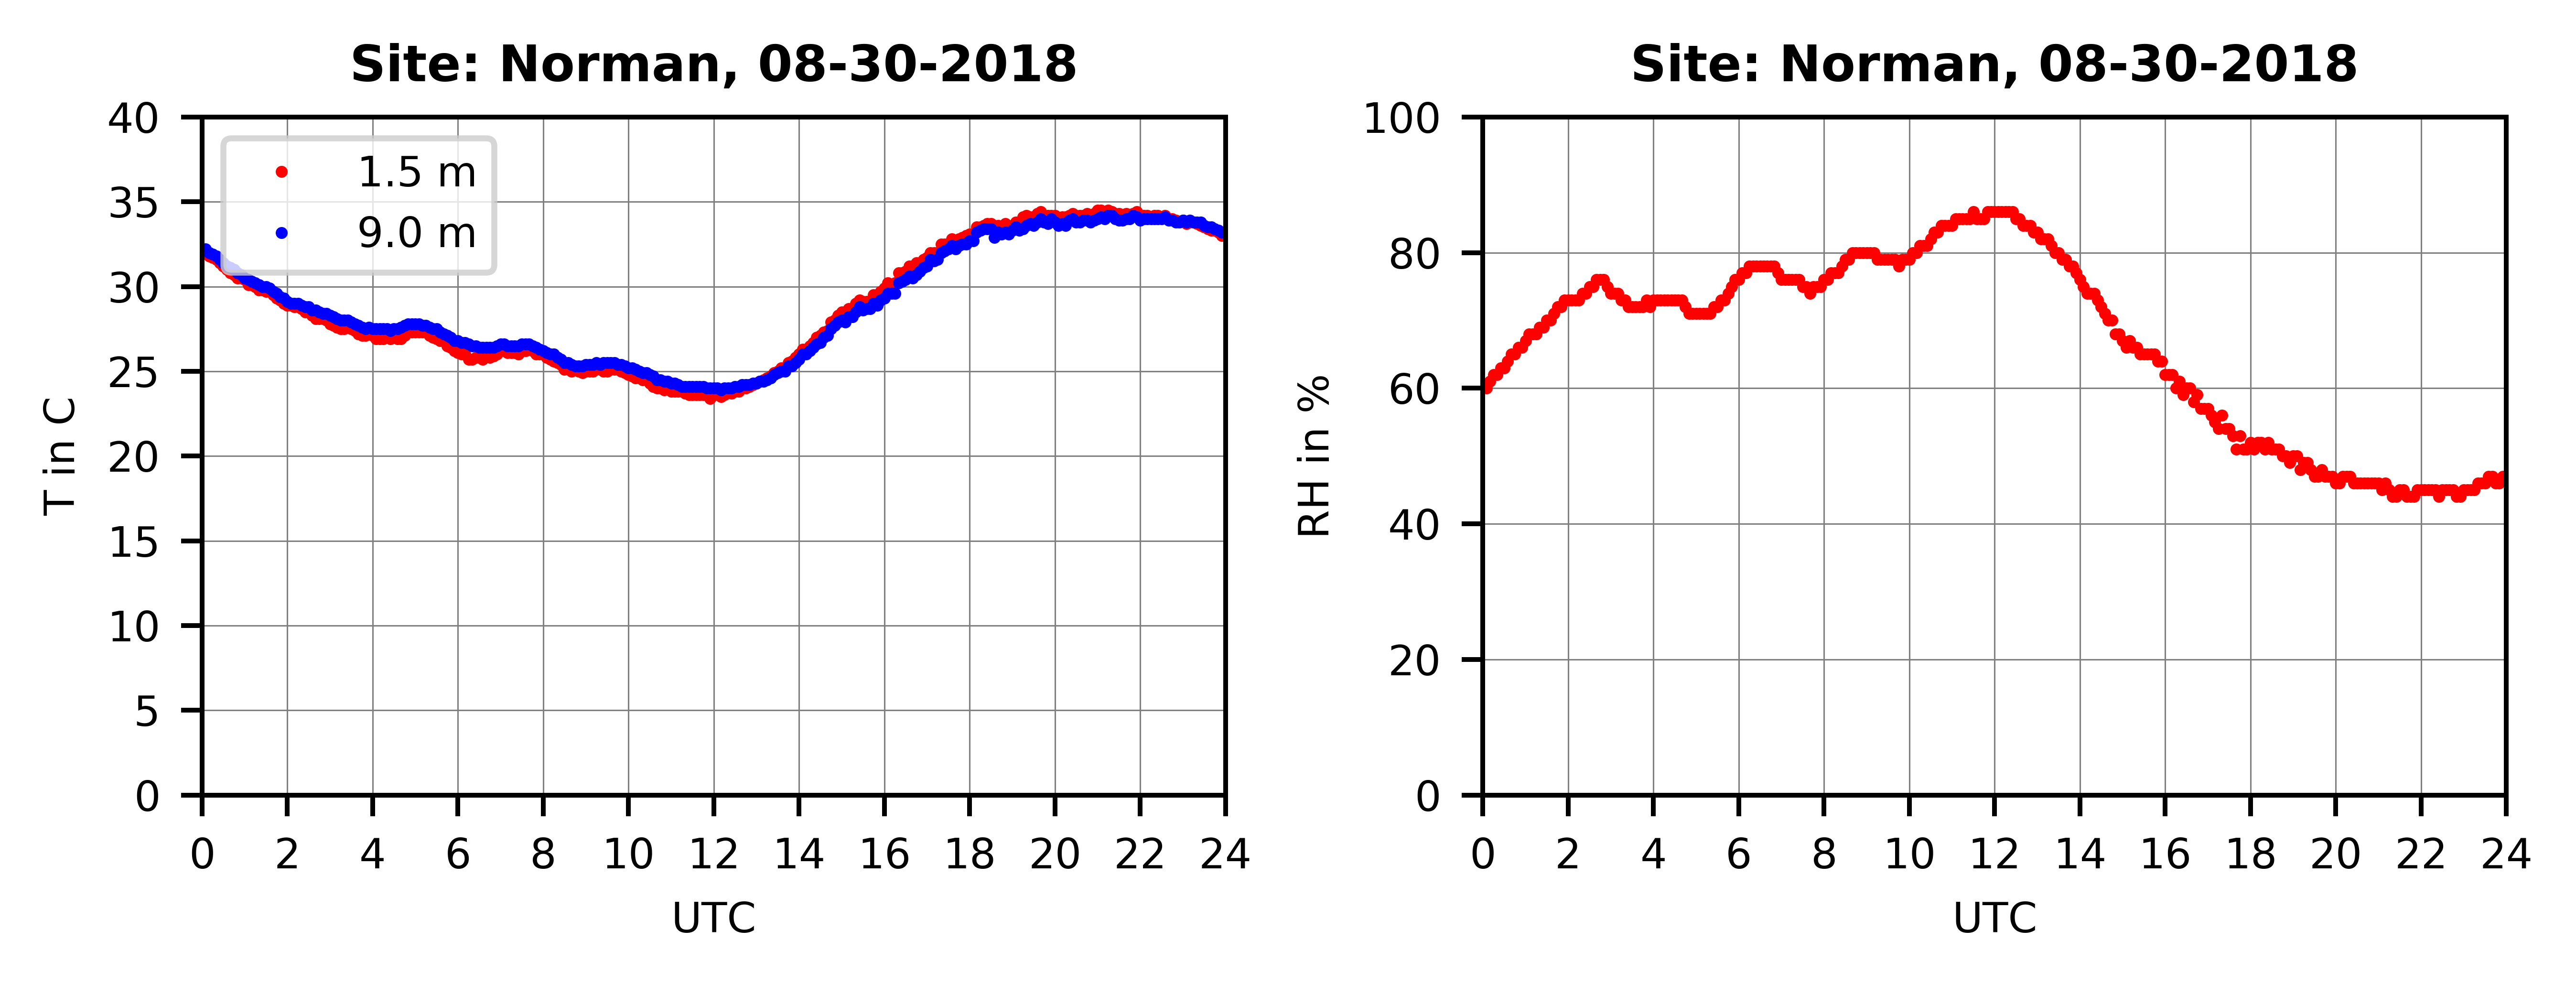

Importing  ./data/20180831nrmn.mts


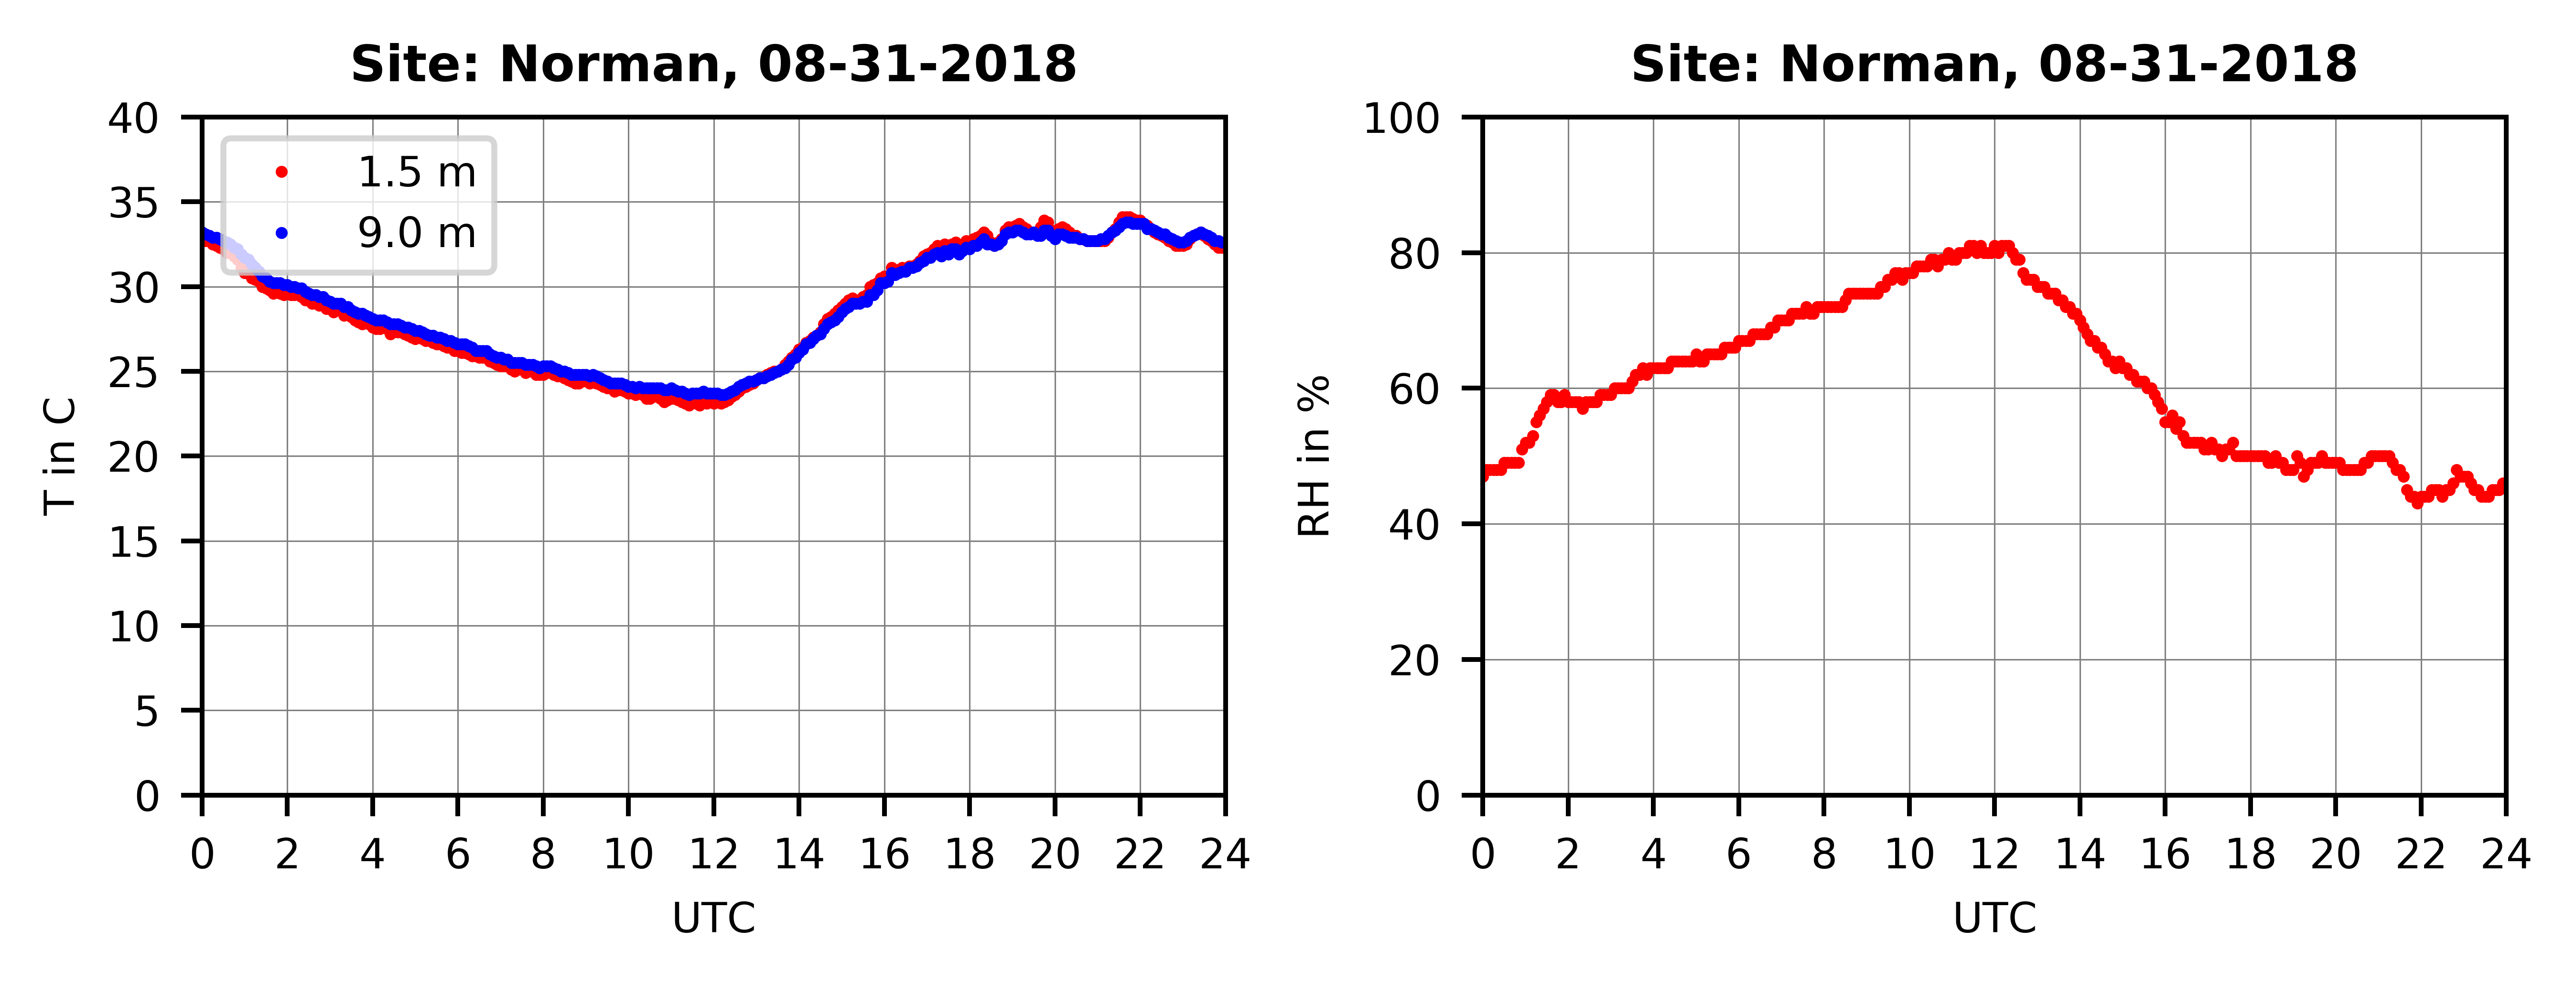

In [40]:
#Begin the actual data processing. If you want to test this section of code, 
#it will be useful to uncomment the first line below (that loops over just 1 file)
#and to comment out the loop over all of the data. 

#for d in range(0,1):                     
for d in range(0,nd):
    
    #Gets the correct day number, since Python loop index starts with zero
    day = d + 1

    #Define the filename
    filename = datadir + str(y) + str(m).zfill(2) + str(day).zfill(2) + siteID + '.mts'

    #Read in the data file using the mesonet_importfile() function that we used in HW#2
    #As before, we use an underscore (_) as a placeholder for any variable we don't
    #need to load into a Python array. 
    [STID, STNM, TIME, RELH, TAIR, WSPD, _, WDIR, _, _, _, RAIN,
            PRES, SRAD, TA9M, WS2M, _, _, _, _, _, _, _, _] = mesonet_importfile(filename)

    #Replace any flagged/missing Mesonet data by NaN 
    RELH[RELH<-100]=np.nan
    TAIR[TAIR<-100]=np.nan
    WSPD[WSPD<-100]=np.nan
    WDIR[WDIR<-100]=np.nan
    PRES[PRES<-100]=np.nan
    SRAD[SRAD<-100]=np.nan
    TA9M[TA9M<-100]=np.nan
    WS2M[WS2M<-100]=np.nan

    #Convert time from minutes into hours
    HOURS = TIME/60.
    
    #Calculate the dewpoint temperature ------------------------------
    
    
    
    
    
    
        
    # ---------------------------------------------
    #Prepare daily plots 
    # ---------------------------------------------
    #Title for each plot
    titletext = 'Site: ' + siteName + ', ' + str(m).zfill(2) + '-' + str(day).zfill(2) + '-' + str(y)

    #Set up options for plots
    plt.figure(figsize=(6,6),dpi=900,facecolor=None,linewidth=2.0)
    rc('font',weight='normal',size=7,serif='Computer Modern Roman')
    rc('savefig',dpi=900)

    #Temperature and dewpoint
    f1=plt.subplot(3,2,1)
    plt.plot(HOURS,TAIR,ls='',marker='o',mfc='r',mec='None',ms=2,label='1.5 m')
    plt.plot(HOURS,TA9M,ls='',marker='o',mfc='b',mec='None',ms=2,label='9.0 m')
    plt.xlabel('UTC')
    plt.ylabel('T in C')
    plt.title(titletext,fontweight='bold')
    plt.xlim([0,24])
    plt.ylim([0,40])
    plt.xticks(np.linspace(0,24,13))
    plt.yticks(np.linspace(0,40,9))
    plt.legend(loc='upper left')
    plt.grid(color='gray',lw=0.25)

    #RH in % 
    f2=plt.subplot(3,2,2)
    plt.plot(HOURS,RELH,ls='',marker='o',mfc='r',mec='None',ms=2)
    plt.xlabel('UTC')
    plt.ylabel('RH in %')
    plt.title(titletext,fontweight='bold')
    plt.xlim([0,24])
    plt.ylim([0,100])
    plt.xticks(np.linspace(0,24,13))
    plt.grid(color='gray',lw=0.25)

   


    # ---------------------------------------------
    # Save daily plots in PNG format
    # ---------------------------------------------

    plt.tight_layout()
    plt.savefig(pngdir+'daily_stats_'+str(y)+'_'+str(m).zfill(2)+'-'+str(day).zfill(2)+'.png',format='png',bbox_inches='tight')
    
    #Comment out the plt.show() if you don't want to display all of the plots below. 
    plt.show()
    
    #We omit the plt.show() here since we are creating so many plots. 

    # ---------------------------------------------
    # Calculate daily stats values
    # ---------------------------------------------

    #Calculate daily mean, min and max values for RH
    relh_daily[d,0] = day               #Include the day in column 1
    relh_daily[d,1] = np.nanmean(RELH)  #Daily mean RH
    relh_daily[d,2] = np.nanmin(RELH)   #Daily minimum RH
    relh_daily[d,3] = np.nanmax(RELH)   #Daily maximum RH

    #Calculate daily mean, min and max values for TAIR
    tair_daily[d,0] = day               #Include the day in column 1
    tair_daily[d,1] = np.nanmean(TAIR)  #Daily mean TAIR
    tair_daily[d,2] = np.nanmin(TAIR)   #Daily minimum TAIR
    tair_daily[d,3] = np.nanmax(TAIR)   #Daily maximum TAIR

Next we will save ASCII files with daily statistics. These files are written to the ```statdir='./stat_files/'``` directory that is defined above. 

We first create a string for the filename, then use the ```np.savetxt()``` function to save the variables to a text (ASCII) file. The ```np.c_[]``` function takes the list of variables, and arranges each element as a column of the ASCII file for output. The ```fmt=[]``` option allows us to specify the format of each variable. In this case, the day is an integer, and the other columns of the file are real numbers. More information on the ```np.savetxt()``` function can be found [here](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.savetxt.html). 

In [41]:
#Save ASCII files with daily statistics ------------------------

#RELH
fname = statdir + str(y) + str(m).zfill(2) + siteID + '_RELHdailystats.dat'
np.savetxt(fname,np.c_[relh_daily[:,0],relh_daily[:,1],relh_daily[:,2],relh_daily[:,3]],fmt=['%2.2d','%10.2f','%10.2f','%10.2f'],delimiter='\t')

#TAIR
fname = statdir + str(y) + str(m).zfill(2) + siteID + '_TAIRdailystats.dat'
np.savetxt(fname,np.c_[tair_daily[:,0],tair_daily[:,1],tair_daily[:,2],tair_daily[:,3]],fmt=['%2.2d','%10.2f','%10.2f','%10.2f'],delimiter='\t')

#Print values to screen to make sure we've created all of the data files. 
print os.listdir(statdir)

['201805nrmn_RELHdailystats.dat', '201805nrmn_TAIRdailystats.dat', '201808nrmn_PRESdailystats.dat', '201808nrmn_RELHdailystats.dat', '201808nrmn_SRADdailystats.dat', '201808nrmn_TAIRdailystats.dat', '201808nrmn_TDEWdailystats.dat', '201808nrmn_WDIRdailystats.dat', '201808nrmn_WSPDdailystats.dat']


## Homework Problems, Part I

Edit the code that is provided above following the instructions below: 

1. Compute the dewpoint temperature for each day at 1.5 m and save the dewpoint values in a new array (that you could name TDEW). <br><br>
2. Modify the plot commands for the daily timeseries plots to include dewpoint in the temperature timeseries plots (i.e. you should include both air temperature and dewpoint temperature in this plot). <br><br>
3. Create additional subplots for the wind speeds at the 2-m and 10-m level (plot 3), wind direction (plot 4), solar radiation (plot 5), and atmospheric pressure (plot 6). Note that **your figures should look identical to the examples given above**. Make sure you always plot only with markers, but not with lines. This should keep the data points from being connected, which particulary becomes a problem with wind direction plots. In order to get 6 plots in a single figure, you should use the ```plt.subplot()``` command, where the last number in the parentheses is the number of the subplot. For more information, see the examples in the [Matplotlib Tutorial](https://matplotlib.org/users/pyplot_tutorial.html). <br><br>
4. Do not worry about the fact that legends sometimes cover your actual data, but **include a legend only if a plot includes more than one data set.** The covering of data by the legends is not ideal, but is hard to avoid without manually editing the plots. The goal of this assignment is to teach you to process data quickly for screening purposes; making the plots attractive is of secondary importance for this exercise. However, make sure that the axis scales and labels are chosen properly for each variable. See the example code above for how you can define the axis limits (e.g. ```plt.xlim([xmin,xmax])``` for the x-limits) and the locations of the tick marks (e.g. ```plt.xticks(np.linspace(min,max,nvals))```).<br><br>
5. Create additional arrays that include daily mean, minimum, and maximum values for dewpoint, 10-m wind speed, wind direction, pressure, and solar radiation, and save these values as ASCII data sets. You can use the preallocated arrays (e.g. ```tdew_daily```, ```wspd_daily```, etc.) as variables. <br><br>
6. **Think carefully about how you compute the daily mean wind direction!** Remember what you had to do for HW\#2, and include similar calculations in your script. Also, **when computing the daily mean, max, and min values of solar radiation, first replace the nighttime data when all values are zero by NaN values**; this will give you more representative data for just the daytime period. <br><br>
7. Verify that your calculations are reasonable by comparing your statistics with the data given in the Mesonet summary file for **August, 2018**, which can be found [here](http://www.mesonet.org/index.php/weather/station_monthly_summaries). 


***
### Plots of daily mean values
Next, we want to make a plot that shows the daily mean value of the variables for the entire month. Some code to get you started making this plot can be found below. 

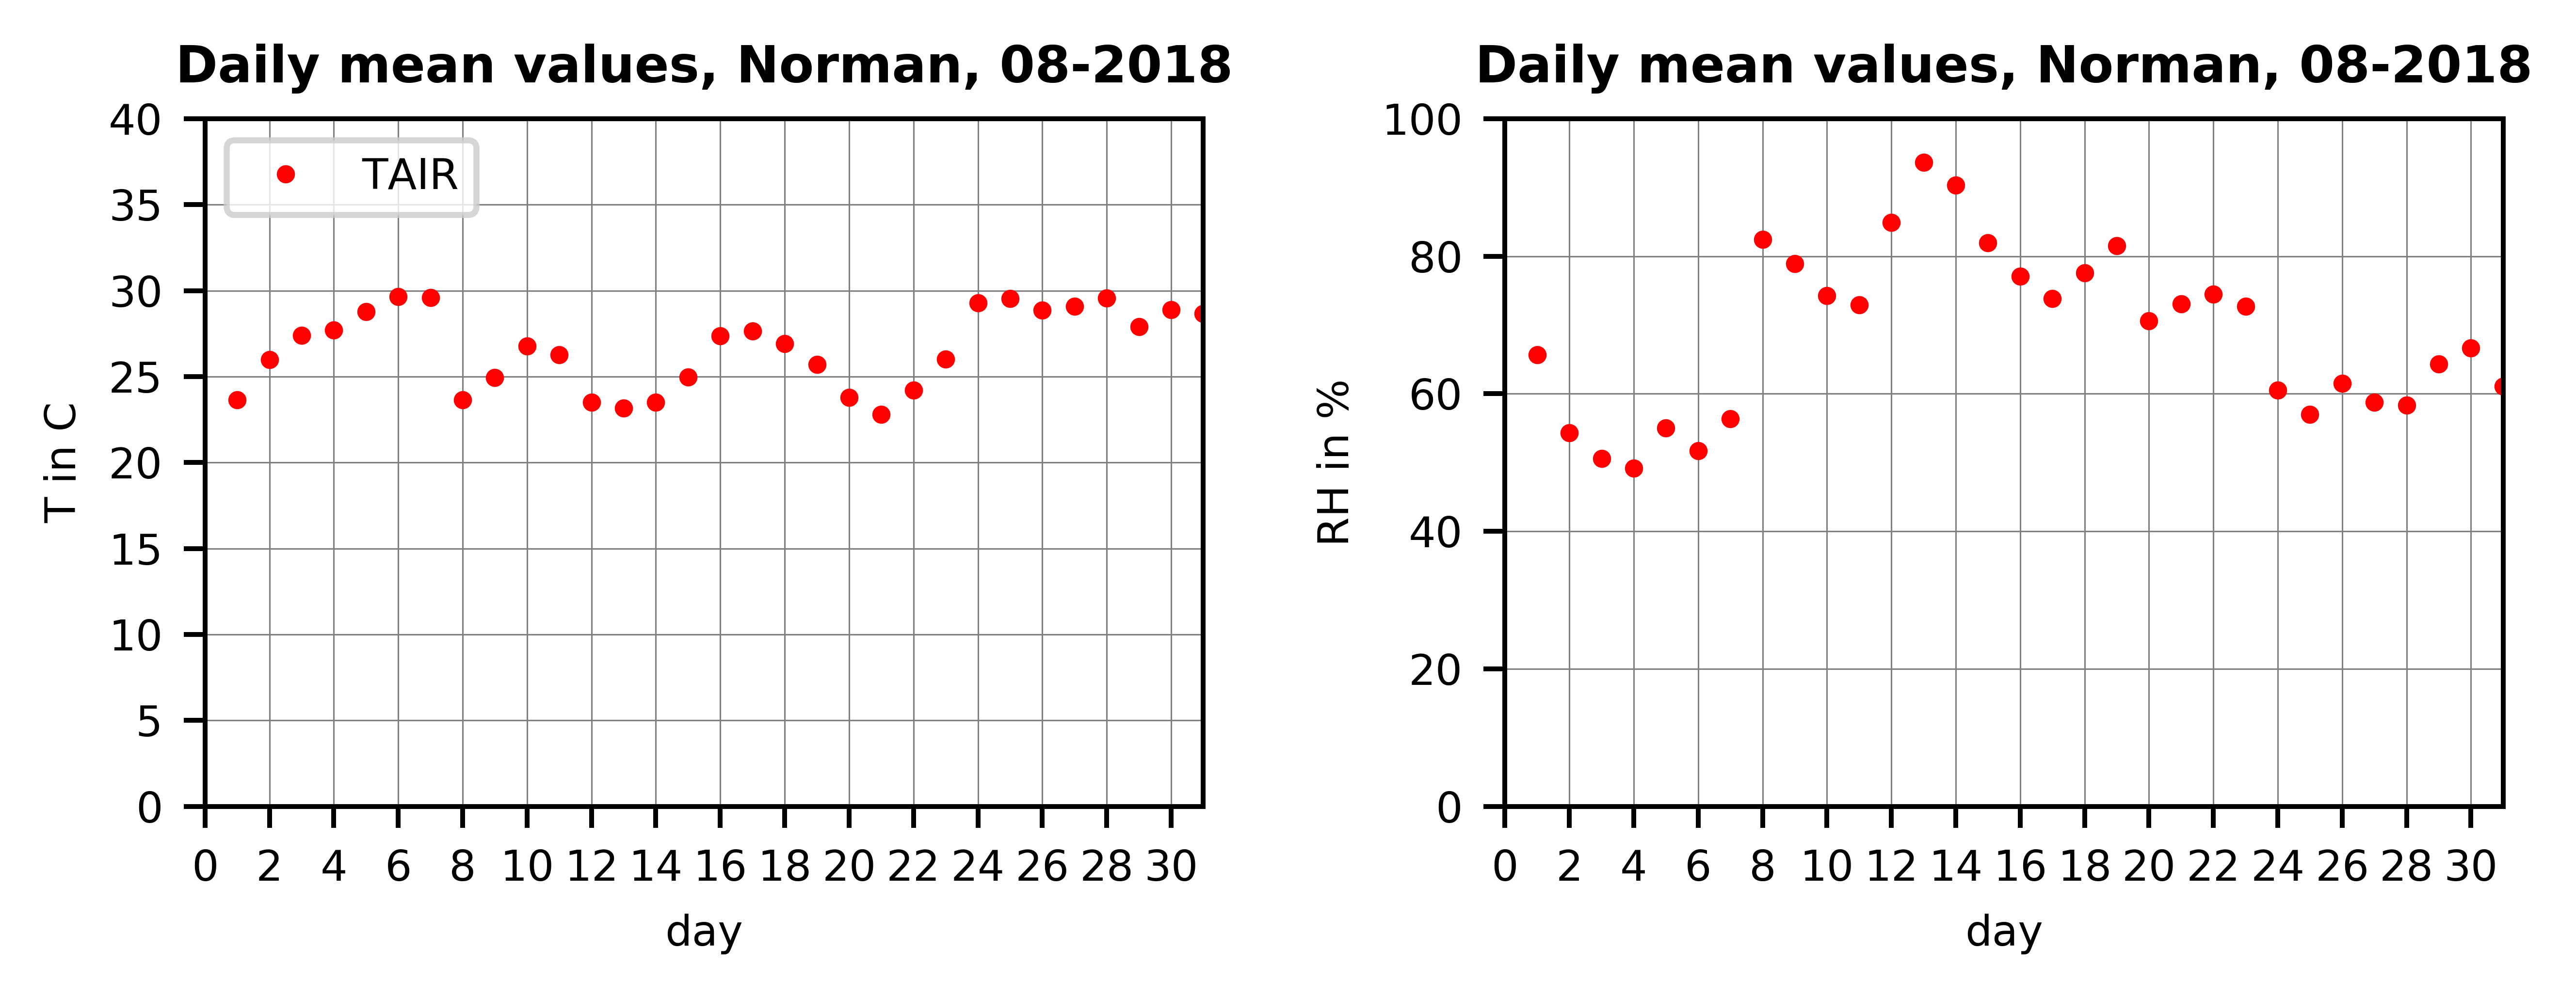

In [42]:
#Create plot that shows daily mean values for entire month

#Create the title for the plot, given the site name, month, and year
titletext = 'Daily mean values, ' + siteName + ', ' + str(m).zfill(2) + '-' + str(y)

#Set up options for plots
plt.figure(figsize=(6,6),dpi=900,facecolor=None,linewidth=2.0)
rc('font',weight='normal',size=7,serif='Computer Modern Roman')
rc('savefig',dpi=900)

#Temperature and dewpoint
f1=plt.subplot(3,2,1)
plt.plot(tair_daily[:,0],tair_daily[:,1],ls='',marker='o',mfc='r',mec='None',ms=3,label='TAIR')
plt.xlabel('day')
plt.ylabel('T in C')
plt.title(titletext,fontweight='bold')
plt.xlim([1,nd])
plt.ylim([0,40])
plt.xticks(np.arange(0,nd+1,2))
plt.yticks(np.linspace(0,40,9))
plt.legend(loc='upper left')
plt.grid(color='gray',lw=0.25)

#Relative humidity
f2=plt.subplot(3,2,2)
plt.plot(relh_daily[:,0],relh_daily[:,1],ls='',marker='o',mfc='r',mec='None',ms=3)
plt.xlabel('day')
plt.ylabel('RH in %')
plt.title(titletext,fontweight='bold')
plt.xlim([1,nd])
plt.ylim([0,100])
plt.xticks(np.arange(0,nd+1,2))
plt.yticks(np.linspace(0,100,6))
plt.grid(color='gray',lw=0.25)

plt.tight_layout()
plt.savefig(pngdir+'monthly_mean_'+str(m).zfill(2)+'_'+str(y)+'.png',format='png',bbox_inches='tight')
plt.show()

## Homework Problems, Part II
Please complete the following tasks:
<ol start="5">

  <li>Expand the plot above to include daily mean values for other variables. Your plot should include daily mean values of temperature and dewpoint (panel 1), relative humidity (panel 2), wind speed (panel 3), wind direction (panel 4), solar radiation (panel 5), and atmospheric pressure (panel 6). Your plot should be identical to the example that is given in **Figure 2** above. 
  </li><br><br>
  
  <li>Create a third plot in your Python script that is similar to **Figure 3** above and includes the daily mean, maximum, and minimum for air temperature (top panel), dew point temperature (middle panel), and wind speed (bottom panel). Save you plot as a .png file similar to how it is done for the second plot. Make sure you update the name of the plot, otherwise you will overwrite the file for the second figure. 
  </li>
  
</ol>

### Submission instructions

Create a .zip file that includes your updated script, the ASCII files with the daily statistics, and all plots saved by your script. Upload this .zip file into Dropbox on Canvas. You do not need to submit a separate write up for this assignment, but you can add a text file with any comments you think are import. **Dropbox will close at 11:59 pm on October 24, 2018, so be sure to submit your assignment before then!** Late submissions will only be accepted under extraordinary circumstances. 

### Helpful tips
If you have questions about creating plots in Matplotlib (the Python plotting package), the online documentation is a great place to start before asking your TA or instructor for help. A very good tutorial can be found [here]( https://matplotlib.org/users/pyplot_tutorial.html); however, there are many other useful pages on [the Matplotlib website](https://matplotlib.org).